In [59]:
# The mushroom data came from:
# https://www.kaggle.com/uciml/mushroom-classification
# and was processed into one-hot-encoded data in the ~/data/mushrooms directory.

In [60]:
import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

Using cpu device


In [61]:
class DataframeDataset(torch.utils.data.Dataset):

  def __init__(self, DF):
        # Initialization.
        self.DF = DF

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.DF)

  def __getitem__(self, index):
        # Generates one sample of data.
        
        X = self.DF.iloc[index][:-1].values.astype(np.float32)
        y = self.DF.iloc[index]['class']

        return X, y

In [62]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    model.train()
    
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        
        pred = model(X)
        loss = loss_fn(pred.squeeze(), y.float())

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    
    numActuallyPoisonous = 0
    numCorrectlyPredictedPoisonous = 0
    
    model.eval()

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            
            
            test_loss += loss_fn(pred.squeeze(), y.float()).item()
            correct += (abs(pred.squeeze()-y.float()) <= 0.5).type(torch.float).sum().item()
            
            numActuallyPoisonous += (y.float() > 0.5).type(torch.float).sum().item()
            numCorrectlyPredictedPoisonous += torch.logical_and(y.float() > 0.5, pred.squeeze()>0.5) \
            .type(torch.float).sum().item()
        
    test_loss /= num_batches
    correct /= size
    
    recall = numCorrectlyPredictedPoisonous / numActuallyPoisonous
    
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    print(f"Recall: \n Accuracy: {(100*recall):>0.1f}% \n")
    
    return test_loss, recall

In [77]:
recalls = []
loss_graphs = []

for i in range(20):
    df = pd.read_csv(f"mushrooms_one_hot_encoded_partial_{i}.csv", index_col=[0])
    
    numFeatures1 = len(df.columns) - 1
    numFeatures2 = numFeatures1 * 2 // 3
    numFeatures3 = numFeatures2 * 2 // 5
    
    dftrain, dftest = train_test_split(df, test_size=0.2)
    
    dftrainx = DataframeDataset(dftrain)
    dftestx = DataframeDataset(dftest)
    
    train_dataloader = DataLoader(dftrainx, batch_size=75)
    test_dataloader = DataLoader(dftestx, batch_size=75)
    
    class NeuralNetwork(nn.Module):
        def __init__(self):
            super(NeuralNetwork, self).__init__()
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(numFeatures1, numFeatures2),
                nn.BatchNorm1d(numFeatures2),
                nn.Linear(numFeatures2, numFeatures3),
                nn.BatchNorm1d(numFeatures3),
                nn.Linear(numFeatures3, 1),            
                nn.Sigmoid()
            )
    
        def forward(self, x):
            logits = self.linear_relu_stack(x)
            return logits
    
    model = NeuralNetwork().to(device)
    
    for xx in model.linear_relu_stack:
        if isinstance(xx, nn.Linear):
            torch.nn.init.xavier_uniform_(xx.weight)
            
    # Specify the hyperparameter values.

    learning_rate = 1e-3
    epochs = 200
    
    # Initialize the loss function.

    loss_fn = nn.BCELoss()
    
    # Initialize the optimizer by registering the model’s parameters that need to be trained, 
    # and passing in the learning rate hyperparameter.

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    
    losses = []
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loss, recall = test_loop(test_dataloader, model, loss_fn)
        losses.append(test_loss)
        print("Done!")
        
    recalls.append(recall)
    loss_graphs.append(losses)

Epoch 1
-------------------------------
loss: 0.779811  [    0/ 6499]
loss: 0.746291  [  750/ 6499]
loss: 0.714255  [ 1500/ 6499]
loss: 0.695947  [ 2250/ 6499]
loss: 0.600978  [ 3000/ 6499]
loss: 0.639001  [ 3750/ 6499]
loss: 0.624529  [ 4500/ 6499]
loss: 0.602499  [ 5250/ 6499]
loss: 0.598682  [ 6000/ 6499]
Test Error: 
 Accuracy: 76.6%, Avg loss: 0.509329 

Recall: 
 Accuracy: 77.3% 

Done!
Epoch 2
-------------------------------
loss: 0.504492  [    0/ 6499]
loss: 0.486730  [  750/ 6499]
loss: 0.503483  [ 1500/ 6499]
loss: 0.484980  [ 2250/ 6499]
loss: 0.407237  [ 3000/ 6499]
loss: 0.441980  [ 3750/ 6499]
loss: 0.483630  [ 4500/ 6499]
loss: 0.458553  [ 5250/ 6499]
loss: 0.461555  [ 6000/ 6499]
Test Error: 
 Accuracy: 87.6%, Avg loss: 0.387887 

Recall: 
 Accuracy: 84.3% 

Done!
Epoch 3
-------------------------------
loss: 0.385432  [    0/ 6499]
loss: 0.369882  [  750/ 6499]
loss: 0.409406  [ 1500/ 6499]
loss: 0.381636  [ 2250/ 6499]
loss: 0.312134  [ 3000/ 6499]
loss: 0.345035  [ 

loss: 0.116639  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.101305 

Recall: 
 Accuracy: 98.1% 

Done!
Epoch 22
-------------------------------
loss: 0.103085  [    0/ 6499]
loss: 0.099186  [  750/ 6499]
loss: 0.173703  [ 1500/ 6499]
loss: 0.090426  [ 2250/ 6499]
loss: 0.074328  [ 3000/ 6499]
loss: 0.118616  [ 3750/ 6499]
loss: 0.179924  [ 4500/ 6499]
loss: 0.125173  [ 5250/ 6499]
loss: 0.112439  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.098028 

Recall: 
 Accuracy: 98.1% 

Done!
Epoch 23
-------------------------------
loss: 0.099746  [    0/ 6499]
loss: 0.096245  [  750/ 6499]
loss: 0.169826  [ 1500/ 6499]
loss: 0.087006  [ 2250/ 6499]
loss: 0.071833  [ 3000/ 6499]
loss: 0.115930  [ 3750/ 6499]
loss: 0.175645  [ 4500/ 6499]
loss: 0.122040  [ 5250/ 6499]
loss: 0.108518  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.094959 

Recall: 
 Accuracy: 98.1% 

Done!
Epoch 24
-------------------------------
loss: 0.096609  [    0/ 6499]
loss: 0.093496  [  

loss: 0.044021  [ 3000/ 6499]
loss: 0.082748  [ 3750/ 6499]
loss: 0.118483  [ 4500/ 6499]
loss: 0.087017  [ 5250/ 6499]
loss: 0.063866  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.058608 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 43
-------------------------------
loss: 0.057414  [    0/ 6499]
loss: 0.060255  [  750/ 6499]
loss: 0.105815  [ 1500/ 6499]
loss: 0.049447  [ 2250/ 6499]
loss: 0.043071  [ 3000/ 6499]
loss: 0.081456  [ 3750/ 6499]
loss: 0.116248  [ 4500/ 6499]
loss: 0.085800  [ 5250/ 6499]
loss: 0.062399  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.057338 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 44
-------------------------------
loss: 0.055934  [    0/ 6499]
loss: 0.059013  [  750/ 6499]
loss: 0.103174  [ 1500/ 6499]
loss: 0.048366  [ 2250/ 6499]
loss: 0.042146  [ 3000/ 6499]
loss: 0.080187  [ 3750/ 6499]
loss: 0.114062  [ 4500/ 6499]
loss: 0.084614  [ 5250/ 6499]
loss: 0.060981  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.056106 

Reca

loss: 0.039617  [  750/ 6499]
loss: 0.063361  [ 1500/ 6499]
loss: 0.033072  [ 2250/ 6499]
loss: 0.028130  [ 3000/ 6499]
loss: 0.059565  [ 3750/ 6499]
loss: 0.080170  [ 4500/ 6499]
loss: 0.065640  [ 5250/ 6499]
loss: 0.040793  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.037989 

Recall: 
 Accuracy: 99.2% 

Done!
Epoch 64
-------------------------------
loss: 0.033051  [    0/ 6499]
loss: 0.038791  [  750/ 6499]
loss: 0.061784  [ 1500/ 6499]
loss: 0.032457  [ 2250/ 6499]
loss: 0.027546  [ 3000/ 6499]
loss: 0.058646  [ 3750/ 6499]
loss: 0.078732  [ 4500/ 6499]
loss: 0.064763  [ 5250/ 6499]
loss: 0.039993  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.037253 

Recall: 
 Accuracy: 99.4% 

Done!
Epoch 65
-------------------------------
loss: 0.032204  [    0/ 6499]
loss: 0.037984  [  750/ 6499]
loss: 0.060254  [ 1500/ 6499]
loss: 0.031857  [ 2250/ 6499]
loss: 0.026976  [ 3000/ 6499]
loss: 0.057742  [ 3750/ 6499]
loss: 0.077325  [ 4500/ 6499]
loss: 0.063893  [ 5250/ 64

loss: 0.038666  [ 1500/ 6499]
loss: 0.022634  [ 2250/ 6499]
loss: 0.018392  [ 3000/ 6499]
loss: 0.043375  [ 3750/ 6499]
loss: 0.055758  [ 4500/ 6499]
loss: 0.048678  [ 5250/ 6499]
loss: 0.027536  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.025631 

Recall: 
 Accuracy: 99.4% 

Done!
Epoch 85
-------------------------------
loss: 0.019823  [    0/ 6499]
loss: 0.025435  [  750/ 6499]
loss: 0.037851  [ 1500/ 6499]
loss: 0.022247  [ 2250/ 6499]
loss: 0.018043  [ 3000/ 6499]
loss: 0.042752  [ 3750/ 6499]
loss: 0.054860  [ 4500/ 6499]
loss: 0.047942  [ 5250/ 6499]
loss: 0.027059  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.025179 

Recall: 
 Accuracy: 99.4% 

Done!
Epoch 86
-------------------------------
loss: 0.019391  [    0/ 6499]
loss: 0.024969  [  750/ 6499]
loss: 0.037062  [ 1500/ 6499]
loss: 0.021868  [ 2250/ 6499]
loss: 0.017702  [ 3000/ 6499]
loss: 0.042142  [ 3750/ 6499]
loss: 0.053982  [ 4500/ 6499]
loss: 0.047213  [ 5250/ 6499]
loss: 0.026592  [ 6000/ 64

loss: 0.025891  [ 1500/ 6499]
loss: 0.016083  [ 2250/ 6499]
loss: 0.012637  [ 3000/ 6499]
loss: 0.032563  [ 3750/ 6499]
loss: 0.040569  [ 4500/ 6499]
loss: 0.034809  [ 5250/ 6499]
loss: 0.019545  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.018006 

Recall: 
 Accuracy: 99.4% 

Done!
Epoch 106
-------------------------------
loss: 0.013159  [    0/ 6499]
loss: 0.017945  [  750/ 6499]
loss: 0.025460  [ 1500/ 6499]
loss: 0.015843  [ 2250/ 6499]
loss: 0.012432  [ 3000/ 6499]
loss: 0.032152  [ 3750/ 6499]
loss: 0.040007  [ 4500/ 6499]
loss: 0.034240  [ 5250/ 6499]
loss: 0.019254  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.017726 

Recall: 
 Accuracy: 99.4% 

Done!
Epoch 107
-------------------------------
loss: 0.012939  [    0/ 6499]
loss: 0.017686  [  750/ 6499]
loss: 0.025042  [ 1500/ 6499]
loss: 0.015608  [ 2250/ 6499]
loss: 0.012232  [ 3000/ 6499]
loss: 0.031749  [ 3750/ 6499]
loss: 0.039458  [ 4500/ 6499]
loss: 0.033679  [ 5250/ 6499]
loss: 0.018969  [ 6000/ 

loss: 0.018923  [ 1500/ 6499]
loss: 0.012015  [ 2250/ 6499]
loss: 0.009222  [ 3000/ 6499]
loss: 0.025436  [ 3750/ 6499]
loss: 0.030955  [ 4500/ 6499]
loss: 0.024717  [ 5250/ 6499]
loss: 0.014637  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.013286 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 127
-------------------------------
loss: 0.009650  [    0/ 6499]
loss: 0.013692  [  750/ 6499]
loss: 0.018678  [ 1500/ 6499]
loss: 0.011864  [ 2250/ 6499]
loss: 0.009098  [ 3000/ 6499]
loss: 0.025165  [ 3750/ 6499]
loss: 0.030593  [ 4500/ 6499]
loss: 0.024331  [ 5250/ 6499]
loss: 0.014456  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.013112 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 128
-------------------------------
loss: 0.009528  [    0/ 6499]
loss: 0.013539  [  750/ 6499]
loss: 0.018438  [ 1500/ 6499]
loss: 0.011716  [ 2250/ 6499]
loss: 0.008977  [ 3000/ 6499]
loss: 0.024900  [ 3750/ 6499]
loss: 0.030239  [ 4500/ 6499]
loss: 0.023952  [ 5250/ 6499]
loss: 0.014279  [ 6000/ 

loss: 0.014801  [ 1500/ 6499]
loss: 0.009418  [ 2250/ 6499]
loss: 0.007111  [ 3000/ 6499]
loss: 0.020716  [ 3750/ 6499]
loss: 0.024657  [ 4500/ 6499]
loss: 0.018113  [ 5250/ 6499]
loss: 0.011535  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.010334 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 148
-------------------------------
loss: 0.007609  [    0/ 6499]
loss: 0.011067  [  750/ 6499]
loss: 0.014649  [ 1500/ 6499]
loss: 0.009319  [ 2250/ 6499]
loss: 0.007032  [ 3000/ 6499]
loss: 0.020534  [ 3750/ 6499]
loss: 0.024415  [ 4500/ 6499]
loss: 0.017867  [ 5250/ 6499]
loss: 0.011418  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.010223 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 149
-------------------------------
loss: 0.007534  [    0/ 6499]
loss: 0.010967  [  750/ 6499]
loss: 0.014500  [ 1500/ 6499]
loss: 0.009222  [ 2250/ 6499]
loss: 0.006955  [ 3000/ 6499]
loss: 0.020356  [ 3750/ 6499]
loss: 0.024177  [ 4500/ 6499]
loss: 0.017627  [ 5250/ 6499]
loss: 0.011303  [ 6000/ 

loss: 0.009369  [  750/ 6499]
loss: 0.012163  [ 1500/ 6499]
loss: 0.007673  [ 2250/ 6499]
loss: 0.005732  [ 3000/ 6499]
loss: 0.017506  [ 3750/ 6499]
loss: 0.020362  [ 4500/ 6499]
loss: 0.013907  [ 5250/ 6499]
loss: 0.009487  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.008412 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 169
-------------------------------
loss: 0.006301  [    0/ 6499]
loss: 0.009298  [  750/ 6499]
loss: 0.012061  [ 1500/ 6499]
loss: 0.007604  [ 2250/ 6499]
loss: 0.005678  [ 3000/ 6499]
loss: 0.017380  [ 3750/ 6499]
loss: 0.020193  [ 4500/ 6499]
loss: 0.013749  [ 5250/ 6499]
loss: 0.009407  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.008338 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 170
-------------------------------
loss: 0.006251  [    0/ 6499]
loss: 0.009228  [  750/ 6499]
loss: 0.011962  [ 1500/ 6499]
loss: 0.007537  [ 2250/ 6499]
loss: 0.005626  [ 3000/ 6499]
loss: 0.017256  [ 3750/ 6499]
loss: 0.020027  [ 4500/ 6499]
loss: 0.013594  [ 5250/ 

Test Error: 
 Accuracy: 99.9%, Avg loss: 0.007143 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 189
-------------------------------
loss: 0.005434  [    0/ 6499]
loss: 0.008074  [  750/ 6499]
loss: 0.010354  [ 1500/ 6499]
loss: 0.006437  [ 2250/ 6499]
loss: 0.004778  [ 3000/ 6499]
loss: 0.015233  [ 3750/ 6499]
loss: 0.017306  [ 4500/ 6499]
loss: 0.011147  [ 5250/ 6499]
loss: 0.008066  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.007089 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 190
-------------------------------
loss: 0.005397  [    0/ 6499]
loss: 0.008021  [  750/ 6499]
loss: 0.010282  [ 1500/ 6499]
loss: 0.006387  [ 2250/ 6499]
loss: 0.004740  [ 3000/ 6499]
loss: 0.015141  [ 3750/ 6499]
loss: 0.017182  [ 4500/ 6499]
loss: 0.011040  [ 5250/ 6499]
loss: 0.008010  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.007037 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 191
-------------------------------
loss: 0.005361  [    0/ 6499]
loss: 0.007969  [  750/ 6499]
loss: 0.010211  

loss: 0.253727  [ 3750/ 6499]
loss: 0.196877  [ 4500/ 6499]
loss: 0.127905  [ 5250/ 6499]
loss: 0.170440  [ 6000/ 6499]
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.177670 

Recall: 
 Accuracy: 90.9% 

Done!
Epoch 10
-------------------------------
loss: 0.129014  [    0/ 6499]
loss: 0.167701  [  750/ 6499]
loss: 0.181061  [ 1500/ 6499]
loss: 0.224032  [ 2250/ 6499]
loss: 0.271010  [ 3000/ 6499]
loss: 0.244088  [ 3750/ 6499]
loss: 0.188341  [ 4500/ 6499]
loss: 0.119597  [ 5250/ 6499]
loss: 0.164878  [ 6000/ 6499]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.169135 

Recall: 
 Accuracy: 92.1% 

Done!
Epoch 11
-------------------------------
loss: 0.120996  [    0/ 6499]
loss: 0.157685  [  750/ 6499]
loss: 0.174494  [ 1500/ 6499]
loss: 0.215908  [ 2250/ 6499]
loss: 0.262061  [ 3000/ 6499]
loss: 0.235922  [ 3750/ 6499]
loss: 0.181016  [ 4500/ 6499]
loss: 0.112523  [ 5250/ 6499]
loss: 0.160141  [ 6000/ 6499]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.161736 

Recall: 
 Accuracy: 92.3% 

Done!


loss: 0.119747  [ 1500/ 6499]
loss: 0.148568  [ 2250/ 6499]
loss: 0.177512  [ 3000/ 6499]
loss: 0.167640  [ 3750/ 6499]
loss: 0.120253  [ 4500/ 6499]
loss: 0.057750  [ 5250/ 6499]
loss: 0.117441  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.099394 

Recall: 
 Accuracy: 97.2% 

Done!
Epoch 31
-------------------------------
loss: 0.055029  [    0/ 6499]
loss: 0.073866  [  750/ 6499]
loss: 0.117942  [ 1500/ 6499]
loss: 0.146826  [ 2250/ 6499]
loss: 0.174679  [ 3000/ 6499]
loss: 0.165316  [ 3750/ 6499]
loss: 0.118498  [ 4500/ 6499]
loss: 0.056414  [ 5250/ 6499]
loss: 0.115906  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.097675 

Recall: 
 Accuracy: 97.2% 

Done!
Epoch 32
-------------------------------
loss: 0.053609  [    0/ 6499]
loss: 0.071998  [  750/ 6499]
loss: 0.116170  [ 1500/ 6499]
loss: 0.145152  [ 2250/ 6499]
loss: 0.171897  [ 3000/ 6499]
loss: 0.163016  [ 3750/ 6499]
loss: 0.116793  [ 4500/ 6499]
loss: 0.055141  [ 5250/ 6499]
loss: 0.114383  [ 6000/ 64

loss: 0.048321  [  750/ 6499]
loss: 0.086382  [ 1500/ 6499]
loss: 0.120289  [ 2250/ 6499]
loss: 0.124946  [ 3000/ 6499]
loss: 0.121607  [ 3750/ 6499]
loss: 0.089895  [ 4500/ 6499]
loss: 0.038520  [ 5250/ 6499]
loss: 0.085627  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.071268 

Recall: 
 Accuracy: 97.2% 

Done!
Epoch 52
-------------------------------
loss: 0.035127  [    0/ 6499]
loss: 0.047466  [  750/ 6499]
loss: 0.084965  [ 1500/ 6499]
loss: 0.119174  [ 2250/ 6499]
loss: 0.122718  [ 3000/ 6499]
loss: 0.119516  [ 3750/ 6499]
loss: 0.088648  [ 4500/ 6499]
loss: 0.037902  [ 5250/ 6499]
loss: 0.084096  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.070184 

Recall: 
 Accuracy: 97.2% 

Done!
Epoch 53
-------------------------------
loss: 0.034502  [    0/ 6499]
loss: 0.046636  [  750/ 6499]
loss: 0.083561  [ 1500/ 6499]
loss: 0.118070  [ 2250/ 6499]
loss: 0.120516  [ 3000/ 6499]
loss: 0.117435  [ 3750/ 6499]
loss: 0.087412  [ 4500/ 6499]
loss: 0.037299  [ 5250/ 64

loss: 0.059725  [ 1500/ 6499]
loss: 0.098789  [ 2250/ 6499]
loss: 0.084475  [ 3000/ 6499]
loss: 0.081150  [ 3750/ 6499]
loss: 0.065743  [ 4500/ 6499]
loss: 0.028126  [ 5250/ 6499]
loss: 0.055382  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.051239 

Recall: 
 Accuracy: 98.0% 

Done!
Epoch 73
-------------------------------
loss: 0.024804  [    0/ 6499]
loss: 0.033773  [  750/ 6499]
loss: 0.058637  [ 1500/ 6499]
loss: 0.097867  [ 2250/ 6499]
loss: 0.082921  [ 3000/ 6499]
loss: 0.079470  [ 3750/ 6499]
loss: 0.064702  [ 4500/ 6499]
loss: 0.027731  [ 5250/ 6499]
loss: 0.054133  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.050422 

Recall: 
 Accuracy: 98.0% 

Done!
Epoch 74
-------------------------------
loss: 0.024422  [    0/ 6499]
loss: 0.033264  [  750/ 6499]
loss: 0.057568  [ 1500/ 6499]
loss: 0.096955  [ 2250/ 6499]
loss: 0.081401  [ 3000/ 6499]
loss: 0.077817  [ 3750/ 6499]
loss: 0.063672  [ 4500/ 6499]
loss: 0.027341  [ 5250/ 6499]
loss: 0.052907  [ 6000/ 64

loss: 0.040730  [ 1500/ 6499]
loss: 0.081846  [ 2250/ 6499]
loss: 0.058571  [ 3000/ 6499]
loss: 0.051898  [ 3750/ 6499]
loss: 0.046473  [ 4500/ 6499]
loss: 0.020986  [ 5250/ 6499]
loss: 0.034445  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.036656 

Recall: 
 Accuracy: 98.3% 

Done!
Epoch 94
-------------------------------
loss: 0.018119  [    0/ 6499]
loss: 0.024714  [  750/ 6499]
loss: 0.040018  [ 1500/ 6499]
loss: 0.081173  [ 2250/ 6499]
loss: 0.057642  [ 3000/ 6499]
loss: 0.050817  [ 3750/ 6499]
loss: 0.045700  [ 4500/ 6499]
loss: 0.020700  [ 5250/ 6499]
loss: 0.033711  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.036090 

Recall: 
 Accuracy: 98.3% 

Done!
Epoch 95
-------------------------------
loss: 0.017859  [    0/ 6499]
loss: 0.024355  [  750/ 6499]
loss: 0.039322  [ 1500/ 6499]
loss: 0.080513  [ 2250/ 6499]
loss: 0.056735  [ 3000/ 6499]
loss: 0.049761  [ 3750/ 6499]
loss: 0.044940  [ 4500/ 6499]
loss: 0.020418  [ 5250/ 6499]
loss: 0.032999  [ 6000/ 64

loss: 0.028726  [ 1500/ 6499]
loss: 0.070123  [ 2250/ 6499]
loss: 0.042995  [ 3000/ 6499]
loss: 0.034066  [ 3750/ 6499]
loss: 0.032909  [ 4500/ 6499]
loss: 0.015851  [ 5250/ 6499]
loss: 0.022691  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.026841 

Recall: 
 Accuracy: 98.3% 

Done!
Epoch 115
-------------------------------
loss: 0.013523  [    0/ 6499]
loss: 0.018276  [  750/ 6499]
loss: 0.028286  [ 1500/ 6499]
loss: 0.069679  [ 2250/ 6499]
loss: 0.042421  [ 3000/ 6499]
loss: 0.033435  [ 3750/ 6499]
loss: 0.032392  [ 4500/ 6499]
loss: 0.015649  [ 5250/ 6499]
loss: 0.022284  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.026470 

Recall: 
 Accuracy: 98.3% 

Done!
Epoch 116
-------------------------------
loss: 0.013344  [    0/ 6499]
loss: 0.018022  [  750/ 6499]
loss: 0.027857  [ 1500/ 6499]
loss: 0.069245  [ 2250/ 6499]
loss: 0.041860  [ 3000/ 6499]
loss: 0.032821  [ 3750/ 6499]
loss: 0.031886  [ 4500/ 6499]
loss: 0.015450  [ 5250/ 6499]
loss: 0.021889  [ 6000/ 

loss: 0.021281  [ 1500/ 6499]
loss: 0.062470  [ 2250/ 6499]
loss: 0.033132  [ 3000/ 6499]
loss: 0.023695  [ 3750/ 6499]
loss: 0.024010  [ 4500/ 6499]
loss: 0.012262  [ 5250/ 6499]
loss: 0.016010  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.020424 

Recall: 
 Accuracy: 99.6% 

Done!
Epoch 136
-------------------------------
loss: 0.010357  [    0/ 6499]
loss: 0.013791  [  750/ 6499]
loss: 0.021005  [ 1500/ 6499]
loss: 0.062180  [ 2250/ 6499]
loss: 0.032758  [ 3000/ 6499]
loss: 0.023325  [ 3750/ 6499]
loss: 0.023675  [ 4500/ 6499]
loss: 0.012122  [ 5250/ 6499]
loss: 0.015770  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.020181 

Recall: 
 Accuracy: 99.6% 

Done!
Epoch 137
-------------------------------
loss: 0.010234  [    0/ 6499]
loss: 0.013617  [  750/ 6499]
loss: 0.020735  [ 1500/ 6499]
loss: 0.061894  [ 2250/ 6499]
loss: 0.032391  [ 3000/ 6499]
loss: 0.022963  [ 3750/ 6499]
loss: 0.023347  [ 4500/ 6499]
loss: 0.011984  [ 5250/ 6499]
loss: 0.015535  [ 6000/ 

loss: 0.016527  [ 1500/ 6499]
loss: 0.057323  [ 2250/ 6499]
loss: 0.026574  [ 3000/ 6499]
loss: 0.017480  [ 3750/ 6499]
loss: 0.018217  [ 4500/ 6499]
loss: 0.009772  [ 5250/ 6499]
loss: 0.011938  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.016182 

Recall: 
 Accuracy: 99.6% 

Done!
Epoch 157
-------------------------------
loss: 0.008169  [    0/ 6499]
loss: 0.010713  [  750/ 6499]
loss: 0.016347  [ 1500/ 6499]
loss: 0.057119  [ 2250/ 6499]
loss: 0.026320  [ 3000/ 6499]
loss: 0.017251  [ 3750/ 6499]
loss: 0.017997  [ 4500/ 6499]
loss: 0.009674  [ 5250/ 6499]
loss: 0.011786  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.016019 

Recall: 
 Accuracy: 99.6% 

Done!
Epoch 158
-------------------------------
loss: 0.008083  [    0/ 6499]
loss: 0.010593  [  750/ 6499]
loss: 0.016170  [ 1500/ 6499]
loss: 0.056917  [ 2250/ 6499]
loss: 0.026070  [ 3000/ 6499]
loss: 0.017028  [ 3750/ 6499]
loss: 0.017781  [ 4500/ 6499]
loss: 0.009578  [ 5250/ 6499]
loss: 0.011637  [ 6000/ 

loss: 0.013363  [ 1500/ 6499]
loss: 0.053541  [ 2250/ 6499]
loss: 0.022047  [ 3000/ 6499]
loss: 0.013552  [ 3750/ 6499]
loss: 0.014358  [ 4500/ 6499]
loss: 0.008016  [ 5250/ 6499]
loss: 0.009302  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.013282 

Recall: 
 Accuracy: 99.6% 

Done!
Epoch 178
-------------------------------
loss: 0.006628  [    0/ 6499]
loss: 0.008578  [  750/ 6499]
loss: 0.013240  [ 1500/ 6499]
loss: 0.053382  [ 2250/ 6499]
loss: 0.021868  [ 3000/ 6499]
loss: 0.013403  [ 3750/ 6499]
loss: 0.014209  [ 4500/ 6499]
loss: 0.007946  [ 5250/ 6499]
loss: 0.009201  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.013168 

Recall: 
 Accuracy: 99.6% 

Done!
Epoch 179
-------------------------------
loss: 0.006567  [    0/ 6499]
loss: 0.008494  [  750/ 6499]
loss: 0.013119  [ 1500/ 6499]
loss: 0.053224  [ 2250/ 6499]
loss: 0.021692  [ 3000/ 6499]
loss: 0.013257  [ 3750/ 6499]
loss: 0.014062  [ 4500/ 6499]
loss: 0.007877  [ 5250/ 6499]
loss: 0.009101  [ 6000/ 

loss: 0.011166  [ 1500/ 6499]
loss: 0.050459  [ 2250/ 6499]
loss: 0.018808  [ 3000/ 6499]
loss: 0.010934  [ 3750/ 6499]
loss: 0.011700  [ 4500/ 6499]
loss: 0.006744  [ 5250/ 6499]
loss: 0.007510  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.011208 

Recall: 
 Accuracy: 99.6% 

Done!
Epoch 199
-------------------------------
loss: 0.005515  [    0/ 6499]
loss: 0.007061  [  750/ 6499]
loss: 0.011078  [ 1500/ 6499]
loss: 0.050323  [ 2250/ 6499]
loss: 0.018678  [ 3000/ 6499]
loss: 0.010832  [ 3750/ 6499]
loss: 0.011595  [ 4500/ 6499]
loss: 0.006693  [ 5250/ 6499]
loss: 0.007439  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.011124 

Recall: 
 Accuracy: 99.6% 

Done!
Epoch 200
-------------------------------
loss: 0.005470  [    0/ 6499]
loss: 0.007000  [  750/ 6499]
loss: 0.010992  [ 1500/ 6499]
loss: 0.050188  [ 2250/ 6499]
loss: 0.018549  [ 3000/ 6499]
loss: 0.010731  [ 3750/ 6499]
loss: 0.011492  [ 4500/ 6499]
loss: 0.006642  [ 5250/ 6499]
loss: 0.007370  [ 6000/ 

loss: 0.107885  [ 1500/ 6499]
loss: 0.099438  [ 2250/ 6499]
loss: 0.062995  [ 3000/ 6499]
loss: 0.085561  [ 3750/ 6499]
loss: 0.084783  [ 4500/ 6499]
loss: 0.140802  [ 5250/ 6499]
loss: 0.090127  [ 6000/ 6499]
Test Error: 
 Accuracy: 96.9%, Avg loss: 0.109660 

Recall: 
 Accuracy: 96.5% 

Done!
Epoch 20
-------------------------------
loss: 0.061433  [    0/ 6499]
loss: 0.063015  [  750/ 6499]
loss: 0.105350  [ 1500/ 6499]
loss: 0.096698  [ 2250/ 6499]
loss: 0.060705  [ 3000/ 6499]
loss: 0.082904  [ 3750/ 6499]
loss: 0.082479  [ 4500/ 6499]
loss: 0.138281  [ 5250/ 6499]
loss: 0.086934  [ 6000/ 6499]
Test Error: 
 Accuracy: 96.9%, Avg loss: 0.106768 

Recall: 
 Accuracy: 96.5% 

Done!
Epoch 21
-------------------------------
loss: 0.059166  [    0/ 6499]
loss: 0.060676  [  750/ 6499]
loss: 0.102961  [ 1500/ 6499]
loss: 0.094108  [ 2250/ 6499]
loss: 0.058582  [ 3000/ 6499]
loss: 0.080424  [ 3750/ 6499]
loss: 0.080329  [ 4500/ 6499]
loss: 0.135886  [ 5250/ 6499]
loss: 0.083956  [ 6000/ 64

loss: 0.070605  [ 1500/ 6499]
loss: 0.058059  [ 2250/ 6499]
loss: 0.035432  [ 3000/ 6499]
loss: 0.049391  [ 3750/ 6499]
loss: 0.054353  [ 4500/ 6499]
loss: 0.101298  [ 5250/ 6499]
loss: 0.049880  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.067616 

Recall: 
 Accuracy: 98.2% 

Done!
Epoch 41
-------------------------------
loss: 0.034378  [    0/ 6499]
loss: 0.035249  [  750/ 6499]
loss: 0.069228  [ 1500/ 6499]
loss: 0.056517  [ 2250/ 6499]
loss: 0.034715  [ 3000/ 6499]
loss: 0.048185  [ 3750/ 6499]
loss: 0.053409  [ 4500/ 6499]
loss: 0.099721  [ 5250/ 6499]
loss: 0.048767  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.3%, Avg loss: 0.066161 

Recall: 
 Accuracy: 98.2% 

Done!
Epoch 42
-------------------------------
loss: 0.033670  [    0/ 6499]
loss: 0.034511  [  750/ 6499]
loss: 0.067867  [ 1500/ 6499]
loss: 0.054999  [ 2250/ 6499]
loss: 0.034027  [ 3000/ 6499]
loss: 0.047006  [ 3750/ 6499]
loss: 0.052488  [ 4500/ 6499]
loss: 0.098154  [ 5250/ 6499]
loss: 0.047694  [ 6000/ 64

loss: 0.045003  [ 1500/ 6499]
loss: 0.031590  [ 2250/ 6499]
loss: 0.024588  [ 3000/ 6499]
loss: 0.029466  [ 3750/ 6499]
loss: 0.038139  [ 4500/ 6499]
loss: 0.070384  [ 5250/ 6499]
loss: 0.032787  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.042476 

Recall: 
 Accuracy: 98.6% 

Done!
Epoch 62
-------------------------------
loss: 0.023383  [    0/ 6499]
loss: 0.023705  [  750/ 6499]
loss: 0.043970  [ 1500/ 6499]
loss: 0.030676  [ 2250/ 6499]
loss: 0.024214  [ 3000/ 6499]
loss: 0.028793  [ 3750/ 6499]
loss: 0.037503  [ 4500/ 6499]
loss: 0.069057  [ 5250/ 6499]
loss: 0.032211  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.041539 

Recall: 
 Accuracy: 98.6% 

Done!
Epoch 63
-------------------------------
loss: 0.022992  [    0/ 6499]
loss: 0.023300  [  750/ 6499]
loss: 0.042958  [ 1500/ 6499]
loss: 0.029795  [ 2250/ 6499]
loss: 0.023848  [ 3000/ 6499]
loss: 0.028142  [ 3750/ 6499]
loss: 0.036877  [ 4500/ 6499]
loss: 0.067747  [ 5250/ 6499]
loss: 0.031651  [ 6000/ 64

loss: 0.027589  [ 1500/ 6499]
loss: 0.018077  [ 2250/ 6499]
loss: 0.017941  [ 3000/ 6499]
loss: 0.019209  [ 3750/ 6499]
loss: 0.026746  [ 4500/ 6499]
loss: 0.046742  [ 5250/ 6499]
loss: 0.023357  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.027113 

Recall: 
 Accuracy: 99.2% 

Done!
Epoch 83
-------------------------------
loss: 0.016503  [    0/ 6499]
loss: 0.016788  [  750/ 6499]
loss: 0.026977  [ 1500/ 6499]
loss: 0.017664  [ 2250/ 6499]
loss: 0.017676  [ 3000/ 6499]
loss: 0.018875  [ 3750/ 6499]
loss: 0.026304  [ 4500/ 6499]
loss: 0.045850  [ 5250/ 6499]
loss: 0.023022  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.026581 

Recall: 
 Accuracy: 99.2% 

Done!
Epoch 84
-------------------------------
loss: 0.016237  [    0/ 6499]
loss: 0.016528  [  750/ 6499]
loss: 0.026382  [ 1500/ 6499]
loss: 0.017266  [ 2250/ 6499]
loss: 0.017415  [ 3000/ 6499]
loss: 0.018552  [ 3750/ 6499]
loss: 0.025871  [ 4500/ 6499]
loss: 0.044979  [ 5250/ 6499]
loss: 0.022695  [ 6000/ 64

loss: 0.017874  [ 1500/ 6499]
loss: 0.011805  [ 2250/ 6499]
loss: 0.013206  [ 3000/ 6499]
loss: 0.013906  [ 3750/ 6499]
loss: 0.019184  [ 4500/ 6499]
loss: 0.031914  [ 5250/ 6499]
loss: 0.017795  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.018561 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 104
-------------------------------
loss: 0.011903  [    0/ 6499]
loss: 0.012344  [  750/ 6499]
loss: 0.017546  [ 1500/ 6499]
loss: 0.011599  [ 2250/ 6499]
loss: 0.013021  [ 3000/ 6499]
loss: 0.013722  [ 3750/ 6499]
loss: 0.018904  [ 4500/ 6499]
loss: 0.031383  [ 5250/ 6499]
loss: 0.017594  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.018265 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 105
-------------------------------
loss: 0.011730  [    0/ 6499]
loss: 0.012178  [  750/ 6499]
loss: 0.017227  [ 1500/ 6499]
loss: 0.011399  [ 2250/ 6499]
loss: 0.012841  [ 3000/ 6499]
loss: 0.013544  [ 3750/ 6499]
loss: 0.018630  [ 4500/ 6499]
loss: 0.030866  [ 5250/ 6499]
loss: 0.017398  [ 6000/ 

loss: 0.012582  [ 1500/ 6499]
loss: 0.008488  [ 2250/ 6499]
loss: 0.009993  [ 3000/ 6499]
loss: 0.010874  [ 3750/ 6499]
loss: 0.014413  [ 4500/ 6499]
loss: 0.023100  [ 5250/ 6499]
loss: 0.014375  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.013693 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 125
-------------------------------
loss: 0.008961  [    0/ 6499]
loss: 0.009504  [  750/ 6499]
loss: 0.012397  [ 1500/ 6499]
loss: 0.008371  [ 2250/ 6499]
loss: 0.009870  [ 3000/ 6499]
loss: 0.010764  [ 3750/ 6499]
loss: 0.014235  [ 4500/ 6499]
loss: 0.022780  [ 5250/ 6499]
loss: 0.014246  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.013518 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 126
-------------------------------
loss: 0.008851  [    0/ 6499]
loss: 0.009397  [  750/ 6499]
loss: 0.012216  [ 1500/ 6499]
loss: 0.008257  [ 2250/ 6499]
loss: 0.009750  [ 3000/ 6499]
loss: 0.010657  [ 3750/ 6499]
loss: 0.014061  [ 4500/ 6499]
loss: 0.022467  [ 5250/ 6499]
loss: 0.014120  [ 60

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010827 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 145
-------------------------------
loss: 0.007138  [    0/ 6499]
loss: 0.007712  [  750/ 6499]
loss: 0.009483  [ 1500/ 6499]
loss: 0.006516  [ 2250/ 6499]
loss: 0.007851  [ 3000/ 6499]
loss: 0.008989  [ 3750/ 6499]
loss: 0.011330  [ 4500/ 6499]
loss: 0.017657  [ 5250/ 6499]
loss: 0.012111  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010713 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 146
-------------------------------
loss: 0.007064  [    0/ 6499]
loss: 0.007638  [  750/ 6499]
loss: 0.009369  [ 1500/ 6499]
loss: 0.006443  [ 2250/ 6499]
loss: 0.007769  [ 3000/ 6499]
loss: 0.008918  [ 3750/ 6499]
loss: 0.011212  [ 4500/ 6499]
loss: 0.017453  [ 5250/ 6499]
loss: 0.012022  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.010601 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 147
-------------------------------
loss: 0.006992  [    0/ 6499]
loss: 0.007566  [  750/ 6499]
loss: 0.00

loss: 0.006452  [ 3000/ 6499]
loss: 0.007772  [ 3750/ 6499]
loss: 0.009322  [ 4500/ 6499]
loss: 0.014236  [ 5250/ 6499]
loss: 0.010562  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008828 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 166
-------------------------------
loss: 0.005841  [    0/ 6499]
loss: 0.006408  [  750/ 6499]
loss: 0.007509  [ 1500/ 6499]
loss: 0.005239  [ 2250/ 6499]
loss: 0.006394  [ 3000/ 6499]
loss: 0.007721  [ 3750/ 6499]
loss: 0.009238  [ 4500/ 6499]
loss: 0.014096  [ 5250/ 6499]
loss: 0.010496  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008750 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 167
-------------------------------
loss: 0.005790  [    0/ 6499]
loss: 0.006356  [  750/ 6499]
loss: 0.007433  [ 1500/ 6499]
loss: 0.005189  [ 2250/ 6499]
loss: 0.006336  [ 3000/ 6499]
loss: 0.007671  [ 3750/ 6499]
loss: 0.009156  [ 4500/ 6499]
loss: 0.013958  [ 5250/ 6499]
loss: 0.010430  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008673

loss: 0.006216  [ 1500/ 6499]
loss: 0.004390  [ 2250/ 6499]
loss: 0.005408  [ 3000/ 6499]
loss: 0.006846  [ 3750/ 6499]
loss: 0.007811  [ 4500/ 6499]
loss: 0.011738  [ 5250/ 6499]
loss: 0.009325  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.007429 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 187
-------------------------------
loss: 0.004931  [    0/ 6499]
loss: 0.005472  [  750/ 6499]
loss: 0.006162  [ 1500/ 6499]
loss: 0.004354  [ 2250/ 6499]
loss: 0.005366  [ 3000/ 6499]
loss: 0.006808  [ 3750/ 6499]
loss: 0.007750  [ 4500/ 6499]
loss: 0.011639  [ 5250/ 6499]
loss: 0.009274  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.007373 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 188
-------------------------------
loss: 0.004894  [    0/ 6499]
loss: 0.005434  [  750/ 6499]
loss: 0.006109  [ 1500/ 6499]
loss: 0.004319  [ 2250/ 6499]
loss: 0.005325  [ 3000/ 6499]
loss: 0.006771  [ 3750/ 6499]
loss: 0.007691  [ 4500/ 6499]
loss: 0.011542  [ 5250/ 6499]
loss: 0.009223  [ 60

loss: 0.093234  [ 1500/ 6499]
loss: 0.162754  [ 2250/ 6499]
loss: 0.163369  [ 3000/ 6499]
loss: 0.155557  [ 3750/ 6499]
loss: 0.184617  [ 4500/ 6499]
loss: 0.154167  [ 5250/ 6499]
loss: 0.128407  [ 6000/ 6499]
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.146282 

Recall: 
 Accuracy: 93.7% 

Done!
Epoch 8
-------------------------------
loss: 0.160486  [    0/ 6499]
loss: 0.110283  [  750/ 6499]
loss: 0.084814  [ 1500/ 6499]
loss: 0.152197  [ 2250/ 6499]
loss: 0.156706  [ 3000/ 6499]
loss: 0.146468  [ 3750/ 6499]
loss: 0.175866  [ 4500/ 6499]
loss: 0.146048  [ 5250/ 6499]
loss: 0.121147  [ 6000/ 6499]
Test Error: 
 Accuracy: 95.3%, Avg loss: 0.137420 

Recall: 
 Accuracy: 94.2% 

Done!
Epoch 9
-------------------------------
loss: 0.152036  [    0/ 6499]
loss: 0.103777  [  750/ 6499]
loss: 0.078086  [ 1500/ 6499]
loss: 0.143504  [ 2250/ 6499]
loss: 0.151237  [ 3000/ 6499]
loss: 0.138837  [ 3750/ 6499]
loss: 0.168564  [ 4500/ 6499]
loss: 0.139189  [ 5250/ 6499]
loss: 0.115074  [ 6000/ 6499

loss: 0.036379  [ 1500/ 6499]
loss: 0.073008  [ 2250/ 6499]
loss: 0.102770  [ 3000/ 6499]
loss: 0.075550  [ 3750/ 6499]
loss: 0.107296  [ 4500/ 6499]
loss: 0.077654  [ 5250/ 6499]
loss: 0.064313  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.070494 

Recall: 
 Accuracy: 97.6% 

Done!
Epoch 29
-------------------------------
loss: 0.091185  [    0/ 6499]
loss: 0.049215  [  750/ 6499]
loss: 0.035509  [ 1500/ 6499]
loss: 0.070979  [ 2250/ 6499]
loss: 0.100980  [ 3000/ 6499]
loss: 0.073685  [ 3750/ 6499]
loss: 0.105461  [ 4500/ 6499]
loss: 0.075769  [ 5250/ 6499]
loss: 0.062838  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.068792 

Recall: 
 Accuracy: 97.6% 

Done!
Epoch 30
-------------------------------
loss: 0.089695  [    0/ 6499]
loss: 0.047770  [  750/ 6499]
loss: 0.034682  [ 1500/ 6499]
loss: 0.069029  [ 2250/ 6499]
loss: 0.099218  [ 3000/ 6499]
loss: 0.071886  [ 3750/ 6499]
loss: 0.103690  [ 4500/ 6499]
loss: 0.073953  [ 5250/ 6499]
loss: 0.061412  [ 6000/ 64

loss: 0.023976  [ 1500/ 6499]
loss: 0.042846  [ 2250/ 6499]
loss: 0.071111  [ 3000/ 6499]
loss: 0.046745  [ 3750/ 6499]
loss: 0.078960  [ 4500/ 6499]
loss: 0.048844  [ 5250/ 6499]
loss: 0.040304  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.044280 

Recall: 
 Accuracy: 99.5% 

Done!
Epoch 50
-------------------------------
loss: 0.067497  [    0/ 6499]
loss: 0.027976  [  750/ 6499]
loss: 0.023577  [ 1500/ 6499]
loss: 0.041885  [ 2250/ 6499]
loss: 0.069918  [ 3000/ 6499]
loss: 0.045781  [ 3750/ 6499]
loss: 0.078013  [ 4500/ 6499]
loss: 0.047892  [ 5250/ 6499]
loss: 0.039410  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.043403 

Recall: 
 Accuracy: 99.5% 

Done!
Epoch 51
-------------------------------
loss: 0.066647  [    0/ 6499]
loss: 0.027315  [  750/ 6499]
loss: 0.023189  [ 1500/ 6499]
loss: 0.040956  [ 2250/ 6499]
loss: 0.068753  [ 3000/ 6499]
loss: 0.044844  [ 3750/ 6499]
loss: 0.077093  [ 4500/ 6499]
loss: 0.046967  [ 5250/ 6499]
loss: 0.038533  [ 6000/ 64

loss: 0.017353  [ 1500/ 6499]
loss: 0.027773  [ 2250/ 6499]
loss: 0.051365  [ 3000/ 6499]
loss: 0.031171  [ 3750/ 6499]
loss: 0.063591  [ 4500/ 6499]
loss: 0.033686  [ 5250/ 6499]
loss: 0.024977  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.030168 

Recall: 
 Accuracy: 99.5% 

Done!
Epoch 71
-------------------------------
loss: 0.052748  [    0/ 6499]
loss: 0.017865  [  750/ 6499]
loss: 0.017110  [ 1500/ 6499]
loss: 0.027261  [ 2250/ 6499]
loss: 0.050664  [ 3000/ 6499]
loss: 0.030624  [ 3750/ 6499]
loss: 0.063040  [ 4500/ 6499]
loss: 0.033166  [ 5250/ 6499]
loss: 0.024420  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.029676 

Recall: 
 Accuracy: 99.5% 

Done!
Epoch 72
-------------------------------
loss: 0.052179  [    0/ 6499]
loss: 0.017534  [  750/ 6499]
loss: 0.016871  [ 1500/ 6499]
loss: 0.026762  [ 2250/ 6499]
loss: 0.049980  [ 3000/ 6499]
loss: 0.030089  [ 3750/ 6499]
loss: 0.062502  [ 4500/ 6499]
loss: 0.032660  [ 5250/ 6499]
loss: 0.023877  [ 6000/ 64

loss: 0.013138  [ 1500/ 6499]
loss: 0.019386  [ 2250/ 6499]
loss: 0.039742  [ 3000/ 6499]
loss: 0.022059  [ 3750/ 6499]
loss: 0.054062  [ 4500/ 6499]
loss: 0.025181  [ 5250/ 6499]
loss: 0.015981  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.022020 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 92
-------------------------------
loss: 0.042584  [    0/ 6499]
loss: 0.012555  [  750/ 6499]
loss: 0.012977  [ 1500/ 6499]
loss: 0.019087  [ 2250/ 6499]
loss: 0.039320  [ 3000/ 6499]
loss: 0.021728  [ 3750/ 6499]
loss: 0.053691  [ 4500/ 6499]
loss: 0.024876  [ 5250/ 6499]
loss: 0.015672  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.021725 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 93
-------------------------------
loss: 0.042180  [    0/ 6499]
loss: 0.012369  [  750/ 6499]
loss: 0.012820  [ 1500/ 6499]
loss: 0.018794  [ 2250/ 6499]
loss: 0.038906  [ 3000/ 6499]
loss: 0.021404  [ 3750/ 6499]
loss: 0.053325  [ 4500/ 6499]
loss: 0.024579  [ 5250/ 6499]
loss: 0.015372  [ 6000/ 64

loss: 0.010320  [ 1500/ 6499]
loss: 0.014329  [ 2250/ 6499]
loss: 0.032465  [ 3000/ 6499]
loss: 0.016436  [ 3750/ 6499]
loss: 0.047215  [ 4500/ 6499]
loss: 0.019994  [ 5250/ 6499]
loss: 0.011010  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.016987 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 113
-------------------------------
loss: 0.035214  [    0/ 6499]
loss: 0.009449  [  750/ 6499]
loss: 0.010211  [ 1500/ 6499]
loss: 0.014142  [ 2250/ 6499]
loss: 0.032186  [ 3000/ 6499]
loss: 0.016226  [ 3750/ 6499]
loss: 0.046929  [ 4500/ 6499]
loss: 0.019798  [ 5250/ 6499]
loss: 0.010836  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.016797 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 114
-------------------------------
loss: 0.034913  [    0/ 6499]
loss: 0.009334  [  750/ 6499]
loss: 0.010104  [ 1500/ 6499]
loss: 0.013958  [ 2250/ 6499]
loss: 0.031912  [ 3000/ 6499]
loss: 0.016021  [ 3750/ 6499]
loss: 0.046645  [ 4500/ 6499]
loss: 0.019606  [ 5250/ 6499]
loss: 0.010667  [ 6000/ 

loss: 0.008380  [ 1500/ 6499]
loss: 0.011086  [ 2250/ 6499]
loss: 0.027471  [ 3000/ 6499]
loss: 0.012798  [ 3750/ 6499]
loss: 0.041700  [ 4500/ 6499]
loss: 0.016526  [ 5250/ 6499]
loss: 0.008131  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.013669 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 134
-------------------------------
loss: 0.029616  [    0/ 6499]
loss: 0.007472  [  750/ 6499]
loss: 0.008304  [ 1500/ 6499]
loss: 0.010962  [ 2250/ 6499]
loss: 0.027271  [ 3000/ 6499]
loss: 0.012659  [ 3750/ 6499]
loss: 0.041459  [ 4500/ 6499]
loss: 0.016389  [ 5250/ 6499]
loss: 0.008026  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.013540 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 135
-------------------------------
loss: 0.029383  [    0/ 6499]
loss: 0.007397  [  750/ 6499]
loss: 0.008229  [ 1500/ 6499]
loss: 0.010840  [ 2250/ 6499]
loss: 0.027073  [ 3000/ 6499]
loss: 0.012522  [ 3750/ 6499]
loss: 0.041220  [ 4500/ 6499]
loss: 0.016254  [ 5250/ 6499]
loss: 0.007923  [ 6000/ 

loss: 0.006999  [ 1500/ 6499]
loss: 0.008892  [ 2250/ 6499]
loss: 0.023776  [ 3000/ 6499]
loss: 0.010329  [ 3750/ 6499]
loss: 0.036973  [ 4500/ 6499]
loss: 0.014028  [ 5250/ 6499]
loss: 0.006333  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.011350 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 155
-------------------------------
loss: 0.025220  [    0/ 6499]
loss: 0.006133  [  750/ 6499]
loss: 0.006943  [ 1500/ 6499]
loss: 0.008806  [ 2250/ 6499]
loss: 0.023623  [ 3000/ 6499]
loss: 0.010232  [ 3750/ 6499]
loss: 0.036763  [ 4500/ 6499]
loss: 0.013926  [ 5250/ 6499]
loss: 0.006265  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.011257 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 156
-------------------------------
loss: 0.025035  [    0/ 6499]
loss: 0.006080  [  750/ 6499]
loss: 0.006889  [ 1500/ 6499]
loss: 0.008721  [ 2250/ 6499]
loss: 0.023472  [ 3000/ 6499]
loss: 0.010137  [ 3750/ 6499]
loss: 0.036555  [ 4500/ 6499]
loss: 0.013825  [ 5250/ 6499]
loss: 0.006198  [ 6000/ 

loss: 0.005978  [ 1500/ 6499]
loss: 0.007338  [ 2250/ 6499]
loss: 0.020898  [ 3000/ 6499]
loss: 0.008577  [ 3750/ 6499]
loss: 0.032836  [ 4500/ 6499]
loss: 0.012132  [ 5250/ 6499]
loss: 0.005133  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.009649 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 176
-------------------------------
loss: 0.021707  [    0/ 6499]
loss: 0.005178  [  750/ 6499]
loss: 0.005936  [ 1500/ 6499]
loss: 0.007275  [ 2250/ 6499]
loss: 0.020776  [ 3000/ 6499]
loss: 0.008506  [ 3750/ 6499]
loss: 0.032652  [ 4500/ 6499]
loss: 0.012053  [ 5250/ 6499]
loss: 0.005086  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.009579 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 177
-------------------------------
loss: 0.021558  [    0/ 6499]
loss: 0.005140  [  750/ 6499]
loss: 0.005895  [ 1500/ 6499]
loss: 0.007214  [ 2250/ 6499]
loss: 0.020656  [ 3000/ 6499]
loss: 0.008437  [ 3750/ 6499]
loss: 0.032470  [ 4500/ 6499]
loss: 0.011975  [ 5250/ 6499]
loss: 0.005040  [ 6000/ 

loss: 0.005197  [ 1500/ 6499]
loss: 0.006193  [ 2250/ 6499]
loss: 0.018579  [ 3000/ 6499]
loss: 0.007284  [ 3750/ 6499]
loss: 0.029214  [ 4500/ 6499]
loss: 0.010640  [ 5250/ 6499]
loss: 0.004287  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.008352 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 197
-------------------------------
loss: 0.018877  [    0/ 6499]
loss: 0.004470  [  750/ 6499]
loss: 0.005164  [ 1500/ 6499]
loss: 0.006146  [ 2250/ 6499]
loss: 0.018480  [ 3000/ 6499]
loss: 0.007231  [ 3750/ 6499]
loss: 0.029054  [ 4500/ 6499]
loss: 0.010577  [ 5250/ 6499]
loss: 0.004253  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.008298 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 198
-------------------------------
loss: 0.018757  [    0/ 6499]
loss: 0.004441  [  750/ 6499]
loss: 0.005132  [ 1500/ 6499]
loss: 0.006099  [ 2250/ 6499]
loss: 0.018381  [ 3000/ 6499]
loss: 0.007179  [ 3750/ 6499]
loss: 0.028894  [ 4500/ 6499]
loss: 0.010514  [ 5250/ 6499]
loss: 0.004219  [ 6000/ 

loss: 0.117758  [ 1500/ 6499]
loss: 0.201941  [ 2250/ 6499]
loss: 0.091958  [ 3000/ 6499]
loss: 0.097050  [ 3750/ 6499]
loss: 0.208675  [ 4500/ 6499]
loss: 0.175198  [ 5250/ 6499]
loss: 0.189295  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.123219 

Recall: 
 Accuracy: 97.9% 

Done!
Epoch 18
-------------------------------
loss: 0.143893  [    0/ 6499]
loss: 0.091742  [  750/ 6499]
loss: 0.113133  [ 1500/ 6499]
loss: 0.197537  [ 2250/ 6499]
loss: 0.087938  [ 3000/ 6499]
loss: 0.092787  [ 3750/ 6499]
loss: 0.204638  [ 4500/ 6499]
loss: 0.171355  [ 5250/ 6499]
loss: 0.184872  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.119515 

Recall: 
 Accuracy: 97.9% 

Done!
Epoch 19
-------------------------------
loss: 0.140485  [    0/ 6499]
loss: 0.088052  [  750/ 6499]
loss: 0.108935  [ 1500/ 6499]
loss: 0.193476  [ 2250/ 6499]
loss: 0.084247  [ 3000/ 6499]
loss: 0.088931  [ 3750/ 6499]
loss: 0.200859  [ 4500/ 6499]
loss: 0.167770  [ 5250/ 6499]
loss: 0.180764  [ 6000/ 64

loss: 0.067803  [ 1500/ 6499]
loss: 0.145658  [ 2250/ 6499]
loss: 0.045733  [ 3000/ 6499]
loss: 0.052632  [ 3750/ 6499]
loss: 0.150599  [ 4500/ 6499]
loss: 0.123244  [ 5250/ 6499]
loss: 0.130860  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.075750 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 39
-------------------------------
loss: 0.093746  [    0/ 6499]
loss: 0.048007  [  750/ 6499]
loss: 0.066628  [ 1500/ 6499]
loss: 0.143804  [ 2250/ 6499]
loss: 0.044589  [ 3000/ 6499]
loss: 0.051660  [ 3750/ 6499]
loss: 0.148383  [ 4500/ 6499]
loss: 0.121431  [ 5250/ 6499]
loss: 0.128915  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.074292 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 40
-------------------------------
loss: 0.091920  [    0/ 6499]
loss: 0.046868  [  750/ 6499]
loss: 0.065502  [ 1500/ 6499]
loss: 0.141975  [ 2250/ 6499]
loss: 0.043495  [ 3000/ 6499]
loss: 0.050734  [ 3750/ 6499]
loss: 0.146177  [ 4500/ 6499]
loss: 0.119635  [ 5250/ 6499]
loss: 0.126999  [ 6000/ 64

loss: 0.050206  [ 1500/ 6499]
loss: 0.110183  [ 2250/ 6499]
loss: 0.029289  [ 3000/ 6499]
loss: 0.038512  [ 3750/ 6499]
loss: 0.105374  [ 4500/ 6499]
loss: 0.087160  [ 5250/ 6499]
loss: 0.094063  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.050620 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 60
-------------------------------
loss: 0.060661  [    0/ 6499]
loss: 0.031106  [  750/ 6499]
loss: 0.049602  [ 1500/ 6499]
loss: 0.108643  [ 2250/ 6499]
loss: 0.028780  [ 3000/ 6499]
loss: 0.038034  [ 3750/ 6499]
loss: 0.103310  [ 4500/ 6499]
loss: 0.085535  [ 5250/ 6499]
loss: 0.092471  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.6%, Avg loss: 0.049644 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 61
-------------------------------
loss: 0.059368  [    0/ 6499]
loss: 0.030560  [  750/ 6499]
loss: 0.049010  [ 1500/ 6499]
loss: 0.107118  [ 2250/ 6499]
loss: 0.028287  [ 3000/ 6499]
loss: 0.037564  [ 3750/ 6499]
loss: 0.101262  [ 4500/ 6499]
loss: 0.083923  [ 5250/ 6499]
loss: 0.090895  [ 6000/ 64

loss: 0.022450  [  750/ 6499]
loss: 0.039167  [ 1500/ 6499]
loss: 0.082122  [ 2250/ 6499]
loss: 0.021038  [ 3000/ 6499]
loss: 0.029568  [ 3750/ 6499]
loss: 0.066960  [ 4500/ 6499]
loss: 0.057058  [ 5250/ 6499]
loss: 0.064743  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.033472 

Recall: 
 Accuracy: 99.1% 

Done!
Epoch 81
-------------------------------
loss: 0.039305  [    0/ 6499]
loss: 0.022112  [  750/ 6499]
loss: 0.038697  [ 1500/ 6499]
loss: 0.081053  [ 2250/ 6499]
loss: 0.020733  [ 3000/ 6499]
loss: 0.029179  [ 3750/ 6499]
loss: 0.065460  [ 4500/ 6499]
loss: 0.055888  [ 5250/ 6499]
loss: 0.063606  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.032823 

Recall: 
 Accuracy: 99.1% 

Done!
Epoch 82
-------------------------------
loss: 0.038565  [    0/ 6499]
loss: 0.021780  [  750/ 6499]
loss: 0.038230  [ 1500/ 6499]
loss: 0.080010  [ 2250/ 6499]
loss: 0.020434  [ 3000/ 6499]
loss: 0.028794  [ 3750/ 6499]
loss: 0.063993  [ 4500/ 6499]
loss: 0.054744  [ 5250/ 64

loss: 0.030096  [ 1500/ 6499]
loss: 0.064699  [ 2250/ 6499]
loss: 0.015632  [ 3000/ 6499]
loss: 0.022165  [ 3750/ 6499]
loss: 0.042212  [ 4500/ 6499]
loss: 0.037641  [ 5250/ 6499]
loss: 0.045968  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.022582 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 102
-------------------------------
loss: 0.027455  [    0/ 6499]
loss: 0.016362  [  750/ 6499]
loss: 0.029711  [ 1500/ 6499]
loss: 0.064094  [ 2250/ 6499]
loss: 0.015420  [ 3000/ 6499]
loss: 0.021858  [ 3750/ 6499]
loss: 0.041352  [ 4500/ 6499]
loss: 0.036955  [ 5250/ 6499]
loss: 0.045308  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.022190 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 103
-------------------------------
loss: 0.027043  [    0/ 6499]
loss: 0.016143  [  750/ 6499]
loss: 0.029332  [ 1500/ 6499]
loss: 0.063504  [ 2250/ 6499]
loss: 0.015212  [ 3000/ 6499]
loss: 0.021557  [ 3750/ 6499]
loss: 0.040517  [ 4500/ 6499]
loss: 0.036287  [ 5250/ 6499]
loss: 0.044666  [ 60

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.016311 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 122
-------------------------------
loss: 0.020901  [    0/ 6499]
loss: 0.012725  [  750/ 6499]
loss: 0.023062  [ 1500/ 6499]
loss: 0.054611  [ 2250/ 6499]
loss: 0.011892  [ 3000/ 6499]
loss: 0.016716  [ 3750/ 6499]
loss: 0.028448  [ 4500/ 6499]
loss: 0.026408  [ 5250/ 6499]
loss: 0.035104  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.016070 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 123
-------------------------------
loss: 0.020648  [    0/ 6499]
loss: 0.012579  [  750/ 6499]
loss: 0.022781  [ 1500/ 6499]
loss: 0.054233  [ 2250/ 6499]
loss: 0.011747  [ 3000/ 6499]
loss: 0.016506  [ 3750/ 6499]
loss: 0.027974  [ 4500/ 6499]
loss: 0.026008  [ 5250/ 6499]
loss: 0.034710  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.015836 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 124
-------------------------------
loss: 0.020401  [    0/ 6499]
loss: 0.012435  [  750/ 6499]
loss: 0.02

loss: 0.009450  [ 3000/ 6499]
loss: 0.013189  [ 3750/ 6499]
loss: 0.020964  [ 4500/ 6499]
loss: 0.019953  [ 5250/ 6499]
loss: 0.028538  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012258 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 143
-------------------------------
loss: 0.016569  [    0/ 6499]
loss: 0.010167  [  750/ 6499]
loss: 0.018049  [ 1500/ 6499]
loss: 0.047766  [ 2250/ 6499]
loss: 0.009349  [ 3000/ 6499]
loss: 0.013046  [ 3750/ 6499]
loss: 0.020679  [ 4500/ 6499]
loss: 0.019701  [ 5250/ 6499]
loss: 0.028268  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012108 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 144
-------------------------------
loss: 0.016405  [    0/ 6499]
loss: 0.010068  [  750/ 6499]
loss: 0.017851  [ 1500/ 6499]
loss: 0.047482  [ 2250/ 6499]
loss: 0.009251  [ 3000/ 6499]
loss: 0.012906  [ 3750/ 6499]
loss: 0.020401  [ 4500/ 6499]
loss: 0.019454  [ 5250/ 6499]
loss: 0.028003  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.011961

loss: 0.014664  [ 1500/ 6499]
loss: 0.042517  [ 2250/ 6499]
loss: 0.007664  [ 3000/ 6499]
loss: 0.010673  [ 3750/ 6499]
loss: 0.016149  [ 4500/ 6499]
loss: 0.015617  [ 5250/ 6499]
loss: 0.023657  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009661 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 164
-------------------------------
loss: 0.013673  [    0/ 6499]
loss: 0.008406  [  750/ 6499]
loss: 0.014521  [ 1500/ 6499]
loss: 0.042274  [ 2250/ 6499]
loss: 0.007594  [ 3000/ 6499]
loss: 0.010575  [ 3750/ 6499]
loss: 0.015970  [ 4500/ 6499]
loss: 0.015452  [ 5250/ 6499]
loss: 0.023459  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009562 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 165
-------------------------------
loss: 0.013560  [    0/ 6499]
loss: 0.008336  [  750/ 6499]
loss: 0.014381  [ 1500/ 6499]
loss: 0.042032  [ 2250/ 6499]
loss: 0.007525  [ 3000/ 6499]
loss: 0.010479  [ 3750/ 6499]
loss: 0.015794  [ 4500/ 6499]
loss: 0.015291  [ 5250/ 6499]
loss: 0.023263  [ 60

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.007968 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 184
-------------------------------
loss: 0.011704  [    0/ 6499]
loss: 0.007187  [  750/ 6499]
loss: 0.012086  [ 1500/ 6499]
loss: 0.037703  [ 2250/ 6499]
loss: 0.006390  [ 3000/ 6499]
loss: 0.008921  [ 3750/ 6499]
loss: 0.013018  [ 4500/ 6499]
loss: 0.012716  [ 5250/ 6499]
loss: 0.019966  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.007897 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 185
-------------------------------
loss: 0.011620  [    0/ 6499]
loss: 0.007135  [  750/ 6499]
loss: 0.011982  [ 1500/ 6499]
loss: 0.037488  [ 2250/ 6499]
loss: 0.006339  [ 3000/ 6499]
loss: 0.008851  [ 3750/ 6499]
loss: 0.012896  [ 4500/ 6499]
loss: 0.012603  [ 5250/ 6499]
loss: 0.019812  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.007827 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 186
-------------------------------
loss: 0.011537  [    0/ 6499]
loss: 0.007084  [  750/ 6499]
loss: 0.01

loss: 0.256598  [ 3000/ 6499]
loss: 0.273951  [ 3750/ 6499]
loss: 0.244253  [ 4500/ 6499]
loss: 0.230219  [ 5250/ 6499]
loss: 0.289171  [ 6000/ 6499]
Test Error: 
 Accuracy: 93.3%, Avg loss: 0.251639 

Recall: 
 Accuracy: 92.0% 

Done!
Epoch 5
-------------------------------
loss: 0.253483  [    0/ 6499]
loss: 0.267059  [  750/ 6499]
loss: 0.194740  [ 1500/ 6499]
loss: 0.222408  [ 2250/ 6499]
loss: 0.222678  [ 3000/ 6499]
loss: 0.246931  [ 3750/ 6499]
loss: 0.215788  [ 4500/ 6499]
loss: 0.200950  [ 5250/ 6499]
loss: 0.257750  [ 6000/ 6499]
Test Error: 
 Accuracy: 94.7%, Avg loss: 0.227251 

Recall: 
 Accuracy: 93.7% 

Done!
Epoch 6
-------------------------------
loss: 0.229905  [    0/ 6499]
loss: 0.242217  [  750/ 6499]
loss: 0.175075  [ 1500/ 6499]
loss: 0.201494  [ 2250/ 6499]
loss: 0.199064  [ 3000/ 6499]
loss: 0.227758  [ 3750/ 6499]
loss: 0.194612  [ 4500/ 6499]
loss: 0.179778  [ 5250/ 6499]
loss: 0.234243  [ 6000/ 6499]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.208890 

Recall

loss: 0.132133  [  750/ 6499]
loss: 0.066987  [ 1500/ 6499]
loss: 0.079535  [ 2250/ 6499]
loss: 0.081689  [ 3000/ 6499]
loss: 0.117878  [ 3750/ 6499]
loss: 0.071451  [ 4500/ 6499]
loss: 0.065850  [ 5250/ 6499]
loss: 0.097746  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.094890 

Recall: 
 Accuracy: 96.2% 

Done!
Epoch 26
-------------------------------
loss: 0.090341  [    0/ 6499]
loss: 0.129474  [  750/ 6499]
loss: 0.064823  [ 1500/ 6499]
loss: 0.076822  [ 2250/ 6499]
loss: 0.079315  [ 3000/ 6499]
loss: 0.114946  [ 3750/ 6499]
loss: 0.069132  [ 4500/ 6499]
loss: 0.063601  [ 5250/ 6499]
loss: 0.094739  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.092239 

Recall: 
 Accuracy: 96.2% 

Done!
Epoch 27
-------------------------------
loss: 0.087665  [    0/ 6499]
loss: 0.126861  [  750/ 6499]
loss: 0.062786  [ 1500/ 6499]
loss: 0.074244  [ 2250/ 6499]
loss: 0.077045  [ 3000/ 6499]
loss: 0.112089  [ 3750/ 6499]
loss: 0.066953  [ 4500/ 6499]
loss: 0.061472  [ 5250/ 64

loss: 0.038495  [ 1500/ 6499]
loss: 0.041804  [ 2250/ 6499]
loss: 0.046330  [ 3000/ 6499]
loss: 0.068241  [ 3750/ 6499]
loss: 0.040978  [ 4500/ 6499]
loss: 0.035182  [ 5250/ 6499]
loss: 0.052696  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.054824 

Recall: 
 Accuracy: 96.2% 

Done!
Epoch 47
-------------------------------
loss: 0.051008  [    0/ 6499]
loss: 0.081127  [  750/ 6499]
loss: 0.037664  [ 1500/ 6499]
loss: 0.040690  [ 2250/ 6499]
loss: 0.045165  [ 3000/ 6499]
loss: 0.066414  [ 3750/ 6499]
loss: 0.040077  [ 4500/ 6499]
loss: 0.034279  [ 5250/ 6499]
loss: 0.051244  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.053494 

Recall: 
 Accuracy: 96.2% 

Done!
Epoch 48
-------------------------------
loss: 0.049710  [    0/ 6499]
loss: 0.079194  [  750/ 6499]
loss: 0.036860  [ 1500/ 6499]
loss: 0.039617  [ 2250/ 6499]
loss: 0.044034  [ 3000/ 6499]
loss: 0.064632  [ 3750/ 6499]
loss: 0.039202  [ 4500/ 6499]
loss: 0.033408  [ 5250/ 6499]
loss: 0.049840  [ 6000/ 64

loss: 0.050494  [  750/ 6499]
loss: 0.025283  [ 1500/ 6499]
loss: 0.025223  [ 2250/ 6499]
loss: 0.028016  [ 3000/ 6499]
loss: 0.038933  [ 3750/ 6499]
loss: 0.026405  [ 4500/ 6499]
loss: 0.021504  [ 5250/ 6499]
loss: 0.030876  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.034089 

Recall: 
 Accuracy: 99.4% 

Done!
Epoch 68
-------------------------------
loss: 0.030450  [    0/ 6499]
loss: 0.049384  [  750/ 6499]
loss: 0.024824  [ 1500/ 6499]
loss: 0.024701  [ 2250/ 6499]
loss: 0.027410  [ 3000/ 6499]
loss: 0.037959  [ 3750/ 6499]
loss: 0.025891  [ 4500/ 6499]
loss: 0.021064  [ 5250/ 6499]
loss: 0.030197  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.033413 

Recall: 
 Accuracy: 99.4% 

Done!
Epoch 69
-------------------------------
loss: 0.029766  [    0/ 6499]
loss: 0.048308  [  750/ 6499]
loss: 0.024377  [ 1500/ 6499]
loss: 0.024196  [ 2250/ 6499]
loss: 0.026822  [ 3000/ 6499]
loss: 0.037017  [ 3750/ 6499]
loss: 0.025391  [ 4500/ 6499]
loss: 0.020638  [ 5250/ 64

loss: 0.017788  [ 1500/ 6499]
loss: 0.017132  [ 2250/ 6499]
loss: 0.018551  [ 3000/ 6499]
loss: 0.024005  [ 3750/ 6499]
loss: 0.018006  [ 4500/ 6499]
loss: 0.014621  [ 5250/ 6499]
loss: 0.020534  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.023611 

Recall: 
 Accuracy: 99.4% 

Done!
Epoch 89
-------------------------------
loss: 0.019777  [    0/ 6499]
loss: 0.032697  [  750/ 6499]
loss: 0.017524  [ 1500/ 6499]
loss: 0.016861  [ 2250/ 6499]
loss: 0.018235  [ 3000/ 6499]
loss: 0.023522  [ 3750/ 6499]
loss: 0.017710  [ 4500/ 6499]
loss: 0.014389  [ 5250/ 6499]
loss: 0.020196  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.023262 

Recall: 
 Accuracy: 99.4% 

Done!
Epoch 90
-------------------------------
loss: 0.019421  [    0/ 6499]
loss: 0.032146  [  750/ 6499]
loss: 0.017266  [ 1500/ 6499]
loss: 0.016597  [ 2250/ 6499]
loss: 0.017928  [ 3000/ 6499]
loss: 0.023054  [ 3750/ 6499]
loss: 0.017421  [ 4500/ 6499]
loss: 0.014163  [ 5250/ 6499]
loss: 0.019868  [ 6000/ 64

loss: 0.013409  [ 1500/ 6499]
loss: 0.012709  [ 2250/ 6499]
loss: 0.013472  [ 3000/ 6499]
loss: 0.016456  [ 3750/ 6499]
loss: 0.013102  [ 4500/ 6499]
loss: 0.010839  [ 5250/ 6499]
loss: 0.015103  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.017936 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 110
-------------------------------
loss: 0.014045  [    0/ 6499]
loss: 0.023879  [  750/ 6499]
loss: 0.013250  [ 1500/ 6499]
loss: 0.012550  [ 2250/ 6499]
loss: 0.013294  [ 3000/ 6499]
loss: 0.016202  [ 3750/ 6499]
loss: 0.012924  [ 4500/ 6499]
loss: 0.010704  [ 5250/ 6499]
loss: 0.014912  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.017732 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 111
-------------------------------
loss: 0.013844  [    0/ 6499]
loss: 0.023570  [  750/ 6499]
loss: 0.013095  [ 1500/ 6499]
loss: 0.012396  [ 2250/ 6499]
loss: 0.013120  [ 3000/ 6499]
loss: 0.015954  [ 3750/ 6499]
loss: 0.012750  [ 4500/ 6499]
loss: 0.010572  [ 5250/ 6499]
loss: 0.014726  [ 6000/ 

loss: 0.010701  [ 1500/ 6499]
loss: 0.010012  [ 2250/ 6499]
loss: 0.010479  [ 3000/ 6499]
loss: 0.012300  [ 3750/ 6499]
loss: 0.010073  [ 4500/ 6499]
loss: 0.008547  [ 5250/ 6499]
loss: 0.011883  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.014451 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 131
-------------------------------
loss: 0.010671  [    0/ 6499]
loss: 0.018689  [  750/ 6499]
loss: 0.010598  [ 1500/ 6499]
loss: 0.009911  [ 2250/ 6499]
loss: 0.010368  [ 3000/ 6499]
loss: 0.012151  [ 3750/ 6499]
loss: 0.009959  [ 4500/ 6499]
loss: 0.008460  [ 5250/ 6499]
loss: 0.011762  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.014318 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 132
-------------------------------
loss: 0.010547  [    0/ 6499]
loss: 0.018496  [  750/ 6499]
loss: 0.010498  [ 1500/ 6499]
loss: 0.009811  [ 2250/ 6499]
loss: 0.010259  [ 3000/ 6499]
loss: 0.012006  [ 3750/ 6499]
loss: 0.009847  [ 4500/ 6499]
loss: 0.008376  [ 5250/ 6499]
loss: 0.011645  [ 6000/ 

loss: 0.008900  [ 1500/ 6499]
loss: 0.008221  [ 2250/ 6499]
loss: 0.008538  [ 3000/ 6499]
loss: 0.009770  [ 3750/ 6499]
loss: 0.008075  [ 4500/ 6499]
loss: 0.007034  [ 5250/ 6499]
loss: 0.009783  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.012072 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 152
-------------------------------
loss: 0.008507  [    0/ 6499]
loss: 0.015309  [  750/ 6499]
loss: 0.008829  [ 1500/ 6499]
loss: 0.008150  [ 2250/ 6499]
loss: 0.008463  [ 3000/ 6499]
loss: 0.009674  [ 3750/ 6499]
loss: 0.007997  [ 4500/ 6499]
loss: 0.006975  [ 5250/ 6499]
loss: 0.009702  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.011976 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 153
-------------------------------
loss: 0.008424  [    0/ 6499]
loss: 0.015177  [  750/ 6499]
loss: 0.008759  [ 1500/ 6499]
loss: 0.008081  [ 2250/ 6499]
loss: 0.008388  [ 3000/ 6499]
loss: 0.009581  [ 3750/ 6499]
loss: 0.007921  [ 4500/ 6499]
loss: 0.006917  [ 5250/ 6499]
loss: 0.009622  [ 6000/ 

loss: 0.007616  [ 1500/ 6499]
loss: 0.006949  [ 2250/ 6499]
loss: 0.007180  [ 3000/ 6499]
loss: 0.008092  [ 3750/ 6499]
loss: 0.006681  [ 4500/ 6499]
loss: 0.005967  [ 5250/ 6499]
loss: 0.008317  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.010322 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 173
-------------------------------
loss: 0.007022  [    0/ 6499]
loss: 0.012933  [  750/ 6499]
loss: 0.007564  [ 1500/ 6499]
loss: 0.006898  [ 2250/ 6499]
loss: 0.007125  [ 3000/ 6499]
loss: 0.008027  [ 3750/ 6499]
loss: 0.006625  [ 4500/ 6499]
loss: 0.005924  [ 5250/ 6499]
loss: 0.008258  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.010250 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 174
-------------------------------
loss: 0.006963  [    0/ 6499]
loss: 0.012837  [  750/ 6499]
loss: 0.007513  [ 1500/ 6499]
loss: 0.006847  [ 2250/ 6499]
loss: 0.007071  [ 3000/ 6499]
loss: 0.007962  [ 3750/ 6499]
loss: 0.006570  [ 4500/ 6499]
loss: 0.005882  [ 5250/ 6499]
loss: 0.008200  [ 6000/ 

loss: 0.006647  [ 1500/ 6499]
loss: 0.005999  [ 2250/ 6499]
loss: 0.006173  [ 3000/ 6499]
loss: 0.006905  [ 3750/ 6499]
loss: 0.005663  [ 4500/ 6499]
loss: 0.005175  [ 5250/ 6499]
loss: 0.007235  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.008972 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 194
-------------------------------
loss: 0.005948  [    0/ 6499]
loss: 0.011169  [  750/ 6499]
loss: 0.006606  [ 1500/ 6499]
loss: 0.005960  [ 2250/ 6499]
loss: 0.006131  [ 3000/ 6499]
loss: 0.006857  [ 3750/ 6499]
loss: 0.005621  [ 4500/ 6499]
loss: 0.005142  [ 5250/ 6499]
loss: 0.007191  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.008916 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 195
-------------------------------
loss: 0.005904  [    0/ 6499]
loss: 0.011096  [  750/ 6499]
loss: 0.006566  [ 1500/ 6499]
loss: 0.005921  [ 2250/ 6499]
loss: 0.006090  [ 3000/ 6499]
loss: 0.006809  [ 3750/ 6499]
loss: 0.005580  [ 4500/ 6499]
loss: 0.005110  [ 5250/ 6499]
loss: 0.007147  [ 6000/ 

loss: 0.112013  [ 1500/ 6499]
loss: 0.110654  [ 2250/ 6499]
loss: 0.156252  [ 3000/ 6499]
loss: 0.090006  [ 3750/ 6499]
loss: 0.157880  [ 4500/ 6499]
loss: 0.132471  [ 5250/ 6499]
loss: 0.120895  [ 6000/ 6499]
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.141702 

Recall: 
 Accuracy: 96.8% 

Done!
Epoch 15
-------------------------------
loss: 0.129066  [    0/ 6499]
loss: 0.163502  [  750/ 6499]
loss: 0.106519  [ 1500/ 6499]
loss: 0.104777  [ 2250/ 6499]
loss: 0.151397  [ 3000/ 6499]
loss: 0.085281  [ 3750/ 6499]
loss: 0.152395  [ 4500/ 6499]
loss: 0.126781  [ 5250/ 6499]
loss: 0.115985  [ 6000/ 6499]
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.136783 

Recall: 
 Accuracy: 96.8% 

Done!
Epoch 16
-------------------------------
loss: 0.123739  [    0/ 6499]
loss: 0.159344  [  750/ 6499]
loss: 0.101619  [ 1500/ 6499]
loss: 0.099545  [ 2250/ 6499]
loss: 0.146965  [ 3000/ 6499]
loss: 0.081049  [ 3750/ 6499]
loss: 0.147415  [ 4500/ 6499]
loss: 0.121611  [ 5250/ 6499]
loss: 0.111518  [ 6000/ 64

loss: 0.056135  [ 1500/ 6499]
loss: 0.050623  [ 2250/ 6499]
loss: 0.096193  [ 3000/ 6499]
loss: 0.041447  [ 3750/ 6499]
loss: 0.091672  [ 4500/ 6499]
loss: 0.066582  [ 5250/ 6499]
loss: 0.065600  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.083220 

Recall: 
 Accuracy: 97.0% 

Done!
Epoch 36
-------------------------------
loss: 0.068679  [    0/ 6499]
loss: 0.104365  [  750/ 6499]
loss: 0.054845  [ 1500/ 6499]
loss: 0.049190  [ 2250/ 6499]
loss: 0.094300  [ 3000/ 6499]
loss: 0.040358  [ 3750/ 6499]
loss: 0.089631  [ 4500/ 6499]
loss: 0.064773  [ 5250/ 6499]
loss: 0.064223  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.081471 

Recall: 
 Accuracy: 97.0% 

Done!
Epoch 37
-------------------------------
loss: 0.067056  [    0/ 6499]
loss: 0.102161  [  750/ 6499]
loss: 0.053605  [ 1500/ 6499]
loss: 0.047810  [ 2250/ 6499]
loss: 0.092445  [ 3000/ 6499]
loss: 0.039318  [ 3750/ 6499]
loss: 0.087635  [ 4500/ 6499]
loss: 0.063024  [ 5250/ 6499]
loss: 0.062903  [ 6000/ 64

loss: 0.036270  [ 1500/ 6499]
loss: 0.028988  [ 2250/ 6499]
loss: 0.063093  [ 3000/ 6499]
loss: 0.025738  [ 3750/ 6499]
loss: 0.056591  [ 4500/ 6499]
loss: 0.038262  [ 5250/ 6499]
loss: 0.045060  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.053420 

Recall: 
 Accuracy: 97.9% 

Done!
Epoch 57
-------------------------------
loss: 0.043104  [    0/ 6499]
loss: 0.063706  [  750/ 6499]
loss: 0.035573  [ 1500/ 6499]
loss: 0.028296  [ 2250/ 6499]
loss: 0.061829  [ 3000/ 6499]
loss: 0.025244  [ 3750/ 6499]
loss: 0.055281  [ 4500/ 6499]
loss: 0.037312  [ 5250/ 6499]
loss: 0.044374  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.0%, Avg loss: 0.052309 

Recall: 
 Accuracy: 97.9% 

Done!
Epoch 58
-------------------------------
loss: 0.042221  [    0/ 6499]
loss: 0.062102  [  750/ 6499]
loss: 0.034890  [ 1500/ 6499]
loss: 0.027628  [ 2250/ 6499]
loss: 0.060592  [ 3000/ 6499]
loss: 0.024765  [ 3750/ 6499]
loss: 0.054002  [ 4500/ 6499]
loss: 0.036390  [ 5250/ 6499]
loss: 0.043705  [ 6000/ 64

loss: 0.024231  [ 1500/ 6499]
loss: 0.018472  [ 2250/ 6499]
loss: 0.042081  [ 3000/ 6499]
loss: 0.017922  [ 3750/ 6499]
loss: 0.035162  [ 4500/ 6499]
loss: 0.023445  [ 5250/ 6499]
loss: 0.033359  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.034994 

Recall: 
 Accuracy: 99.5% 

Done!
Epoch 78
-------------------------------
loss: 0.028716  [    0/ 6499]
loss: 0.037380  [  750/ 6499]
loss: 0.023776  [ 1500/ 6499]
loss: 0.018132  [ 2250/ 6499]
loss: 0.041345  [ 3000/ 6499]
loss: 0.017654  [ 3750/ 6499]
loss: 0.034426  [ 4500/ 6499]
loss: 0.022960  [ 5250/ 6499]
loss: 0.032912  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.034343 

Recall: 
 Accuracy: 99.5% 

Done!
Epoch 79
-------------------------------
loss: 0.028212  [    0/ 6499]
loss: 0.036488  [  750/ 6499]
loss: 0.023330  [ 1500/ 6499]
loss: 0.017803  [ 2250/ 6499]
loss: 0.040628  [ 3000/ 6499]
loss: 0.017393  [ 3750/ 6499]
loss: 0.033712  [ 4500/ 6499]
loss: 0.022491  [ 5250/ 6499]
loss: 0.032473  [ 6000/ 64

loss: 0.024016  [  750/ 6499]
loss: 0.016504  [ 1500/ 6499]
loss: 0.013091  [ 2250/ 6499]
loss: 0.030146  [ 3000/ 6499]
loss: 0.013513  [ 3750/ 6499]
loss: 0.023505  [ 4500/ 6499]
loss: 0.015906  [ 5250/ 6499]
loss: 0.025494  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.024392 

Recall: 
 Accuracy: 99.5% 

Done!
Epoch 99
-------------------------------
loss: 0.020481  [    0/ 6499]
loss: 0.023545  [  750/ 6499]
loss: 0.016222  [ 1500/ 6499]
loss: 0.012905  [ 2250/ 6499]
loss: 0.029725  [ 3000/ 6499]
loss: 0.013354  [ 3750/ 6499]
loss: 0.023108  [ 4500/ 6499]
loss: 0.015654  [ 5250/ 6499]
loss: 0.025191  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.024019 

Recall: 
 Accuracy: 99.5% 

Done!
Epoch 100
-------------------------------
loss: 0.020188  [    0/ 6499]
loss: 0.023089  [  750/ 6499]
loss: 0.015947  [ 1500/ 6499]
loss: 0.012723  [ 2250/ 6499]
loss: 0.029314  [ 3000/ 6499]
loss: 0.013198  [ 3750/ 6499]
loss: 0.022722  [ 4500/ 6499]
loss: 0.015409  [ 5250/ 6

Test Error: 
 Accuracy: 99.8%, Avg loss: 0.018410 

Recall: 
 Accuracy: 99.5% 

Done!
Epoch 119
-------------------------------
loss: 0.015738  [    0/ 6499]
loss: 0.016529  [  750/ 6499]
loss: 0.011794  [ 1500/ 6499]
loss: 0.009969  [ 2250/ 6499]
loss: 0.023065  [ 3000/ 6499]
loss: 0.010793  [ 3750/ 6499]
loss: 0.017047  [ 4500/ 6499]
loss: 0.011819  [ 5250/ 6499]
loss: 0.020157  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.018178 

Recall: 
 Accuracy: 99.5% 

Done!
Epoch 120
-------------------------------
loss: 0.015551  [    0/ 6499]
loss: 0.016270  [  750/ 6499]
loss: 0.011623  [ 1500/ 6499]
loss: 0.009853  [ 2250/ 6499]
loss: 0.022802  [ 3000/ 6499]
loss: 0.010690  [ 3750/ 6499]
loss: 0.016817  [ 4500/ 6499]
loss: 0.011674  [ 5250/ 6499]
loss: 0.019951  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.017951 

Recall: 
 Accuracy: 99.5% 

Done!
Epoch 121
-------------------------------
loss: 0.015368  [    0/ 6499]
loss: 0.016018  [  750/ 6499]
loss: 0.011456  

loss: 0.018654  [ 3000/ 6499]
loss: 0.009050  [ 3750/ 6499]
loss: 0.013310  [ 4500/ 6499]
loss: 0.009439  [ 5250/ 6499]
loss: 0.016636  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.014438 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 140
-------------------------------
loss: 0.012487  [    0/ 6499]
loss: 0.012236  [  750/ 6499]
loss: 0.008898  [ 1500/ 6499]
loss: 0.007950  [ 2250/ 6499]
loss: 0.018473  [ 3000/ 6499]
loss: 0.008978  [ 3750/ 6499]
loss: 0.013163  [ 4500/ 6499]
loss: 0.009343  [ 5250/ 6499]
loss: 0.016489  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.014288 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 141
-------------------------------
loss: 0.012361  [    0/ 6499]
loss: 0.012079  [  750/ 6499]
loss: 0.008790  [ 1500/ 6499]
loss: 0.007872  [ 2250/ 6499]
loss: 0.018295  [ 3000/ 6499]
loss: 0.008907  [ 3750/ 6499]
loss: 0.013018  [ 4500/ 6499]
loss: 0.009250  [ 5250/ 6499]
loss: 0.016345  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.014140 

Re

loss: 0.007098  [ 1500/ 6499]
loss: 0.006606  [ 2250/ 6499]
loss: 0.015422  [ 3000/ 6499]
loss: 0.007747  [ 3750/ 6499]
loss: 0.010730  [ 4500/ 6499]
loss: 0.007760  [ 5250/ 6499]
loss: 0.013985  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.011779 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 161
-------------------------------
loss: 0.010240  [    0/ 6499]
loss: 0.009548  [  750/ 6499]
loss: 0.007025  [ 1500/ 6499]
loss: 0.006549  [ 2250/ 6499]
loss: 0.015294  [ 3000/ 6499]
loss: 0.007694  [ 3750/ 6499]
loss: 0.010630  [ 4500/ 6499]
loss: 0.007694  [ 5250/ 6499]
loss: 0.013879  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.011674 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 162
-------------------------------
loss: 0.010150  [    0/ 6499]
loss: 0.009446  [  750/ 6499]
loss: 0.006953  [ 1500/ 6499]
loss: 0.006493  [ 2250/ 6499]
loss: 0.015167  [ 3000/ 6499]
loss: 0.007643  [ 3750/ 6499]
loss: 0.010532  [ 4500/ 6499]
loss: 0.007629  [ 5250/ 6499]
loss: 0.013773  [ 6000/ 

loss: 0.005794  [ 1500/ 6499]
loss: 0.005571  [ 2250/ 6499]
loss: 0.013083  [ 3000/ 6499]
loss: 0.006786  [ 3750/ 6499]
loss: 0.008942  [ 4500/ 6499]
loss: 0.006567  [ 5250/ 6499]
loss: 0.012026  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.009885 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 182
-------------------------------
loss: 0.008604  [    0/ 6499]
loss: 0.007748  [  750/ 6499]
loss: 0.005743  [ 1500/ 6499]
loss: 0.005529  [ 2250/ 6499]
loss: 0.012988  [ 3000/ 6499]
loss: 0.006747  [ 3750/ 6499]
loss: 0.008871  [ 4500/ 6499]
loss: 0.006519  [ 5250/ 6499]
loss: 0.011946  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.009808 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 183
-------------------------------
loss: 0.008538  [    0/ 6499]
loss: 0.007677  [  750/ 6499]
loss: 0.005692  [ 1500/ 6499]
loss: 0.005487  [ 2250/ 6499]
loss: 0.012894  [ 3000/ 6499]
loss: 0.006708  [ 3750/ 6499]
loss: 0.008800  [ 4500/ 6499]
loss: 0.006472  [ 5250/ 6499]
loss: 0.011867  [ 6000/ 

loss: 0.604804  [ 1500/ 6499]
loss: 0.592723  [ 2250/ 6499]
loss: 0.540516  [ 3000/ 6499]
loss: 0.428563  [ 3750/ 6499]
loss: 0.456024  [ 4500/ 6499]
loss: 0.510688  [ 5250/ 6499]
loss: 0.499839  [ 6000/ 6499]
Test Error: 
 Accuracy: 84.2%, Avg loss: 0.450381 

Recall: 
 Accuracy: 80.4% 

Done!
Epoch 3
-------------------------------
loss: 0.462401  [    0/ 6499]
loss: 0.463594  [  750/ 6499]
loss: 0.524875  [ 1500/ 6499]
loss: 0.503447  [ 2250/ 6499]
loss: 0.452710  [ 3000/ 6499]
loss: 0.362337  [ 3750/ 6499]
loss: 0.384340  [ 4500/ 6499]
loss: 0.450678  [ 5250/ 6499]
loss: 0.435129  [ 6000/ 6499]
Test Error: 
 Accuracy: 88.1%, Avg loss: 0.391473 

Recall: 
 Accuracy: 82.3% 

Done!
Epoch 4
-------------------------------
loss: 0.395718  [    0/ 6499]
loss: 0.393354  [  750/ 6499]
loss: 0.471049  [ 1500/ 6499]
loss: 0.445101  [ 2250/ 6499]
loss: 0.394189  [ 3000/ 6499]
loss: 0.320879  [ 3750/ 6499]
loss: 0.338654  [ 4500/ 6499]
loss: 0.408315  [ 5250/ 6499]
loss: 0.391593  [ 6000/ 6499

loss: 0.217778  [ 1500/ 6499]
loss: 0.184236  [ 2250/ 6499]
loss: 0.124776  [ 3000/ 6499]
loss: 0.133879  [ 3750/ 6499]
loss: 0.125304  [ 4500/ 6499]
loss: 0.161200  [ 5250/ 6499]
loss: 0.184373  [ 6000/ 6499]
Test Error: 
 Accuracy: 95.7%, Avg loss: 0.146883 

Recall: 
 Accuracy: 95.1% 

Done!
Epoch 24
-------------------------------
loss: 0.114159  [    0/ 6499]
loss: 0.111860  [  750/ 6499]
loss: 0.213585  [ 1500/ 6499]
loss: 0.179457  [ 2250/ 6499]
loss: 0.120479  [ 3000/ 6499]
loss: 0.130104  [ 3750/ 6499]
loss: 0.121227  [ 4500/ 6499]
loss: 0.156142  [ 5250/ 6499]
loss: 0.180448  [ 6000/ 6499]
Test Error: 
 Accuracy: 96.2%, Avg loss: 0.142807 

Recall: 
 Accuracy: 96.1% 

Done!
Epoch 25
-------------------------------
loss: 0.110138  [    0/ 6499]
loss: 0.107997  [  750/ 6499]
loss: 0.209645  [ 1500/ 6499]
loss: 0.174942  [ 2250/ 6499]
loss: 0.116487  [ 3000/ 6499]
loss: 0.126531  [ 3750/ 6499]
loss: 0.117409  [ 4500/ 6499]
loss: 0.151411  [ 5250/ 6499]
loss: 0.176734  [ 6000/ 64

loss: 0.157406  [ 1500/ 6499]
loss: 0.115870  [ 2250/ 6499]
loss: 0.071681  [ 3000/ 6499]
loss: 0.081210  [ 3750/ 6499]
loss: 0.072890  [ 4500/ 6499]
loss: 0.097009  [ 5250/ 6499]
loss: 0.127832  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.4%, Avg loss: 0.089715 

Recall: 
 Accuracy: 98.0% 

Done!
Epoch 45
-------------------------------
loss: 0.065417  [    0/ 6499]
loss: 0.061694  [  750/ 6499]
loss: 0.155184  [ 1500/ 6499]
loss: 0.113488  [ 2250/ 6499]
loss: 0.070179  [ 3000/ 6499]
loss: 0.079532  [ 3750/ 6499]
loss: 0.071328  [ 4500/ 6499]
loss: 0.095166  [ 5250/ 6499]
loss: 0.125854  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.4%, Avg loss: 0.087838 

Recall: 
 Accuracy: 98.0% 

Done!
Epoch 46
-------------------------------
loss: 0.064165  [    0/ 6499]
loss: 0.060196  [  750/ 6499]
loss: 0.152986  [ 1500/ 6499]
loss: 0.111143  [ 2250/ 6499]
loss: 0.068722  [ 3000/ 6499]
loss: 0.077897  [ 3750/ 6499]
loss: 0.069803  [ 4500/ 6499]
loss: 0.093378  [ 5250/ 6499]
loss: 0.123906  [ 6000/ 64

loss: 0.115204  [ 1500/ 6499]
loss: 0.072150  [ 2250/ 6499]
loss: 0.046921  [ 3000/ 6499]
loss: 0.053035  [ 3750/ 6499]
loss: 0.045542  [ 4500/ 6499]
loss: 0.066377  [ 5250/ 6499]
loss: 0.091232  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.057180 

Recall: 
 Accuracy: 98.9% 

Done!
Epoch 66
-------------------------------
loss: 0.046600  [    0/ 6499]
loss: 0.037411  [  750/ 6499]
loss: 0.113440  [ 1500/ 6499]
loss: 0.070387  [ 2250/ 6499]
loss: 0.046004  [ 3000/ 6499]
loss: 0.051977  [ 3750/ 6499]
loss: 0.044459  [ 4500/ 6499]
loss: 0.065229  [ 5250/ 6499]
loss: 0.089723  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.055933 

Recall: 
 Accuracy: 98.9% 

Done!
Epoch 67
-------------------------------
loss: 0.045953  [    0/ 6499]
loss: 0.036560  [  750/ 6499]
loss: 0.111703  [ 1500/ 6499]
loss: 0.068658  [ 2250/ 6499]
loss: 0.045106  [ 3000/ 6499]
loss: 0.050939  [ 3750/ 6499]
loss: 0.043395  [ 4500/ 6499]
loss: 0.064104  [ 5250/ 6499]
loss: 0.088237  [ 6000/ 64

loss: 0.084264  [ 1500/ 6499]
loss: 0.042696  [ 2250/ 6499]
loss: 0.031392  [ 3000/ 6499]
loss: 0.034528  [ 3750/ 6499]
loss: 0.027113  [ 4500/ 6499]
loss: 0.046600  [ 5250/ 6499]
loss: 0.064824  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.036209 

Recall: 
 Accuracy: 99.2% 

Done!
Epoch 87
-------------------------------
loss: 0.034969  [    0/ 6499]
loss: 0.023668  [  750/ 6499]
loss: 0.083115  [ 1500/ 6499]
loss: 0.041689  [ 2250/ 6499]
loss: 0.030832  [ 3000/ 6499]
loss: 0.033823  [ 3750/ 6499]
loss: 0.026466  [ 4500/ 6499]
loss: 0.045863  [ 5250/ 6499]
loss: 0.063850  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.035468 

Recall: 
 Accuracy: 99.2% 

Done!
Epoch 88
-------------------------------
loss: 0.034493  [    0/ 6499]
loss: 0.023193  [  750/ 6499]
loss: 0.081993  [ 1500/ 6499]
loss: 0.040713  [ 2250/ 6499]
loss: 0.030287  [ 3000/ 6499]
loss: 0.033133  [ 3750/ 6499]
loss: 0.025838  [ 4500/ 6499]
loss: 0.045142  [ 5250/ 6499]
loss: 0.062900  [ 6000/ 64

loss: 0.065041  [ 1500/ 6499]
loss: 0.027158  [ 2250/ 6499]
loss: 0.022252  [ 3000/ 6499]
loss: 0.022594  [ 3750/ 6499]
loss: 0.017038  [ 4500/ 6499]
loss: 0.034104  [ 5250/ 6499]
loss: 0.048828  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.024348 

Recall: 
 Accuracy: 99.2% 

Done!
Epoch 108
-------------------------------
loss: 0.026279  [    0/ 6499]
loss: 0.015979  [  750/ 6499]
loss: 0.064337  [ 1500/ 6499]
loss: 0.026649  [ 2250/ 6499]
loss: 0.021929  [ 3000/ 6499]
loss: 0.022161  [ 3750/ 6499]
loss: 0.016707  [ 4500/ 6499]
loss: 0.033642  [ 5250/ 6499]
loss: 0.048262  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.023941 

Recall: 
 Accuracy: 99.2% 

Done!
Epoch 109
-------------------------------
loss: 0.025932  [    0/ 6499]
loss: 0.015709  [  750/ 6499]
loss: 0.063648  [ 1500/ 6499]
loss: 0.026156  [ 2250/ 6499]
loss: 0.021615  [ 3000/ 6499]
loss: 0.021739  [ 3750/ 6499]
loss: 0.016386  [ 4500/ 6499]
loss: 0.033189  [ 5250/ 6499]
loss: 0.047710  [ 6000/ 

loss: 0.052884  [ 1500/ 6499]
loss: 0.019064  [ 2250/ 6499]
loss: 0.016894  [ 3000/ 6499]
loss: 0.015434  [ 3750/ 6499]
loss: 0.011810  [ 4500/ 6499]
loss: 0.026176  [ 5250/ 6499]
loss: 0.039380  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.017708 

Recall: 
 Accuracy: 99.2% 

Done!
Epoch 129
-------------------------------
loss: 0.020110  [    0/ 6499]
loss: 0.011523  [  750/ 6499]
loss: 0.052418  [ 1500/ 6499]
loss: 0.018783  [ 2250/ 6499]
loss: 0.016698  [ 3000/ 6499]
loss: 0.015179  [ 3750/ 6499]
loss: 0.011631  [ 4500/ 6499]
loss: 0.025876  [ 5250/ 6499]
loss: 0.039032  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.017471 

Recall: 
 Accuracy: 99.2% 

Done!
Epoch 130
-------------------------------
loss: 0.019869  [    0/ 6499]
loss: 0.011362  [  750/ 6499]
loss: 0.051960  [ 1500/ 6499]
loss: 0.018510  [ 2250/ 6499]
loss: 0.016507  [ 3000/ 6499]
loss: 0.014929  [ 3750/ 6499]
loss: 0.011457  [ 4500/ 6499]
loss: 0.025582  [ 5250/ 6499]
loss: 0.038691  [ 6000/ 

loss: 0.008892  [  750/ 6499]
loss: 0.044562  [ 1500/ 6499]
loss: 0.014394  [ 2250/ 6499]
loss: 0.013530  [ 3000/ 6499]
loss: 0.011175  [ 3750/ 6499]
loss: 0.008868  [ 4500/ 6499]
loss: 0.020932  [ 5250/ 6499]
loss: 0.033308  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.013700 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 150
-------------------------------
loss: 0.015851  [    0/ 6499]
loss: 0.008787  [  750/ 6499]
loss: 0.044230  [ 1500/ 6499]
loss: 0.014223  [ 2250/ 6499]
loss: 0.013402  [ 3000/ 6499]
loss: 0.011021  [ 3750/ 6499]
loss: 0.008762  [ 4500/ 6499]
loss: 0.020729  [ 5250/ 6499]
loss: 0.033071  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.013550 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 151
-------------------------------
loss: 0.015684  [    0/ 6499]
loss: 0.008685  [  750/ 6499]
loss: 0.043904  [ 1500/ 6499]
loss: 0.014055  [ 2250/ 6499]
loss: 0.013276  [ 3000/ 6499]
loss: 0.010869  [ 3750/ 6499]
loss: 0.008658  [ 4500/ 6499]
loss: 0.020529  [ 5250/ 

Test Error: 
 Accuracy: 99.9%, Avg loss: 0.011185 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 170
-------------------------------
loss: 0.012993  [    0/ 6499]
loss: 0.007069  [  750/ 6499]
loss: 0.038502  [ 1500/ 6499]
loss: 0.011437  [ 2250/ 6499]
loss: 0.011258  [ 3000/ 6499]
loss: 0.008545  [ 3750/ 6499]
loss: 0.007052  [ 4500/ 6499]
loss: 0.017308  [ 5250/ 6499]
loss: 0.028983  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.011081 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 171
-------------------------------
loss: 0.012873  [    0/ 6499]
loss: 0.006998  [  750/ 6499]
loss: 0.038254  [ 1500/ 6499]
loss: 0.011323  [ 2250/ 6499]
loss: 0.011168  [ 3000/ 6499]
loss: 0.008446  [ 3750/ 6499]
loss: 0.006984  [ 4500/ 6499]
loss: 0.017165  [ 5250/ 6499]
loss: 0.028805  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.010980 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 172
-------------------------------
loss: 0.012754  [    0/ 6499]
loss: 0.006929  [  750/ 6499]
loss: 0.038009  

loss: 0.009693  [ 3000/ 6499]
loss: 0.006898  [ 3750/ 6499]
loss: 0.005890  [ 4500/ 6499]
loss: 0.014810  [ 5250/ 6499]
loss: 0.025784  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.009330 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 191
-------------------------------
loss: 0.010819  [    0/ 6499]
loss: 0.005811  [  750/ 6499]
loss: 0.033887  [ 1500/ 6499]
loss: 0.009426  [ 2250/ 6499]
loss: 0.009626  [ 3000/ 6499]
loss: 0.006831  [ 3750/ 6499]
loss: 0.005842  [ 4500/ 6499]
loss: 0.014703  [ 5250/ 6499]
loss: 0.025641  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.009256 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 192
-------------------------------
loss: 0.010731  [    0/ 6499]
loss: 0.005761  [  750/ 6499]
loss: 0.033694  [ 1500/ 6499]
loss: 0.009347  [ 2250/ 6499]
loss: 0.009560  [ 3000/ 6499]
loss: 0.006765  [ 3750/ 6499]
loss: 0.005795  [ 4500/ 6499]
loss: 0.014597  [ 5250/ 6499]
loss: 0.025500  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.009183 

Re

loss: 0.177769  [ 1500/ 6499]
loss: 0.187873  [ 2250/ 6499]
loss: 0.209724  [ 3000/ 6499]
loss: 0.303874  [ 3750/ 6499]
loss: 0.170984  [ 4500/ 6499]
loss: 0.178978  [ 5250/ 6499]
loss: 0.121235  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.3%, Avg loss: 0.163488 

Recall: 
 Accuracy: 94.4% 

Done!
Epoch 12
-------------------------------
loss: 0.156216  [    0/ 6499]
loss: 0.168616  [  750/ 6499]
loss: 0.169674  [ 1500/ 6499]
loss: 0.179198  [ 2250/ 6499]
loss: 0.201625  [ 3000/ 6499]
loss: 0.298683  [ 3750/ 6499]
loss: 0.160849  [ 4500/ 6499]
loss: 0.171447  [ 5250/ 6499]
loss: 0.113783  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.155414 

Recall: 
 Accuracy: 95.5% 

Done!
Epoch 13
-------------------------------
loss: 0.147371  [    0/ 6499]
loss: 0.159981  [  750/ 6499]
loss: 0.162629  [ 1500/ 6499]
loss: 0.171650  [ 2250/ 6499]
loss: 0.194562  [ 3000/ 6499]
loss: 0.294152  [ 3750/ 6499]
loss: 0.151969  [ 4500/ 6499]
loss: 0.164936  [ 5250/ 6499]
loss: 0.107191  [ 6000/ 64

loss: 0.102202  [ 1500/ 6499]
loss: 0.109417  [ 2250/ 6499]
loss: 0.134431  [ 3000/ 6499]
loss: 0.254706  [ 3750/ 6499]
loss: 0.080979  [ 4500/ 6499]
loss: 0.110029  [ 5250/ 6499]
loss: 0.050895  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.088723 

Recall: 
 Accuracy: 96.6% 

Done!
Epoch 33
-------------------------------
loss: 0.071208  [    0/ 6499]
loss: 0.083009  [  750/ 6499]
loss: 0.100471  [ 1500/ 6499]
loss: 0.107716  [ 2250/ 6499]
loss: 0.132698  [ 3000/ 6499]
loss: 0.253399  [ 3750/ 6499]
loss: 0.079356  [ 4500/ 6499]
loss: 0.108411  [ 5250/ 6499]
loss: 0.049507  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.1%, Avg loss: 0.087146 

Recall: 
 Accuracy: 96.6% 

Done!
Epoch 34
-------------------------------
loss: 0.069426  [    0/ 6499]
loss: 0.081108  [  750/ 6499]
loss: 0.098794  [ 1500/ 6499]
loss: 0.106067  [ 2250/ 6499]
loss: 0.131013  [ 3000/ 6499]
loss: 0.252100  [ 3750/ 6499]
loss: 0.077819  [ 4500/ 6499]
loss: 0.106838  [ 5250/ 6499]
loss: 0.048187  [ 6000/ 64

loss: 0.072918  [ 1500/ 6499]
loss: 0.079721  [ 2250/ 6499]
loss: 0.103731  [ 3000/ 6499]
loss: 0.226161  [ 3750/ 6499]
loss: 0.058191  [ 4500/ 6499]
loss: 0.081865  [ 5250/ 6499]
loss: 0.031407  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.063850 

Recall: 
 Accuracy: 96.9% 

Done!
Epoch 54
-------------------------------
loss: 0.045395  [    0/ 6499]
loss: 0.054764  [  750/ 6499]
loss: 0.071742  [ 1500/ 6499]
loss: 0.078458  [ 2250/ 6499]
loss: 0.102415  [ 3000/ 6499]
loss: 0.224656  [ 3750/ 6499]
loss: 0.057455  [ 4500/ 6499]
loss: 0.080718  [ 5250/ 6499]
loss: 0.030801  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.062927 

Recall: 
 Accuracy: 96.9% 

Done!
Epoch 55
-------------------------------
loss: 0.044564  [    0/ 6499]
loss: 0.053825  [  750/ 6499]
loss: 0.070577  [ 1500/ 6499]
loss: 0.077201  [ 2250/ 6499]
loss: 0.101104  [ 3000/ 6499]
loss: 0.223135  [ 3750/ 6499]
loss: 0.056737  [ 4500/ 6499]
loss: 0.079584  [ 5250/ 6499]
loss: 0.030213  [ 6000/ 64

loss: 0.050452  [ 1500/ 6499]
loss: 0.054536  [ 2250/ 6499]
loss: 0.077117  [ 3000/ 6499]
loss: 0.191692  [ 3750/ 6499]
loss: 0.045230  [ 4500/ 6499]
loss: 0.060548  [ 5250/ 6499]
loss: 0.021532  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.046913 

Recall: 
 Accuracy: 96.9% 

Done!
Epoch 75
-------------------------------
loss: 0.031646  [    0/ 6499]
loss: 0.038915  [  750/ 6499]
loss: 0.049505  [ 1500/ 6499]
loss: 0.053436  [ 2250/ 6499]
loss: 0.075917  [ 3000/ 6499]
loss: 0.189949  [ 3750/ 6499]
loss: 0.044697  [ 4500/ 6499]
loss: 0.059685  [ 5250/ 6499]
loss: 0.021172  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.046218 

Recall: 
 Accuracy: 96.9% 

Done!
Epoch 76
-------------------------------
loss: 0.031136  [    0/ 6499]
loss: 0.038315  [  750/ 6499]
loss: 0.048571  [ 1500/ 6499]
loss: 0.052350  [ 2250/ 6499]
loss: 0.074726  [ 3000/ 6499]
loss: 0.188203  [ 3750/ 6499]
loss: 0.044167  [ 4500/ 6499]
loss: 0.058836  [ 5250/ 6499]
loss: 0.020820  [ 6000/ 64

loss: 0.033533  [ 1500/ 6499]
loss: 0.034801  [ 2250/ 6499]
loss: 0.054079  [ 3000/ 6499]
loss: 0.155514  [ 3750/ 6499]
loss: 0.034790  [ 4500/ 6499]
loss: 0.045233  [ 5250/ 6499]
loss: 0.015282  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.034232 

Recall: 
 Accuracy: 98.1% 

Done!
Epoch 96
-------------------------------
loss: 0.022594  [    0/ 6499]
loss: 0.028331  [  750/ 6499]
loss: 0.032888  [ 1500/ 6499]
loss: 0.034054  [ 2250/ 6499]
loss: 0.053107  [ 3000/ 6499]
loss: 0.153864  [ 3750/ 6499]
loss: 0.034333  [ 4500/ 6499]
loss: 0.044637  [ 5250/ 6499]
loss: 0.015043  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.033725 

Recall: 
 Accuracy: 98.4% 

Done!
Epoch 97
-------------------------------
loss: 0.022238  [    0/ 6499]
loss: 0.027919  [  750/ 6499]
loss: 0.032257  [ 1500/ 6499]
loss: 0.033324  [ 2250/ 6499]
loss: 0.052146  [ 3000/ 6499]
loss: 0.152224  [ 3750/ 6499]
loss: 0.033880  [ 4500/ 6499]
loss: 0.044050  [ 5250/ 6499]
loss: 0.014807  [ 6000/ 64

loss: 0.021383  [  750/ 6499]
loss: 0.022674  [ 1500/ 6499]
loss: 0.022401  [ 2250/ 6499]
loss: 0.036092  [ 3000/ 6499]
loss: 0.123363  [ 3750/ 6499]
loss: 0.026226  [ 4500/ 6499]
loss: 0.034653  [ 5250/ 6499]
loss: 0.011106  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.025225 

Recall: 
 Accuracy: 98.7% 

Done!
Epoch 117
-------------------------------
loss: 0.016297  [    0/ 6499]
loss: 0.021099  [  750/ 6499]
loss: 0.022279  [ 1500/ 6499]
loss: 0.021960  [ 2250/ 6499]
loss: 0.035364  [ 3000/ 6499]
loss: 0.121976  [ 3750/ 6499]
loss: 0.025879  [ 4500/ 6499]
loss: 0.034239  [ 5250/ 6499]
loss: 0.010947  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.024875 

Recall: 
 Accuracy: 98.7% 

Done!
Epoch 118
-------------------------------
loss: 0.016054  [    0/ 6499]
loss: 0.020820  [  750/ 6499]
loss: 0.021892  [ 1500/ 6499]
loss: 0.021530  [ 2250/ 6499]
loss: 0.034648  [ 3000/ 6499]
loss: 0.120604  [ 3750/ 6499]
loss: 0.025537  [ 4500/ 6499]
loss: 0.033832  [ 5250/ 

Test Error: 
 Accuracy: 99.8%, Avg loss: 0.019354 

Recall: 
 Accuracy: 99.5% 

Done!
Epoch 137
-------------------------------
loss: 0.012231  [    0/ 6499]
loss: 0.016378  [  750/ 6499]
loss: 0.016014  [ 1500/ 6499]
loss: 0.015179  [ 2250/ 6499]
loss: 0.023313  [ 3000/ 6499]
loss: 0.097253  [ 3750/ 6499]
loss: 0.020096  [ 4500/ 6499]
loss: 0.027266  [ 5250/ 6499]
loss: 0.008360  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.019117 

Recall: 
 Accuracy: 99.5% 

Done!
Epoch 138
-------------------------------
loss: 0.012066  [    0/ 6499]
loss: 0.016183  [  750/ 6499]
loss: 0.015769  [ 1500/ 6499]
loss: 0.014923  [ 2250/ 6499]
loss: 0.022834  [ 3000/ 6499]
loss: 0.096167  [ 3750/ 6499]
loss: 0.019860  [ 4500/ 6499]
loss: 0.026974  [ 5250/ 6499]
loss: 0.008256  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.018884 

Recall: 
 Accuracy: 99.5% 

Done!
Epoch 139
-------------------------------
loss: 0.011904  [    0/ 6499]
loss: 0.015992  [  750/ 6499]
loss: 0.015529  

loss: 0.015655  [ 3000/ 6499]
loss: 0.078100  [ 3750/ 6499]
loss: 0.016162  [ 4500/ 6499]
loss: 0.022234  [ 5250/ 6499]
loss: 0.006609  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.015229 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 158
-------------------------------
loss: 0.009354  [    0/ 6499]
loss: 0.012919  [  750/ 6499]
loss: 0.011817  [ 1500/ 6499]
loss: 0.010949  [ 2250/ 6499]
loss: 0.015366  [ 3000/ 6499]
loss: 0.077275  [ 3750/ 6499]
loss: 0.016002  [ 4500/ 6499]
loss: 0.022021  [ 5250/ 6499]
loss: 0.006537  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.015072 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 159
-------------------------------
loss: 0.009243  [    0/ 6499]
loss: 0.012782  [  750/ 6499]
loss: 0.011659  [ 1500/ 6499]
loss: 0.010796  [ 2250/ 6499]
loss: 0.015085  [ 3000/ 6499]
loss: 0.076462  [ 3750/ 6499]
loss: 0.015845  [ 4500/ 6499]
loss: 0.021812  [ 5250/ 6499]
loss: 0.006467  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.014917 

Re

loss: 0.009173  [ 1500/ 6499]
loss: 0.008458  [ 2250/ 6499]
loss: 0.010927  [ 3000/ 6499]
loss: 0.063044  [ 3750/ 6499]
loss: 0.013344  [ 4500/ 6499]
loss: 0.018376  [ 5250/ 6499]
loss: 0.005337  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.012462 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 179
-------------------------------
loss: 0.007392  [    0/ 6499]
loss: 0.010473  [  750/ 6499]
loss: 0.009066  [ 1500/ 6499]
loss: 0.008360  [ 2250/ 6499]
loss: 0.010759  [ 3000/ 6499]
loss: 0.062434  [ 3750/ 6499]
loss: 0.013234  [ 4500/ 6499]
loss: 0.018220  [ 5250/ 6499]
loss: 0.005287  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.012354 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 180
-------------------------------
loss: 0.007315  [    0/ 6499]
loss: 0.010376  [  750/ 6499]
loss: 0.008960  [ 1500/ 6499]
loss: 0.008263  [ 2250/ 6499]
loss: 0.010596  [ 3000/ 6499]
loss: 0.061832  [ 3750/ 6499]
loss: 0.013125  [ 4500/ 6499]
loss: 0.018067  [ 5250/ 6499]
loss: 0.005238  [ 6000/ 

loss: 0.007266  [ 1500/ 6499]
loss: 0.006743  [ 2250/ 6499]
loss: 0.008133  [ 3000/ 6499]
loss: 0.051882  [ 3750/ 6499]
loss: 0.011350  [ 4500/ 6499]
loss: 0.015524  [ 5250/ 6499]
loss: 0.004434  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.010520 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 200
-------------------------------
loss: 0.006012  [    0/ 6499]
loss: 0.008704  [  750/ 6499]
loss: 0.007192  [ 1500/ 6499]
loss: 0.006677  [ 2250/ 6499]
loss: 0.008031  [ 3000/ 6499]
loss: 0.051427  [ 3750/ 6499]
loss: 0.011270  [ 4500/ 6499]
loss: 0.015407  [ 5250/ 6499]
loss: 0.004397  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.010442 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 1
-------------------------------
loss: 0.551605  [    0/ 6499]
loss: 0.688415  [  750/ 6499]
loss: 0.585840  [ 1500/ 6499]
loss: 0.523256  [ 2250/ 6499]
loss: 0.416123  [ 3000/ 6499]
loss: 0.416927  [ 3750/ 6499]
loss: 0.388676  [ 4500/ 6499]
loss: 0.341638  [ 5250/ 6499]
loss: 0.341430  [ 6000/ 64

loss: 0.189102  [ 1500/ 6499]
loss: 0.167335  [ 2250/ 6499]
loss: 0.067428  [ 3000/ 6499]
loss: 0.153606  [ 3750/ 6499]
loss: 0.081835  [ 4500/ 6499]
loss: 0.084857  [ 5250/ 6499]
loss: 0.126246  [ 6000/ 6499]
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.112456 

Recall: 
 Accuracy: 98.2% 

Done!
Epoch 21
-------------------------------
loss: 0.110422  [    0/ 6499]
loss: 0.178778  [  750/ 6499]
loss: 0.185386  [ 1500/ 6499]
loss: 0.164069  [ 2250/ 6499]
loss: 0.065167  [ 3000/ 6499]
loss: 0.151395  [ 3750/ 6499]
loss: 0.079320  [ 4500/ 6499]
loss: 0.082325  [ 5250/ 6499]
loss: 0.123674  [ 6000/ 6499]
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.109765 

Recall: 
 Accuracy: 98.2% 

Done!
Epoch 22
-------------------------------
loss: 0.107238  [    0/ 6499]
loss: 0.175701  [  750/ 6499]
loss: 0.181813  [ 1500/ 6499]
loss: 0.160953  [ 2250/ 6499]
loss: 0.063056  [ 3000/ 6499]
loss: 0.149271  [ 3750/ 6499]
loss: 0.076960  [ 4500/ 6499]
loss: 0.079935  [ 5250/ 6499]
loss: 0.121193  [ 6000/ 64

loss: 0.128696  [ 1500/ 6499]
loss: 0.115765  [ 2250/ 6499]
loss: 0.038906  [ 3000/ 6499]
loss: 0.115445  [ 3750/ 6499]
loss: 0.048187  [ 4500/ 6499]
loss: 0.049359  [ 5250/ 6499]
loss: 0.083849  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.072399 

Recall: 
 Accuracy: 98.2% 

Done!
Epoch 42
-------------------------------
loss: 0.064880  [    0/ 6499]
loss: 0.127770  [  750/ 6499]
loss: 0.126366  [ 1500/ 6499]
loss: 0.113755  [ 2250/ 6499]
loss: 0.038116  [ 3000/ 6499]
loss: 0.113769  [ 3750/ 6499]
loss: 0.047155  [ 4500/ 6499]
loss: 0.048217  [ 5250/ 6499]
loss: 0.082231  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.070991 

Recall: 
 Accuracy: 98.2% 

Done!
Epoch 43
-------------------------------
loss: 0.063398  [    0/ 6499]
loss: 0.125746  [  750/ 6499]
loss: 0.124069  [ 1500/ 6499]
loss: 0.111765  [ 2250/ 6499]
loss: 0.037355  [ 3000/ 6499]
loss: 0.112094  [ 3750/ 6499]
loss: 0.046153  [ 4500/ 6499]
loss: 0.047107  [ 5250/ 6499]
loss: 0.080641  [ 6000/ 64

loss: 0.086209  [ 1500/ 6499]
loss: 0.077484  [ 2250/ 6499]
loss: 0.026593  [ 3000/ 6499]
loss: 0.080711  [ 3750/ 6499]
loss: 0.031345  [ 4500/ 6499]
loss: 0.031064  [ 5250/ 6499]
loss: 0.055408  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.047725 

Recall: 
 Accuracy: 99.0% 

Done!
Epoch 63
-------------------------------
loss: 0.041004  [    0/ 6499]
loss: 0.089910  [  750/ 6499]
loss: 0.084531  [ 1500/ 6499]
loss: 0.075882  [ 2250/ 6499]
loss: 0.026161  [ 3000/ 6499]
loss: 0.079127  [ 3750/ 6499]
loss: 0.030741  [ 4500/ 6499]
loss: 0.030444  [ 5250/ 6499]
loss: 0.054328  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.046776 

Recall: 
 Accuracy: 99.0% 

Done!
Epoch 64
-------------------------------
loss: 0.040184  [    0/ 6499]
loss: 0.088354  [  750/ 6499]
loss: 0.082885  [ 1500/ 6499]
loss: 0.074304  [ 2250/ 6499]
loss: 0.025739  [ 3000/ 6499]
loss: 0.077557  [ 3750/ 6499]
loss: 0.030151  [ 4500/ 6499]
loss: 0.029842  [ 5250/ 6499]
loss: 0.053272  [ 6000/ 64

loss: 0.057961  [ 1500/ 6499]
loss: 0.049355  [ 2250/ 6499]
loss: 0.019065  [ 3000/ 6499]
loss: 0.051436  [ 3750/ 6499]
loss: 0.021193  [ 4500/ 6499]
loss: 0.021209  [ 5250/ 6499]
loss: 0.037223  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.031465 

Recall: 
 Accuracy: 99.6% 

Done!
Epoch 84
-------------------------------
loss: 0.027821  [    0/ 6499]
loss: 0.062367  [  750/ 6499]
loss: 0.056963  [ 1500/ 6499]
loss: 0.048317  [ 2250/ 6499]
loss: 0.018770  [ 3000/ 6499]
loss: 0.050300  [ 3750/ 6499]
loss: 0.020821  [ 4500/ 6499]
loss: 0.020869  [ 5250/ 6499]
loss: 0.036565  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.030868 

Recall: 
 Accuracy: 99.6% 

Done!
Epoch 85
-------------------------------
loss: 0.027362  [    0/ 6499]
loss: 0.061322  [  750/ 6499]
loss: 0.055993  [ 1500/ 6499]
loss: 0.047305  [ 2250/ 6499]
loss: 0.018480  [ 3000/ 6499]
loss: 0.049191  [ 3750/ 6499]
loss: 0.020457  [ 4500/ 6499]
loss: 0.020538  [ 5250/ 6499]
loss: 0.035923  [ 6000/ 64

loss: 0.041946  [ 1500/ 6499]
loss: 0.032478  [ 2250/ 6499]
loss: 0.013815  [ 3000/ 6499]
loss: 0.032679  [ 3750/ 6499]
loss: 0.014882  [ 4500/ 6499]
loss: 0.015583  [ 5250/ 6499]
loss: 0.026331  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.021553 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 105
-------------------------------
loss: 0.020208  [    0/ 6499]
loss: 0.044703  [  750/ 6499]
loss: 0.041392  [ 1500/ 6499]
loss: 0.031892  [ 2250/ 6499]
loss: 0.013611  [ 3000/ 6499]
loss: 0.032022  [ 3750/ 6499]
loss: 0.014649  [ 4500/ 6499]
loss: 0.015379  [ 5250/ 6499]
loss: 0.025942  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.021199 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 106
-------------------------------
loss: 0.019931  [    0/ 6499]
loss: 0.044056  [  750/ 6499]
loss: 0.040854  [ 1500/ 6499]
loss: 0.031322  [ 2250/ 6499]
loss: 0.013412  [ 3000/ 6499]
loss: 0.031383  [ 3750/ 6499]
loss: 0.014422  [ 4500/ 6499]
loss: 0.015180  [ 5250/ 6499]
loss: 0.025562  [ 6000/ 

loss: 0.032841  [ 1500/ 6499]
loss: 0.022919  [ 2250/ 6499]
loss: 0.010274  [ 3000/ 6499]
loss: 0.022054  [ 3750/ 6499]
loss: 0.010927  [ 4500/ 6499]
loss: 0.012139  [ 5250/ 6499]
loss: 0.019830  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.015663 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 126
-------------------------------
loss: 0.015497  [    0/ 6499]
loss: 0.033777  [  750/ 6499]
loss: 0.032512  [ 1500/ 6499]
loss: 0.022580  [ 2250/ 6499]
loss: 0.010140  [ 3000/ 6499]
loss: 0.021683  [ 3750/ 6499]
loss: 0.010780  [ 4500/ 6499]
loss: 0.012012  [ 5250/ 6499]
loss: 0.019593  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.015450 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 127
-------------------------------
loss: 0.015320  [    0/ 6499]
loss: 0.033372  [  750/ 6499]
loss: 0.032190  [ 1500/ 6499]
loss: 0.022249  [ 2250/ 6499]
loss: 0.010008  [ 3000/ 6499]
loss: 0.021322  [ 3750/ 6499]
loss: 0.010636  [ 4500/ 6499]
loss: 0.011887  [ 5250/ 6499]
loss: 0.019361  [ 60

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012182 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 146
-------------------------------
loss: 0.012526  [    0/ 6499]
loss: 0.027085  [  750/ 6499]
loss: 0.027192  [ 1500/ 6499]
loss: 0.017223  [ 2250/ 6499]
loss: 0.007941  [ 3000/ 6499]
loss: 0.015935  [ 3750/ 6499]
loss: 0.008401  [ 4500/ 6499]
loss: 0.009938  [ 5250/ 6499]
loss: 0.015771  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012044 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 147
-------------------------------
loss: 0.012404  [    0/ 6499]
loss: 0.026815  [  750/ 6499]
loss: 0.026976  [ 1500/ 6499]
loss: 0.017013  [ 2250/ 6499]
loss: 0.007852  [ 3000/ 6499]
loss: 0.015715  [ 3750/ 6499]
loss: 0.008305  [ 4500/ 6499]
loss: 0.009854  [ 5250/ 6499]
loss: 0.015618  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.011909 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 148
-------------------------------
loss: 0.012284  [    0/ 6499]
loss: 0.026551  [  750/ 6499]
loss: 0.02

loss: 0.006434  [ 3000/ 6499]
loss: 0.012340  [ 3750/ 6499]
loss: 0.006790  [ 4500/ 6499]
loss: 0.008516  [ 5250/ 6499]
loss: 0.013178  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009780 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 167
-------------------------------
loss: 0.010345  [    0/ 6499]
loss: 0.022336  [  750/ 6499]
loss: 0.023344  [ 1500/ 6499]
loss: 0.013590  [ 2250/ 6499]
loss: 0.006372  [ 3000/ 6499]
loss: 0.012198  [ 3750/ 6499]
loss: 0.006723  [ 4500/ 6499]
loss: 0.008457  [ 5250/ 6499]
loss: 0.013070  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009688 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 168
-------------------------------
loss: 0.010258  [    0/ 6499]
loss: 0.022150  [  750/ 6499]
loss: 0.023191  [ 1500/ 6499]
loss: 0.013451  [ 2250/ 6499]
loss: 0.006311  [ 3000/ 6499]
loss: 0.012058  [ 3750/ 6499]
loss: 0.006658  [ 4500/ 6499]
loss: 0.008399  [ 5250/ 6499]
loss: 0.012965  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009597

loss: 0.020641  [ 1500/ 6499]
loss: 0.011224  [ 2250/ 6499]
loss: 0.005320  [ 3000/ 6499]
loss: 0.009862  [ 3750/ 6499]
loss: 0.005604  [ 4500/ 6499]
loss: 0.007452  [ 5250/ 6499]
loss: 0.011240  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008126 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 188
-------------------------------
loss: 0.008763  [    0/ 6499]
loss: 0.018985  [  750/ 6499]
loss: 0.020524  [ 1500/ 6499]
loss: 0.011125  [ 2250/ 6499]
loss: 0.005275  [ 3000/ 6499]
loss: 0.009767  [ 3750/ 6499]
loss: 0.005557  [ 4500/ 6499]
loss: 0.007409  [ 5250/ 6499]
loss: 0.011162  [ 6000/ 6499]
Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008060 

Recall: 
 Accuracy: 100.0% 

Done!
Epoch 189
-------------------------------
loss: 0.008698  [    0/ 6499]
loss: 0.018850  [  750/ 6499]
loss: 0.020408  [ 1500/ 6499]
loss: 0.011028  [ 2250/ 6499]
loss: 0.005232  [ 3000/ 6499]
loss: 0.009673  [ 3750/ 6499]
loss: 0.005510  [ 4500/ 6499]
loss: 0.007367  [ 5250/ 6499]
loss: 0.011085  [ 60

loss: 0.186309  [ 1500/ 6499]
loss: 0.156527  [ 2250/ 6499]
loss: 0.168266  [ 3000/ 6499]
loss: 0.151724  [ 3750/ 6499]
loss: 0.126812  [ 4500/ 6499]
loss: 0.157031  [ 5250/ 6499]
loss: 0.146921  [ 6000/ 6499]
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.166794 

Recall: 
 Accuracy: 94.3% 

Done!
Epoch 9
-------------------------------
loss: 0.204896  [    0/ 6499]
loss: 0.191073  [  750/ 6499]
loss: 0.174622  [ 1500/ 6499]
loss: 0.144968  [ 2250/ 6499]
loss: 0.158870  [ 3000/ 6499]
loss: 0.141875  [ 3750/ 6499]
loss: 0.118415  [ 4500/ 6499]
loss: 0.149382  [ 5250/ 6499]
loss: 0.137529  [ 6000/ 6499]
Test Error: 
 Accuracy: 95.1%, Avg loss: 0.158085 

Recall: 
 Accuracy: 94.6% 

Done!
Epoch 10
-------------------------------
loss: 0.194776  [    0/ 6499]
loss: 0.184422  [  750/ 6499]
loss: 0.164929  [ 1500/ 6499]
loss: 0.135320  [ 2250/ 6499]
loss: 0.151147  [ 3000/ 6499]
loss: 0.133723  [ 3750/ 6499]
loss: 0.111302  [ 4500/ 6499]
loss: 0.142946  [ 5250/ 6499]
loss: 0.129463  [ 6000/ 649

loss: 0.090417  [ 1500/ 6499]
loss: 0.064732  [ 2250/ 6499]
loss: 0.089371  [ 3000/ 6499]
loss: 0.072410  [ 3750/ 6499]
loss: 0.053971  [ 4500/ 6499]
loss: 0.090626  [ 5250/ 6499]
loss: 0.064568  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.085409 

Recall: 
 Accuracy: 98.1% 

Done!
Epoch 30
-------------------------------
loss: 0.109188  [    0/ 6499]
loss: 0.127453  [  750/ 6499]
loss: 0.088483  [ 1500/ 6499]
loss: 0.063116  [ 2250/ 6499]
loss: 0.087527  [ 3000/ 6499]
loss: 0.070836  [ 3750/ 6499]
loss: 0.052513  [ 4500/ 6499]
loss: 0.089198  [ 5250/ 6499]
loss: 0.063004  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.6%, Avg loss: 0.083486 

Recall: 
 Accuracy: 98.1% 

Done!
Epoch 31
-------------------------------
loss: 0.106834  [    0/ 6499]
loss: 0.125546  [  750/ 6499]
loss: 0.086631  [ 1500/ 6499]
loss: 0.061583  [ 2250/ 6499]
loss: 0.085740  [ 3000/ 6499]
loss: 0.069327  [ 3750/ 6499]
loss: 0.051122  [ 4500/ 6499]
loss: 0.087825  [ 5250/ 6499]
loss: 0.061518  [ 6000/ 64

loss: 0.061641  [ 1500/ 6499]
loss: 0.042146  [ 2250/ 6499]
loss: 0.059337  [ 3000/ 6499]
loss: 0.048491  [ 3750/ 6499]
loss: 0.033084  [ 4500/ 6499]
loss: 0.068443  [ 5250/ 6499]
loss: 0.042557  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.9%, Avg loss: 0.054532 

Recall: 
 Accuracy: 98.6% 

Done!
Epoch 51
-------------------------------
loss: 0.068920  [    0/ 6499]
loss: 0.089382  [  750/ 6499]
loss: 0.060681  [ 1500/ 6499]
loss: 0.041441  [ 2250/ 6499]
loss: 0.058242  [ 3000/ 6499]
loss: 0.047669  [ 3750/ 6499]
loss: 0.032427  [ 4500/ 6499]
loss: 0.067649  [ 5250/ 6499]
loss: 0.041866  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.053417 

Recall: 
 Accuracy: 98.6% 

Done!
Epoch 52
-------------------------------
loss: 0.067357  [    0/ 6499]
loss: 0.087694  [  750/ 6499]
loss: 0.059745  [ 1500/ 6499]
loss: 0.040756  [ 2250/ 6499]
loss: 0.057170  [ 3000/ 6499]
loss: 0.046865  [ 3750/ 6499]
loss: 0.031789  [ 4500/ 6499]
loss: 0.066869  [ 5250/ 6499]
loss: 0.041195  [ 6000/ 64

loss: 0.045330  [ 1500/ 6499]
loss: 0.030511  [ 2250/ 6499]
loss: 0.040562  [ 3000/ 6499]
loss: 0.034400  [ 3750/ 6499]
loss: 0.022493  [ 4500/ 6499]
loss: 0.054146  [ 5250/ 6499]
loss: 0.031126  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.035751 

Recall: 
 Accuracy: 99.1% 

Done!
Epoch 72
-------------------------------
loss: 0.042085  [    0/ 6499]
loss: 0.059039  [  750/ 6499]
loss: 0.044707  [ 1500/ 6499]
loss: 0.030081  [ 2250/ 6499]
loss: 0.039863  [ 3000/ 6499]
loss: 0.033862  [ 3750/ 6499]
loss: 0.022118  [ 4500/ 6499]
loss: 0.053565  [ 5250/ 6499]
loss: 0.030700  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.035073 

Recall: 
 Accuracy: 99.1% 

Done!
Epoch 73
-------------------------------
loss: 0.041116  [    0/ 6499]
loss: 0.057899  [  750/ 6499]
loss: 0.044095  [ 1500/ 6499]
loss: 0.029658  [ 2250/ 6499]
loss: 0.039180  [ 3000/ 6499]
loss: 0.033335  [ 3750/ 6499]
loss: 0.021751  [ 4500/ 6499]
loss: 0.052991  [ 5250/ 6499]
loss: 0.030281  [ 6000/ 64

loss: 0.034276  [ 1500/ 6499]
loss: 0.023003  [ 2250/ 6499]
loss: 0.028868  [ 3000/ 6499]
loss: 0.024956  [ 3750/ 6499]
loss: 0.016151  [ 4500/ 6499]
loss: 0.043468  [ 5250/ 6499]
loss: 0.023558  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.024602 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 93
-------------------------------
loss: 0.026610  [    0/ 6499]
loss: 0.040389  [  750/ 6499]
loss: 0.033844  [ 1500/ 6499]
loss: 0.022716  [ 2250/ 6499]
loss: 0.028448  [ 3000/ 6499]
loss: 0.024592  [ 3750/ 6499]
loss: 0.015915  [ 4500/ 6499]
loss: 0.043036  [ 5250/ 6499]
loss: 0.023260  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.024206 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 94
-------------------------------
loss: 0.026087  [    0/ 6499]
loss: 0.039736  [  750/ 6499]
loss: 0.033420  [ 1500/ 6499]
loss: 0.022434  [ 2250/ 6499]
loss: 0.028038  [ 3000/ 6499]
loss: 0.024235  [ 3750/ 6499]
loss: 0.015684  [ 4500/ 6499]
loss: 0.042610  [ 5250/ 6499]
loss: 0.022967  [ 6000/ 64

loss: 0.026642  [ 1500/ 6499]
loss: 0.017984  [ 2250/ 6499]
loss: 0.021911  [ 3000/ 6499]
loss: 0.018593  [ 3750/ 6499]
loss: 0.012069  [ 4500/ 6499]
loss: 0.035648  [ 5250/ 6499]
loss: 0.018243  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.018029 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 114
-------------------------------
loss: 0.018230  [    0/ 6499]
loss: 0.029629  [  750/ 6499]
loss: 0.026345  [ 1500/ 6499]
loss: 0.017792  [ 2250/ 6499]
loss: 0.021659  [ 3000/ 6499]
loss: 0.018349  [ 3750/ 6499]
loss: 0.011913  [ 4500/ 6499]
loss: 0.035334  [ 5250/ 6499]
loss: 0.018035  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.017790 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 115
-------------------------------
loss: 0.017940  [    0/ 6499]
loss: 0.029241  [  750/ 6499]
loss: 0.026054  [ 1500/ 6499]
loss: 0.017603  [ 2250/ 6499]
loss: 0.021414  [ 3000/ 6499]
loss: 0.018110  [ 3750/ 6499]
loss: 0.011760  [ 4500/ 6499]
loss: 0.035026  [ 5250/ 6499]
loss: 0.017831  [ 6000/ 

loss: 0.021397  [ 1500/ 6499]
loss: 0.014602  [ 2250/ 6499]
loss: 0.017648  [ 3000/ 6499]
loss: 0.014335  [ 3750/ 6499]
loss: 0.009335  [ 4500/ 6499]
loss: 0.029932  [ 5250/ 6499]
loss: 0.014553  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.013947 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 135
-------------------------------
loss: 0.013408  [    0/ 6499]
loss: 0.023038  [  750/ 6499]
loss: 0.021192  [ 1500/ 6499]
loss: 0.014470  [ 2250/ 6499]
loss: 0.017488  [ 3000/ 6499]
loss: 0.014171  [ 3750/ 6499]
loss: 0.009229  [ 4500/ 6499]
loss: 0.029699  [ 5250/ 6499]
loss: 0.014409  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.013793 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 136
-------------------------------
loss: 0.013232  [    0/ 6499]
loss: 0.022791  [  750/ 6499]
loss: 0.020991  [ 1500/ 6499]
loss: 0.014341  [ 2250/ 6499]
loss: 0.017331  [ 3000/ 6499]
loss: 0.014010  [ 3750/ 6499]
loss: 0.009125  [ 4500/ 6499]
loss: 0.029469  [ 5250/ 6499]
loss: 0.014267  [ 6000/ 

loss: 0.017731  [ 1500/ 6499]
loss: 0.012248  [ 2250/ 6499]
loss: 0.014841  [ 3000/ 6499]
loss: 0.011435  [ 3750/ 6499]
loss: 0.007450  [ 4500/ 6499]
loss: 0.025592  [ 5250/ 6499]
loss: 0.011982  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.011249 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 156
-------------------------------
loss: 0.010392  [    0/ 6499]
loss: 0.018724  [  750/ 6499]
loss: 0.017585  [ 1500/ 6499]
loss: 0.012154  [ 2250/ 6499]
loss: 0.014731  [ 3000/ 6499]
loss: 0.011321  [ 3750/ 6499]
loss: 0.007376  [ 4500/ 6499]
loss: 0.025411  [ 5250/ 6499]
loss: 0.011880  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.011144 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 157
-------------------------------
loss: 0.010278  [    0/ 6499]
loss: 0.018557  [  750/ 6499]
loss: 0.017442  [ 1500/ 6499]
loss: 0.012062  [ 2250/ 6499]
loss: 0.014623  [ 3000/ 6499]
loss: 0.011210  [ 3750/ 6499]
loss: 0.007302  [ 4500/ 6499]
loss: 0.025231  [ 5250/ 6499]
loss: 0.011780  [ 6000/ 

loss: 0.015089  [ 1500/ 6499]
loss: 0.010543  [ 2250/ 6499]
loss: 0.012856  [ 3000/ 6499]
loss: 0.009393  [ 3750/ 6499]
loss: 0.006112  [ 4500/ 6499]
loss: 0.022153  [ 5250/ 6499]
loss: 0.010148  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.009365 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 177
-------------------------------
loss: 0.008375  [    0/ 6499]
loss: 0.015741  [  750/ 6499]
loss: 0.014983  [ 1500/ 6499]
loss: 0.010473  [ 2250/ 6499]
loss: 0.012776  [ 3000/ 6499]
loss: 0.009311  [ 3750/ 6499]
loss: 0.006059  [ 4500/ 6499]
loss: 0.022007  [ 5250/ 6499]
loss: 0.010074  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.009290 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 178
-------------------------------
loss: 0.008296  [    0/ 6499]
loss: 0.015623  [  750/ 6499]
loss: 0.014877  [ 1500/ 6499]
loss: 0.010405  [ 2250/ 6499]
loss: 0.012697  [ 3000/ 6499]
loss: 0.009230  [ 3750/ 6499]
loss: 0.006006  [ 4500/ 6499]
loss: 0.021862  [ 5250/ 6499]
loss: 0.010002  [ 6000/ 

loss: 0.013125  [ 1500/ 6499]
loss: 0.009260  [ 2250/ 6499]
loss: 0.011373  [ 3000/ 6499]
loss: 0.007901  [ 3750/ 6499]
loss: 0.005135  [ 4500/ 6499]
loss: 0.019350  [ 5250/ 6499]
loss: 0.008798  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.007987 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 198
-------------------------------
loss: 0.006952  [    0/ 6499]
loss: 0.013582  [  750/ 6499]
loss: 0.013044  [ 1500/ 6499]
loss: 0.009207  [ 2250/ 6499]
loss: 0.011312  [ 3000/ 6499]
loss: 0.007840  [ 3750/ 6499]
loss: 0.005095  [ 4500/ 6499]
loss: 0.019229  [ 5250/ 6499]
loss: 0.008743  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.007931 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 199
-------------------------------
loss: 0.006895  [    0/ 6499]
loss: 0.013494  [  750/ 6499]
loss: 0.012965  [ 1500/ 6499]
loss: 0.009155  [ 2250/ 6499]
loss: 0.011251  [ 3000/ 6499]
loss: 0.007780  [ 3750/ 6499]
loss: 0.005056  [ 4500/ 6499]
loss: 0.019110  [ 5250/ 6499]
loss: 0.008688  [ 6000/ 

loss: 0.097578  [ 1500/ 6499]
loss: 0.150157  [ 2250/ 6499]
loss: 0.095385  [ 3000/ 6499]
loss: 0.075330  [ 3750/ 6499]
loss: 0.097319  [ 4500/ 6499]
loss: 0.094523  [ 5250/ 6499]
loss: 0.059505  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.0%, Avg loss: 0.116247 

Recall: 
 Accuracy: 95.8% 

Done!
Epoch 19
-------------------------------
loss: 0.050115  [    0/ 6499]
loss: 0.075710  [  750/ 6499]
loss: 0.094382  [ 1500/ 6499]
loss: 0.146512  [ 2250/ 6499]
loss: 0.092850  [ 3000/ 6499]
loss: 0.072450  [ 3750/ 6499]
loss: 0.094873  [ 4500/ 6499]
loss: 0.092131  [ 5250/ 6499]
loss: 0.057049  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.0%, Avg loss: 0.113476 

Recall: 
 Accuracy: 95.8% 

Done!
Epoch 20
-------------------------------
loss: 0.048534  [    0/ 6499]
loss: 0.073288  [  750/ 6499]
loss: 0.091387  [ 1500/ 6499]
loss: 0.143072  [ 2250/ 6499]
loss: 0.090483  [ 3000/ 6499]
loss: 0.069795  [ 3750/ 6499]
loss: 0.092580  [ 4500/ 6499]
loss: 0.089839  [ 5250/ 6499]
loss: 0.054791  [ 6000/ 64

loss: 0.053140  [ 1500/ 6499]
loss: 0.096848  [ 2250/ 6499]
loss: 0.060964  [ 3000/ 6499]
loss: 0.040663  [ 3750/ 6499]
loss: 0.063281  [ 4500/ 6499]
loss: 0.057357  [ 5250/ 6499]
loss: 0.030796  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.075776 

Recall: 
 Accuracy: 97.0% 

Done!
Epoch 40
-------------------------------
loss: 0.031649  [    0/ 6499]
loss: 0.042709  [  750/ 6499]
loss: 0.051668  [ 1500/ 6499]
loss: 0.094952  [ 2250/ 6499]
loss: 0.059836  [ 3000/ 6499]
loss: 0.039719  [ 3750/ 6499]
loss: 0.062134  [ 4500/ 6499]
loss: 0.056044  [ 5250/ 6499]
loss: 0.030053  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.074338 

Recall: 
 Accuracy: 97.0% 

Done!
Epoch 41
-------------------------------
loss: 0.031164  [    0/ 6499]
loss: 0.041678  [  750/ 6499]
loss: 0.050233  [ 1500/ 6499]
loss: 0.093090  [ 2250/ 6499]
loss: 0.058733  [ 3000/ 6499]
loss: 0.038807  [ 3750/ 6499]
loss: 0.061011  [ 4500/ 6499]
loss: 0.054762  [ 5250/ 6499]
loss: 0.029339  [ 6000/ 64

loss: 0.029592  [ 1500/ 6499]
loss: 0.063786  [ 2250/ 6499]
loss: 0.041626  [ 3000/ 6499]
loss: 0.025899  [ 3750/ 6499]
loss: 0.043654  [ 4500/ 6499]
loss: 0.035541  [ 5250/ 6499]
loss: 0.019509  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.050738 

Recall: 
 Accuracy: 97.4% 

Done!
Epoch 61
-------------------------------
loss: 0.023682  [    0/ 6499]
loss: 0.026338  [  750/ 6499]
loss: 0.028831  [ 1500/ 6499]
loss: 0.062555  [ 2250/ 6499]
loss: 0.040899  [ 3000/ 6499]
loss: 0.025391  [ 3750/ 6499]
loss: 0.042928  [ 4500/ 6499]
loss: 0.034765  [ 5250/ 6499]
loss: 0.019131  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.049804 

Recall: 
 Accuracy: 97.4% 

Done!
Epoch 62
-------------------------------
loss: 0.023374  [    0/ 6499]
loss: 0.025782  [  750/ 6499]
loss: 0.028099  [ 1500/ 6499]
loss: 0.061353  [ 2250/ 6499]
loss: 0.040186  [ 3000/ 6499]
loss: 0.024896  [ 3750/ 6499]
loss: 0.042218  [ 4500/ 6499]
loss: 0.034008  [ 5250/ 6499]
loss: 0.018762  [ 6000/ 64

loss: 0.018383  [ 1500/ 6499]
loss: 0.043533  [ 2250/ 6499]
loss: 0.029298  [ 3000/ 6499]
loss: 0.017566  [ 3750/ 6499]
loss: 0.031365  [ 4500/ 6499]
loss: 0.022928  [ 5250/ 6499]
loss: 0.013303  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.035337 

Recall: 
 Accuracy: 98.1% 

Done!
Epoch 82
-------------------------------
loss: 0.018025  [    0/ 6499]
loss: 0.017517  [  750/ 6499]
loss: 0.018035  [ 1500/ 6499]
loss: 0.042818  [ 2250/ 6499]
loss: 0.028848  [ 3000/ 6499]
loss: 0.017271  [ 3750/ 6499]
loss: 0.030907  [ 4500/ 6499]
loss: 0.022491  [ 5250/ 6499]
loss: 0.013081  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.1%, Avg loss: 0.034792 

Recall: 
 Accuracy: 98.1% 

Done!
Epoch 83
-------------------------------
loss: 0.017798  [    0/ 6499]
loss: 0.017217  [  750/ 6499]
loss: 0.017699  [ 1500/ 6499]
loss: 0.042120  [ 2250/ 6499]
loss: 0.028408  [ 3000/ 6499]
loss: 0.016983  [ 3750/ 6499]
loss: 0.030459  [ 4500/ 6499]
loss: 0.022065  [ 5250/ 6499]
loss: 0.012865  [ 6000/ 64

loss: 0.012971  [ 1500/ 6499]
loss: 0.031677  [ 2250/ 6499]
loss: 0.021763  [ 3000/ 6499]
loss: 0.012677  [ 3750/ 6499]
loss: 0.023432  [ 4500/ 6499]
loss: 0.015845  [ 5250/ 6499]
loss: 0.009607  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.026362 

Recall: 
 Accuracy: 99.0% 

Done!
Epoch 103
-------------------------------
loss: 0.013984  [    0/ 6499]
loss: 0.012660  [  750/ 6499]
loss: 0.012788  [ 1500/ 6499]
loss: 0.031247  [ 2250/ 6499]
loss: 0.021488  [ 3000/ 6499]
loss: 0.012501  [ 3750/ 6499]
loss: 0.023129  [ 4500/ 6499]
loss: 0.015597  [ 5250/ 6499]
loss: 0.009472  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.026039 

Recall: 
 Accuracy: 99.4% 

Done!
Epoch 104
-------------------------------
loss: 0.013827  [    0/ 6499]
loss: 0.012489  [  750/ 6499]
loss: 0.012610  [ 1500/ 6499]
loss: 0.030826  [ 2250/ 6499]
loss: 0.021219  [ 3000/ 6499]
loss: 0.012328  [ 3750/ 6499]
loss: 0.022831  [ 4500/ 6499]
loss: 0.015356  [ 5250/ 6499]
loss: 0.009341  [ 6000/ 

loss: 0.009954  [ 1500/ 6499]
loss: 0.024340  [ 2250/ 6499]
loss: 0.017083  [ 3000/ 6499]
loss: 0.009685  [ 3750/ 6499]
loss: 0.018099  [ 4500/ 6499]
loss: 0.011742  [ 5250/ 6499]
loss: 0.007318  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.020909 

Recall: 
 Accuracy: 99.4% 

Done!
Epoch 124
-------------------------------
loss: 0.011185  [    0/ 6499]
loss: 0.009783  [  750/ 6499]
loss: 0.009845  [ 1500/ 6499]
loss: 0.024063  [ 2250/ 6499]
loss: 0.016908  [ 3000/ 6499]
loss: 0.009573  [ 3750/ 6499]
loss: 0.017892  [ 4500/ 6499]
loss: 0.011594  [ 5250/ 6499]
loss: 0.007233  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.020706 

Recall: 
 Accuracy: 99.4% 

Done!
Epoch 125
-------------------------------
loss: 0.011075  [    0/ 6499]
loss: 0.009677  [  750/ 6499]
loss: 0.009738  [ 1500/ 6499]
loss: 0.023793  [ 2250/ 6499]
loss: 0.016736  [ 3000/ 6499]
loss: 0.009464  [ 3750/ 6499]
loss: 0.017689  [ 4500/ 6499]
loss: 0.011448  [ 5250/ 6499]
loss: 0.007149  [ 6000/ 

loss: 0.008075  [ 1500/ 6499]
loss: 0.019506  [ 2250/ 6499]
loss: 0.014033  [ 3000/ 6499]
loss: 0.007739  [ 3750/ 6499]
loss: 0.014421  [ 4500/ 6499]
loss: 0.009208  [ 5250/ 6499]
loss: 0.005826  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.017380 

Recall: 
 Accuracy: 99.4% 

Done!
Epoch 145
-------------------------------
loss: 0.009221  [    0/ 6499]
loss: 0.007936  [  750/ 6499]
loss: 0.008004  [ 1500/ 6499]
loss: 0.019318  [ 2250/ 6499]
loss: 0.013915  [ 3000/ 6499]
loss: 0.007664  [ 3750/ 6499]
loss: 0.014276  [ 4500/ 6499]
loss: 0.009113  [ 5250/ 6499]
loss: 0.005768  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.017244 

Recall: 
 Accuracy: 99.4% 

Done!
Epoch 146
-------------------------------
loss: 0.009143  [    0/ 6499]
loss: 0.007865  [  750/ 6499]
loss: 0.007934  [ 1500/ 6499]
loss: 0.019134  [ 2250/ 6499]
loss: 0.013800  [ 3000/ 6499]
loss: 0.007590  [ 3750/ 6499]
loss: 0.014134  [ 4500/ 6499]
loss: 0.009019  [ 5250/ 6499]
loss: 0.005712  [ 6000/ 

loss: 0.006805  [ 1500/ 6499]
loss: 0.016151  [ 2250/ 6499]
loss: 0.011944  [ 3000/ 6499]
loss: 0.006400  [ 3750/ 6499]
loss: 0.011819  [ 4500/ 6499]
loss: 0.007538  [ 5250/ 6499]
loss: 0.004800  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.014960 

Recall: 
 Accuracy: 99.4% 

Done!
Epoch 166
-------------------------------
loss: 0.007810  [    0/ 6499]
loss: 0.006670  [  750/ 6499]
loss: 0.006754  [ 1500/ 6499]
loss: 0.016018  [ 2250/ 6499]
loss: 0.011862  [ 3000/ 6499]
loss: 0.006347  [ 3750/ 6499]
loss: 0.011715  [ 4500/ 6499]
loss: 0.007473  [ 5250/ 6499]
loss: 0.004759  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.014864 

Recall: 
 Accuracy: 99.4% 

Done!
Epoch 167
-------------------------------
loss: 0.007753  [    0/ 6499]
loss: 0.006620  [  750/ 6499]
loss: 0.006705  [ 1500/ 6499]
loss: 0.015886  [ 2250/ 6499]
loss: 0.011780  [ 3000/ 6499]
loss: 0.006295  [ 3750/ 6499]
loss: 0.011612  [ 4500/ 6499]
loss: 0.007409  [ 5250/ 6499]
loss: 0.004719  [ 6000/ 

loss: 0.005889  [ 1500/ 6499]
loss: 0.013721  [ 2250/ 6499]
loss: 0.010453  [ 3000/ 6499]
loss: 0.005434  [ 3750/ 6499]
loss: 0.009927  [ 4500/ 6499]
loss: 0.006375  [ 5250/ 6499]
loss: 0.004061  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.013217 

Recall: 
 Accuracy: 99.4% 

Done!
Epoch 187
-------------------------------
loss: 0.006769  [    0/ 6499]
loss: 0.005757  [  750/ 6499]
loss: 0.005852  [ 1500/ 6499]
loss: 0.013622  [ 2250/ 6499]
loss: 0.010392  [ 3000/ 6499]
loss: 0.005395  [ 3750/ 6499]
loss: 0.009850  [ 4500/ 6499]
loss: 0.006329  [ 5250/ 6499]
loss: 0.004031  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.013147 

Recall: 
 Accuracy: 99.4% 

Done!
Epoch 188
-------------------------------
loss: 0.006726  [    0/ 6499]
loss: 0.005720  [  750/ 6499]
loss: 0.005815  [ 1500/ 6499]
loss: 0.013524  [ 2250/ 6499]
loss: 0.010333  [ 3000/ 6499]
loss: 0.005356  [ 3750/ 6499]
loss: 0.009774  [ 4500/ 6499]
loss: 0.006283  [ 5250/ 6499]
loss: 0.004001  [ 6000/ 

loss: 0.303527  [ 1500/ 6499]
loss: 0.280934  [ 2250/ 6499]
loss: 0.215151  [ 3000/ 6499]
loss: 0.226710  [ 3750/ 6499]
loss: 0.262645  [ 4500/ 6499]
loss: 0.218087  [ 5250/ 6499]
loss: 0.299059  [ 6000/ 6499]
Test Error: 
 Accuracy: 91.9%, Avg loss: 0.234171 

Recall: 
 Accuracy: 88.4% 

Done!
Epoch 8
-------------------------------
loss: 0.324257  [    0/ 6499]
loss: 0.247186  [  750/ 6499]
loss: 0.282600  [ 1500/ 6499]
loss: 0.260963  [ 2250/ 6499]
loss: 0.196292  [ 3000/ 6499]
loss: 0.207839  [ 3750/ 6499]
loss: 0.242821  [ 4500/ 6499]
loss: 0.202871  [ 5250/ 6499]
loss: 0.280756  [ 6000/ 6499]
Test Error: 
 Accuracy: 92.4%, Avg loss: 0.217360 

Recall: 
 Accuracy: 88.4% 

Done!
Epoch 9
-------------------------------
loss: 0.303464  [    0/ 6499]
loss: 0.230540  [  750/ 6499]
loss: 0.264837  [ 1500/ 6499]
loss: 0.244048  [ 2250/ 6499]
loss: 0.180560  [ 3000/ 6499]
loss: 0.191932  [ 3750/ 6499]
loss: 0.226111  [ 4500/ 6499]
loss: 0.190496  [ 5250/ 6499]
loss: 0.264899  [ 6000/ 6499

loss: 0.124030  [ 1500/ 6499]
loss: 0.104263  [ 2250/ 6499]
loss: 0.068592  [ 3000/ 6499]
loss: 0.072440  [ 3750/ 6499]
loss: 0.097725  [ 4500/ 6499]
loss: 0.100390  [ 5250/ 6499]
loss: 0.122122  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.085701 

Recall: 
 Accuracy: 97.0% 

Done!
Epoch 29
-------------------------------
loss: 0.115568  [    0/ 6499]
loss: 0.115150  [  750/ 6499]
loss: 0.120773  [ 1500/ 6499]
loss: 0.100611  [ 2250/ 6499]
loss: 0.066221  [ 3000/ 6499]
loss: 0.069892  [ 3750/ 6499]
loss: 0.094846  [ 4500/ 6499]
loss: 0.097904  [ 5250/ 6499]
loss: 0.118118  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.082681 

Recall: 
 Accuracy: 97.0% 

Done!
Epoch 30
-------------------------------
loss: 0.111054  [    0/ 6499]
loss: 0.112248  [  750/ 6499]
loss: 0.117688  [ 1500/ 6499]
loss: 0.097122  [ 2250/ 6499]
loss: 0.063985  [ 3000/ 6499]
loss: 0.067501  [ 3750/ 6499]
loss: 0.092142  [ 4500/ 6499]
loss: 0.095516  [ 5250/ 6499]
loss: 0.114276  [ 6000/ 64

loss: 0.067988  [  750/ 6499]
loss: 0.081066  [ 1500/ 6499]
loss: 0.052421  [ 2250/ 6499]
loss: 0.037230  [ 3000/ 6499]
loss: 0.039370  [ 3750/ 6499]
loss: 0.062184  [ 4500/ 6499]
loss: 0.063453  [ 5250/ 6499]
loss: 0.064143  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.043345 

Recall: 
 Accuracy: 99.3% 

Done!
Epoch 50
-------------------------------
loss: 0.052535  [    0/ 6499]
loss: 0.066195  [  750/ 6499]
loss: 0.079968  [ 1500/ 6499]
loss: 0.050900  [ 2250/ 6499]
loss: 0.036341  [ 3000/ 6499]
loss: 0.038425  [ 3750/ 6499]
loss: 0.061338  [ 4500/ 6499]
loss: 0.062270  [ 5250/ 6499]
loss: 0.062452  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.042140 

Recall: 
 Accuracy: 99.3% 

Done!
Epoch 51
-------------------------------
loss: 0.050796  [    0/ 6499]
loss: 0.064457  [  750/ 6499]
loss: 0.078929  [ 1500/ 6499]
loss: 0.049440  [ 2250/ 6499]
loss: 0.035485  [ 3000/ 6499]
loss: 0.037515  [ 3750/ 6499]
loss: 0.060540  [ 4500/ 6499]
loss: 0.061124  [ 5250/ 64

loss: 0.067217  [ 1500/ 6499]
loss: 0.030381  [ 2250/ 6499]
loss: 0.024039  [ 3000/ 6499]
loss: 0.025023  [ 3750/ 6499]
loss: 0.051597  [ 4500/ 6499]
loss: 0.045044  [ 5250/ 6499]
loss: 0.040420  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.026347 

Recall: 
 Accuracy: 99.5% 

Done!
Epoch 71
-------------------------------
loss: 0.028876  [    0/ 6499]
loss: 0.039891  [  750/ 6499]
loss: 0.066886  [ 1500/ 6499]
loss: 0.029711  [ 2250/ 6499]
loss: 0.023623  [ 3000/ 6499]
loss: 0.024558  [ 3750/ 6499]
loss: 0.051345  [ 4500/ 6499]
loss: 0.044432  [ 5250/ 6499]
loss: 0.039730  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.025848 

Recall: 
 Accuracy: 99.5% 

Done!
Epoch 72
-------------------------------
loss: 0.028214  [    0/ 6499]
loss: 0.039075  [  750/ 6499]
loss: 0.066572  [ 1500/ 6499]
loss: 0.029064  [ 2250/ 6499]
loss: 0.023221  [ 3000/ 6499]
loss: 0.024108  [ 3750/ 6499]
loss: 0.051107  [ 4500/ 6499]
loss: 0.043838  [ 5250/ 6499]
loss: 0.039066  [ 6000/ 64

loss: 0.062965  [ 1500/ 6499]
loss: 0.020129  [ 2250/ 6499]
loss: 0.017538  [ 3000/ 6499]
loss: 0.017692  [ 3750/ 6499]
loss: 0.048380  [ 4500/ 6499]
loss: 0.035220  [ 5250/ 6499]
loss: 0.030030  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.018834 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 92
-------------------------------
loss: 0.019144  [    0/ 6499]
loss: 0.027542  [  750/ 6499]
loss: 0.062857  [ 1500/ 6499]
loss: 0.019789  [ 2250/ 6499]
loss: 0.017316  [ 3000/ 6499]
loss: 0.017441  [ 3750/ 6499]
loss: 0.048298  [ 4500/ 6499]
loss: 0.034875  [ 5250/ 6499]
loss: 0.029689  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.018589 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 93
-------------------------------
loss: 0.018834  [    0/ 6499]
loss: 0.027139  [  750/ 6499]
loss: 0.062754  [ 1500/ 6499]
loss: 0.019460  [ 2250/ 6499]
loss: 0.017101  [ 3000/ 6499]
loss: 0.017197  [ 3750/ 6499]
loss: 0.048221  [ 4500/ 6499]
loss: 0.034539  [ 5250/ 6499]
loss: 0.029358  [ 6000/ 64

loss: 0.061491  [ 1500/ 6499]
loss: 0.014634  [ 2250/ 6499]
loss: 0.013875  [ 3000/ 6499]
loss: 0.013549  [ 3750/ 6499]
loss: 0.047258  [ 4500/ 6499]
loss: 0.029439  [ 5250/ 6499]
loss: 0.024445  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.014884 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 113
-------------------------------
loss: 0.014195  [    0/ 6499]
loss: 0.021040  [  750/ 6499]
loss: 0.061450  [ 1500/ 6499]
loss: 0.014439  [ 2250/ 6499]
loss: 0.013741  [ 3000/ 6499]
loss: 0.013399  [ 3750/ 6499]
loss: 0.047226  [ 4500/ 6499]
loss: 0.029225  [ 5250/ 6499]
loss: 0.024242  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.014743 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 114
-------------------------------
loss: 0.014021  [    0/ 6499]
loss: 0.020809  [  750/ 6499]
loss: 0.061410  [ 1500/ 6499]
loss: 0.014248  [ 2250/ 6499]
loss: 0.013610  [ 3000/ 6499]
loss: 0.013252  [ 3750/ 6499]
loss: 0.047194  [ 4500/ 6499]
loss: 0.029015  [ 5250/ 6499]
loss: 0.024044  [ 6000/ 

loss: 0.060873  [ 1500/ 6499]
loss: 0.011329  [ 2250/ 6499]
loss: 0.011566  [ 3000/ 6499]
loss: 0.010966  [ 3750/ 6499]
loss: 0.046749  [ 4500/ 6499]
loss: 0.025724  [ 5250/ 6499]
loss: 0.020918  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.012500 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 134
-------------------------------
loss: 0.011249  [    0/ 6499]
loss: 0.017120  [  750/ 6499]
loss: 0.060852  [ 1500/ 6499]
loss: 0.011205  [ 2250/ 6499]
loss: 0.011478  [ 3000/ 6499]
loss: 0.010868  [ 3750/ 6499]
loss: 0.046731  [ 4500/ 6499]
loss: 0.025581  [ 5250/ 6499]
loss: 0.020781  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.012411 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 135
-------------------------------
loss: 0.011138  [    0/ 6499]
loss: 0.016973  [  750/ 6499]
loss: 0.060833  [ 1500/ 6499]
loss: 0.011084  [ 2250/ 6499]
loss: 0.011391  [ 3000/ 6499]
loss: 0.010772  [ 3750/ 6499]
loss: 0.046713  [ 4500/ 6499]
loss: 0.025441  [ 5250/ 6499]
loss: 0.020647  [ 6000/ 

loss: 0.060529  [ 1500/ 6499]
loss: 0.009164  [ 2250/ 6499]
loss: 0.009987  [ 3000/ 6499]
loss: 0.009226  [ 3750/ 6499]
loss: 0.046413  [ 4500/ 6499]
loss: 0.023183  [ 5250/ 6499]
loss: 0.018447  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.010919 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 155
-------------------------------
loss: 0.009304  [    0/ 6499]
loss: 0.014517  [  750/ 6499]
loss: 0.060515  [ 1500/ 6499]
loss: 0.009080  [ 2250/ 6499]
loss: 0.009924  [ 3000/ 6499]
loss: 0.009158  [ 3750/ 6499]
loss: 0.046399  [ 4500/ 6499]
loss: 0.023082  [ 5250/ 6499]
loss: 0.018348  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.010857 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 156
-------------------------------
loss: 0.009228  [    0/ 6499]
loss: 0.014415  [  750/ 6499]
loss: 0.060502  [ 1500/ 6499]
loss: 0.008997  [ 2250/ 6499]
loss: 0.009862  [ 3000/ 6499]
loss: 0.009090  [ 3750/ 6499]
loss: 0.046384  [ 4500/ 6499]
loss: 0.022984  [ 5250/ 6499]
loss: 0.018249  [ 6000/ 

loss: 0.060265  [ 1500/ 6499]
loss: 0.007656  [ 2250/ 6499]
loss: 0.008839  [ 3000/ 6499]
loss: 0.007985  [ 3750/ 6499]
loss: 0.046112  [ 4500/ 6499]
loss: 0.021368  [ 5250/ 6499]
loss: 0.016600  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.009795 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 176
-------------------------------
loss: 0.007929  [    0/ 6499]
loss: 0.012669  [  750/ 6499]
loss: 0.060253  [ 1500/ 6499]
loss: 0.007595  [ 2250/ 6499]
loss: 0.008792  [ 3000/ 6499]
loss: 0.007934  [ 3750/ 6499]
loss: 0.046098  [ 4500/ 6499]
loss: 0.021295  [ 5250/ 6499]
loss: 0.016524  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.009750 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 177
-------------------------------
loss: 0.007874  [    0/ 6499]
loss: 0.012595  [  750/ 6499]
loss: 0.060241  [ 1500/ 6499]
loss: 0.007536  [ 2250/ 6499]
loss: 0.008746  [ 3000/ 6499]
loss: 0.007885  [ 3750/ 6499]
loss: 0.046084  [ 4500/ 6499]
loss: 0.021223  [ 5250/ 6499]
loss: 0.016448  [ 6000/ 

loss: 0.060012  [ 1500/ 6499]
loss: 0.006554  [ 2250/ 6499]
loss: 0.007966  [ 3000/ 6499]
loss: 0.007058  [ 3750/ 6499]
loss: 0.045801  [ 4500/ 6499]
loss: 0.020032  [ 5250/ 6499]
loss: 0.015157  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.008957 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 197
-------------------------------
loss: 0.006908  [    0/ 6499]
loss: 0.011293  [  750/ 6499]
loss: 0.059999  [ 1500/ 6499]
loss: 0.006509  [ 2250/ 6499]
loss: 0.007929  [ 3000/ 6499]
loss: 0.007020  [ 3750/ 6499]
loss: 0.045785  [ 4500/ 6499]
loss: 0.019978  [ 5250/ 6499]
loss: 0.015096  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.008923 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 198
-------------------------------
loss: 0.006866  [    0/ 6499]
loss: 0.011236  [  750/ 6499]
loss: 0.059987  [ 1500/ 6499]
loss: 0.006464  [ 2250/ 6499]
loss: 0.007893  [ 3000/ 6499]
loss: 0.006982  [ 3750/ 6499]
loss: 0.045770  [ 4500/ 6499]
loss: 0.019924  [ 5250/ 6499]
loss: 0.015035  [ 6000/ 

loss: 0.158120  [ 1500/ 6499]
loss: 0.225392  [ 2250/ 6499]
loss: 0.153072  [ 3000/ 6499]
loss: 0.185440  [ 3750/ 6499]
loss: 0.106936  [ 4500/ 6499]
loss: 0.149758  [ 5250/ 6499]
loss: 0.155223  [ 6000/ 6499]
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.163581 

Recall: 
 Accuracy: 92.7% 

Done!
Epoch 18
-------------------------------
loss: 0.174004  [    0/ 6499]
loss: 0.131871  [  750/ 6499]
loss: 0.150686  [ 1500/ 6499]
loss: 0.216718  [ 2250/ 6499]
loss: 0.145300  [ 3000/ 6499]
loss: 0.178133  [ 3750/ 6499]
loss: 0.101437  [ 4500/ 6499]
loss: 0.142124  [ 5250/ 6499]
loss: 0.149094  [ 6000/ 6499]
Test Error: 
 Accuracy: 96.3%, Avg loss: 0.156941 

Recall: 
 Accuracy: 93.1% 

Done!
Epoch 19
-------------------------------
loss: 0.169072  [    0/ 6499]
loss: 0.125504  [  750/ 6499]
loss: 0.143820  [ 1500/ 6499]
loss: 0.208683  [ 2250/ 6499]
loss: 0.138065  [ 3000/ 6499]
loss: 0.171332  [ 3750/ 6499]
loss: 0.096405  [ 4500/ 6499]
loss: 0.135059  [ 5250/ 6499]
loss: 0.143396  [ 6000/ 64

loss: 0.072256  [ 1500/ 6499]
loss: 0.115907  [ 2250/ 6499]
loss: 0.061240  [ 3000/ 6499]
loss: 0.093046  [ 3750/ 6499]
loss: 0.047488  [ 4500/ 6499]
loss: 0.062560  [ 5250/ 6499]
loss: 0.077299  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.084531 

Recall: 
 Accuracy: 97.5% 

Done!
Epoch 39
-------------------------------
loss: 0.108751  [    0/ 6499]
loss: 0.055873  [  750/ 6499]
loss: 0.070196  [ 1500/ 6499]
loss: 0.112534  [ 2250/ 6499]
loss: 0.059108  [ 3000/ 6499]
loss: 0.090404  [ 3750/ 6499]
loss: 0.046230  [ 4500/ 6499]
loss: 0.060586  [ 5250/ 6499]
loss: 0.075008  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.082450 

Recall: 
 Accuracy: 97.5% 

Done!
Epoch 40
-------------------------------
loss: 0.106842  [    0/ 6499]
loss: 0.054075  [  750/ 6499]
loss: 0.068229  [ 1500/ 6499]
loss: 0.109233  [ 2250/ 6499]
loss: 0.057087  [ 3000/ 6499]
loss: 0.087846  [ 3750/ 6499]
loss: 0.045042  [ 4500/ 6499]
loss: 0.058715  [ 5250/ 6499]
loss: 0.072786  [ 6000/ 64

loss: 0.042316  [ 1500/ 6499]
loss: 0.059402  [ 2250/ 6499]
loss: 0.032990  [ 3000/ 6499]
loss: 0.052178  [ 3750/ 6499]
loss: 0.030659  [ 4500/ 6499]
loss: 0.036057  [ 5250/ 6499]
loss: 0.041666  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.051952 

Recall: 
 Accuracy: 97.5% 

Done!
Epoch 60
-------------------------------
loss: 0.078157  [    0/ 6499]
loss: 0.031133  [  750/ 6499]
loss: 0.041345  [ 1500/ 6499]
loss: 0.057501  [ 2250/ 6499]
loss: 0.032224  [ 3000/ 6499]
loss: 0.050887  [ 3750/ 6499]
loss: 0.030165  [ 4500/ 6499]
loss: 0.035302  [ 5250/ 6499]
loss: 0.040566  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.8%, Avg loss: 0.050838 

Recall: 
 Accuracy: 97.5% 

Done!
Epoch 61
-------------------------------
loss: 0.077043  [    0/ 6499]
loss: 0.030400  [  750/ 6499]
loss: 0.040402  [ 1500/ 6499]
loss: 0.055673  [ 2250/ 6499]
loss: 0.031490  [ 3000/ 6499]
loss: 0.049646  [ 3750/ 6499]
loss: 0.029689  [ 4500/ 6499]
loss: 0.034574  [ 5250/ 6499]
loss: 0.039513  [ 6000/ 64

loss: 0.026850  [ 1500/ 6499]
loss: 0.032310  [ 2250/ 6499]
loss: 0.021976  [ 3000/ 6499]
loss: 0.033276  [ 3750/ 6499]
loss: 0.023036  [ 4500/ 6499]
loss: 0.024595  [ 5250/ 6499]
loss: 0.026380  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.034418 

Recall: 
 Accuracy: 98.4% 

Done!
Epoch 81
-------------------------------
loss: 0.058709  [    0/ 6499]
loss: 0.019866  [  750/ 6499]
loss: 0.026331  [ 1500/ 6499]
loss: 0.031526  [ 2250/ 6499]
loss: 0.021637  [ 3000/ 6499]
loss: 0.032691  [ 3750/ 6499]
loss: 0.022782  [ 4500/ 6499]
loss: 0.024219  [ 5250/ 6499]
loss: 0.025944  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.033839 

Recall: 
 Accuracy: 98.7% 

Done!
Epoch 82
-------------------------------
loss: 0.057969  [    0/ 6499]
loss: 0.019496  [  750/ 6499]
loss: 0.025829  [ 1500/ 6499]
loss: 0.030774  [ 2250/ 6499]
loss: 0.021309  [ 3000/ 6499]
loss: 0.032126  [ 3750/ 6499]
loss: 0.022535  [ 4500/ 6499]
loss: 0.023854  [ 5250/ 6499]
loss: 0.025524  [ 6000/ 64

loss: 0.018690  [ 1500/ 6499]
loss: 0.020742  [ 2250/ 6499]
loss: 0.016549  [ 3000/ 6499]
loss: 0.024175  [ 3750/ 6499]
loss: 0.018778  [ 4500/ 6499]
loss: 0.018470  [ 5250/ 6499]
loss: 0.019768  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.025333 

Recall: 
 Accuracy: 98.7% 

Done!
Epoch 102
-------------------------------
loss: 0.045990  [    0/ 6499]
loss: 0.013996  [  750/ 6499]
loss: 0.018412  [ 1500/ 6499]
loss: 0.020375  [ 2250/ 6499]
loss: 0.016353  [ 3000/ 6499]
loss: 0.023868  [ 3750/ 6499]
loss: 0.018614  [ 4500/ 6499]
loss: 0.018247  [ 5250/ 6499]
loss: 0.019544  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.025025 

Recall: 
 Accuracy: 98.7% 

Done!
Epoch 103
-------------------------------
loss: 0.045513  [    0/ 6499]
loss: 0.013795  [  750/ 6499]
loss: 0.018141  [ 1500/ 6499]
loss: 0.020020  [ 2250/ 6499]
loss: 0.016162  [ 3000/ 6499]
loss: 0.023568  [ 3750/ 6499]
loss: 0.018453  [ 4500/ 6499]
loss: 0.018029  [ 5250/ 6499]
loss: 0.019325  [ 6000/ 

loss: 0.014109  [ 1500/ 6499]
loss: 0.014915  [ 2250/ 6499]
loss: 0.013127  [ 3000/ 6499]
loss: 0.019133  [ 3750/ 6499]
loss: 0.015745  [ 4500/ 6499]
loss: 0.014570  [ 5250/ 6499]
loss: 0.015922  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.020288 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 123
-------------------------------
loss: 0.037720  [    0/ 6499]
loss: 0.010663  [  750/ 6499]
loss: 0.013942  [ 1500/ 6499]
loss: 0.014712  [ 2250/ 6499]
loss: 0.012993  [ 3000/ 6499]
loss: 0.018952  [ 3750/ 6499]
loss: 0.015618  [ 4500/ 6499]
loss: 0.014417  [ 5250/ 6499]
loss: 0.015773  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.020106 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 124
-------------------------------
loss: 0.037403  [    0/ 6499]
loss: 0.010542  [  750/ 6499]
loss: 0.013779  [ 1500/ 6499]
loss: 0.014514  [ 2250/ 6499]
loss: 0.012861  [ 3000/ 6499]
loss: 0.018774  [ 3750/ 6499]
loss: 0.015493  [ 4500/ 6499]
loss: 0.014267  [ 5250/ 6499]
loss: 0.015627  [ 6000/ 

loss: 0.008665  [  750/ 6499]
loss: 0.011239  [ 1500/ 6499]
loss: 0.011512  [ 2250/ 6499]
loss: 0.010702  [ 3000/ 6499]
loss: 0.016040  [ 3750/ 6499]
loss: 0.013357  [ 4500/ 6499]
loss: 0.011819  [ 5250/ 6499]
loss: 0.013242  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.017175 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 144
-------------------------------
loss: 0.032078  [    0/ 6499]
loss: 0.008584  [  750/ 6499]
loss: 0.011130  [ 1500/ 6499]
loss: 0.011386  [ 2250/ 6499]
loss: 0.010604  [ 3000/ 6499]
loss: 0.015923  [ 3750/ 6499]
loss: 0.013257  [ 4500/ 6499]
loss: 0.011709  [ 5250/ 6499]
loss: 0.013135  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.017057 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 145
-------------------------------
loss: 0.031854  [    0/ 6499]
loss: 0.008505  [  750/ 6499]
loss: 0.011022  [ 1500/ 6499]
loss: 0.011262  [ 2250/ 6499]
loss: 0.010508  [ 3000/ 6499]
loss: 0.015809  [ 3750/ 6499]
loss: 0.013158  [ 4500/ 6499]
loss: 0.011600  [ 5250/ 

Test Error: 
 Accuracy: 99.9%, Avg loss: 0.015173 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 164
-------------------------------
loss: 0.028180  [    0/ 6499]
loss: 0.007239  [  750/ 6499]
loss: 0.009289  [ 1500/ 6499]
loss: 0.009311  [ 2250/ 6499]
loss: 0.008927  [ 3000/ 6499]
loss: 0.013984  [ 3750/ 6499]
loss: 0.011486  [ 4500/ 6499]
loss: 0.009814  [ 5250/ 6499]
loss: 0.011269  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.015090 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 165
-------------------------------
loss: 0.028013  [    0/ 6499]
loss: 0.007183  [  750/ 6499]
loss: 0.009212  [ 1500/ 6499]
loss: 0.009225  [ 2250/ 6499]
loss: 0.008856  [ 3000/ 6499]
loss: 0.013903  [ 3750/ 6499]
loss: 0.011408  [ 4500/ 6499]
loss: 0.009733  [ 5250/ 6499]
loss: 0.011188  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.015008 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 166
-------------------------------
loss: 0.027848  [    0/ 6499]
loss: 0.007127  [  750/ 6499]
loss: 0.009136  

loss: 0.007662  [ 3000/ 6499]
loss: 0.012587  [ 3750/ 6499]
loss: 0.010095  [ 4500/ 6499]
loss: 0.008387  [ 5250/ 6499]
loss: 0.009844  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.013670 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 185
-------------------------------
loss: 0.025084  [    0/ 6499]
loss: 0.006221  [  750/ 6499]
loss: 0.007886  [ 1500/ 6499]
loss: 0.007781  [ 2250/ 6499]
loss: 0.007608  [ 3000/ 6499]
loss: 0.012527  [ 3750/ 6499]
loss: 0.010034  [ 4500/ 6499]
loss: 0.008325  [ 5250/ 6499]
loss: 0.009782  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.013610 

Recall: 
 Accuracy: 99.7% 

Done!
Epoch 186
-------------------------------
loss: 0.024956  [    0/ 6499]
loss: 0.006179  [  750/ 6499]
loss: 0.007829  [ 1500/ 6499]
loss: 0.007720  [ 2250/ 6499]
loss: 0.007554  [ 3000/ 6499]
loss: 0.012468  [ 3750/ 6499]
loss: 0.009973  [ 4500/ 6499]
loss: 0.008264  [ 5250/ 6499]
loss: 0.009720  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.013550 

Re

loss: 0.463663  [ 1500/ 6499]
loss: 0.220916  [ 2250/ 6499]
loss: 0.215558  [ 3000/ 6499]
loss: 0.218079  [ 3750/ 6499]
loss: 0.289048  [ 4500/ 6499]
loss: 0.191246  [ 5250/ 6499]
loss: 0.316645  [ 6000/ 6499]
Test Error: 
 Accuracy: 91.1%, Avg loss: 0.273792 

Recall: 
 Accuracy: 88.6% 

Done!
Epoch 6
-------------------------------
loss: 0.225156  [    0/ 6499]
loss: 0.255945  [  750/ 6499]
loss: 0.428925  [ 1500/ 6499]
loss: 0.203416  [ 2250/ 6499]
loss: 0.193145  [ 3000/ 6499]
loss: 0.200957  [ 3750/ 6499]
loss: 0.263742  [ 4500/ 6499]
loss: 0.171866  [ 5250/ 6499]
loss: 0.291743  [ 6000/ 6499]
Test Error: 
 Accuracy: 91.6%, Avg loss: 0.254804 

Recall: 
 Accuracy: 88.6% 

Done!
Epoch 7
-------------------------------
loss: 0.205620  [    0/ 6499]
loss: 0.239824  [  750/ 6499]
loss: 0.402128  [ 1500/ 6499]
loss: 0.190674  [ 2250/ 6499]
loss: 0.176570  [ 3000/ 6499]
loss: 0.187761  [ 3750/ 6499]
loss: 0.244364  [ 4500/ 6499]
loss: 0.157567  [ 5250/ 6499]
loss: 0.271726  [ 6000/ 6499

loss: 0.194221  [ 1500/ 6499]
loss: 0.096287  [ 2250/ 6499]
loss: 0.067244  [ 3000/ 6499]
loss: 0.086370  [ 3750/ 6499]
loss: 0.116217  [ 4500/ 6499]
loss: 0.069406  [ 5250/ 6499]
loss: 0.109457  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.7%, Avg loss: 0.118112 

Recall: 
 Accuracy: 95.8% 

Done!
Epoch 27
-------------------------------
loss: 0.088828  [    0/ 6499]
loss: 0.110824  [  750/ 6499]
loss: 0.187884  [ 1500/ 6499]
loss: 0.093252  [ 2250/ 6499]
loss: 0.064581  [ 3000/ 6499]
loss: 0.083456  [ 3750/ 6499]
loss: 0.112945  [ 4500/ 6499]
loss: 0.067141  [ 5250/ 6499]
loss: 0.104941  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.9%, Avg loss: 0.114375 

Recall: 
 Accuracy: 96.3% 

Done!
Epoch 28
-------------------------------
loss: 0.086113  [    0/ 6499]
loss: 0.106877  [  750/ 6499]
loss: 0.181800  [ 1500/ 6499]
loss: 0.090345  [ 2250/ 6499]
loss: 0.062089  [ 3000/ 6499]
loss: 0.080680  [ 3750/ 6499]
loss: 0.109812  [ 4500/ 6499]
loss: 0.064979  [ 5250/ 6499]
loss: 0.100660  [ 6000/ 64

loss: 0.103759  [ 1500/ 6499]
loss: 0.054939  [ 2250/ 6499]
loss: 0.035862  [ 3000/ 6499]
loss: 0.046459  [ 3750/ 6499]
loss: 0.068196  [ 4500/ 6499]
loss: 0.038278  [ 5250/ 6499]
loss: 0.051074  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.064309 

Recall: 
 Accuracy: 98.7% 

Done!
Epoch 48
-------------------------------
loss: 0.049067  [    0/ 6499]
loss: 0.058076  [  750/ 6499]
loss: 0.101153  [ 1500/ 6499]
loss: 0.053805  [ 2250/ 6499]
loss: 0.035134  [ 3000/ 6499]
loss: 0.045314  [ 3750/ 6499]
loss: 0.066666  [ 4500/ 6499]
loss: 0.037392  [ 5250/ 6499]
loss: 0.049577  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.062708 

Recall: 
 Accuracy: 98.7% 

Done!
Epoch 49
-------------------------------
loss: 0.047853  [    0/ 6499]
loss: 0.056705  [  750/ 6499]
loss: 0.098656  [ 1500/ 6499]
loss: 0.052717  [ 2250/ 6499]
loss: 0.034442  [ 3000/ 6499]
loss: 0.044212  [ 3750/ 6499]
loss: 0.065184  [ 4500/ 6499]
loss: 0.036539  [ 5250/ 6499]
loss: 0.048149  [ 6000/ 64

loss: 0.066179  [ 1500/ 6499]
loss: 0.037907  [ 2250/ 6499]
loss: 0.025903  [ 3000/ 6499]
loss: 0.029312  [ 3750/ 6499]
loss: 0.044049  [ 4500/ 6499]
loss: 0.024896  [ 5250/ 6499]
loss: 0.030074  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.040524 

Recall: 
 Accuracy: 98.7% 

Done!
Epoch 69
-------------------------------
loss: 0.030851  [    0/ 6499]
loss: 0.038531  [  750/ 6499]
loss: 0.065027  [ 1500/ 6499]
loss: 0.037343  [ 2250/ 6499]
loss: 0.025618  [ 3000/ 6499]
loss: 0.028762  [ 3750/ 6499]
loss: 0.043228  [ 4500/ 6499]
loss: 0.024458  [ 5250/ 6499]
loss: 0.029446  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.4%, Avg loss: 0.039774 

Recall: 
 Accuracy: 98.7% 

Done!
Epoch 70
-------------------------------
loss: 0.030275  [    0/ 6499]
loss: 0.037924  [  750/ 6499]
loss: 0.063914  [ 1500/ 6499]
loss: 0.036796  [ 2250/ 6499]
loss: 0.025343  [ 3000/ 6499]
loss: 0.028230  [ 3750/ 6499]
loss: 0.042430  [ 4500/ 6499]
loss: 0.024033  [ 5250/ 6499]
loss: 0.028840  [ 6000/ 64

loss: 0.048284  [ 1500/ 6499]
loss: 0.028681  [ 2250/ 6499]
loss: 0.021558  [ 3000/ 6499]
loss: 0.020646  [ 3750/ 6499]
loss: 0.030891  [ 4500/ 6499]
loss: 0.017864  [ 5250/ 6499]
loss: 0.020408  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.028890 

Recall: 
 Accuracy: 99.0% 

Done!
Epoch 90
-------------------------------
loss: 0.021960  [    0/ 6499]
loss: 0.028804  [  750/ 6499]
loss: 0.047678  [ 1500/ 6499]
loss: 0.028348  [ 2250/ 6499]
loss: 0.021409  [ 3000/ 6499]
loss: 0.020349  [ 3750/ 6499]
loss: 0.030438  [ 4500/ 6499]
loss: 0.017618  [ 5250/ 6499]
loss: 0.020084  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.028500 

Recall: 
 Accuracy: 99.0% 

Done!
Epoch 91
-------------------------------
loss: 0.021664  [    0/ 6499]
loss: 0.028460  [  750/ 6499]
loss: 0.047089  [ 1500/ 6499]
loss: 0.028023  [ 2250/ 6499]
loss: 0.021264  [ 3000/ 6499]
loss: 0.020060  [ 3750/ 6499]
loss: 0.029997  [ 4500/ 6499]
loss: 0.017378  [ 5250/ 6499]
loss: 0.019770  [ 6000/ 64

loss: 0.038289  [ 1500/ 6499]
loss: 0.022978  [ 2250/ 6499]
loss: 0.018938  [ 3000/ 6499]
loss: 0.015757  [ 3750/ 6499]
loss: 0.023488  [ 4500/ 6499]
loss: 0.013759  [ 5250/ 6499]
loss: 0.015118  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.022510 

Recall: 
 Accuracy: 99.0% 

Done!
Epoch 111
-------------------------------
loss: 0.017153  [    0/ 6499]
loss: 0.022959  [  750/ 6499]
loss: 0.037924  [ 1500/ 6499]
loss: 0.022761  [ 2250/ 6499]
loss: 0.018832  [ 3000/ 6499]
loss: 0.015580  [ 3750/ 6499]
loss: 0.023223  [ 4500/ 6499]
loss: 0.013609  [ 5250/ 6499]
loss: 0.014928  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.022280 

Recall: 
 Accuracy: 99.0% 

Done!
Epoch 112
-------------------------------
loss: 0.016981  [    0/ 6499]
loss: 0.022739  [  750/ 6499]
loss: 0.037567  [ 1500/ 6499]
loss: 0.022548  [ 2250/ 6499]
loss: 0.018727  [ 3000/ 6499]
loss: 0.015407  [ 3750/ 6499]
loss: 0.022964  [ 4500/ 6499]
loss: 0.013461  [ 5250/ 6499]
loss: 0.014743  [ 6000/ 

loss: 0.031953  [ 1500/ 6499]
loss: 0.019142  [ 2250/ 6499]
loss: 0.016922  [ 3000/ 6499]
loss: 0.012727  [ 3750/ 6499]
loss: 0.018980  [ 4500/ 6499]
loss: 0.011160  [ 5250/ 6499]
loss: 0.011882  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.018562 

Recall: 
 Accuracy: 99.0% 

Done!
Epoch 132
-------------------------------
loss: 0.014217  [    0/ 6499]
loss: 0.019090  [  750/ 6499]
loss: 0.031708  [ 1500/ 6499]
loss: 0.018991  [ 2250/ 6499]
loss: 0.016835  [ 3000/ 6499]
loss: 0.012612  [ 3750/ 6499]
loss: 0.018810  [ 4500/ 6499]
loss: 0.011060  [ 5250/ 6499]
loss: 0.011760  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.5%, Avg loss: 0.018411 

Recall: 
 Accuracy: 99.0% 

Done!
Epoch 133
-------------------------------
loss: 0.014106  [    0/ 6499]
loss: 0.018938  [  750/ 6499]
loss: 0.031466  [ 1500/ 6499]
loss: 0.018842  [ 2250/ 6499]
loss: 0.016749  [ 3000/ 6499]
loss: 0.012499  [ 3750/ 6499]
loss: 0.018643  [ 4500/ 6499]
loss: 0.010963  [ 5250/ 6499]
loss: 0.011641  [ 6000/ 

loss: 0.027533  [ 1500/ 6499]
loss: 0.016394  [ 2250/ 6499]
loss: 0.015243  [ 3000/ 6499]
loss: 0.010699  [ 3750/ 6499]
loss: 0.015976  [ 4500/ 6499]
loss: 0.009389  [ 5250/ 6499]
loss: 0.009736  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.015875 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 153
-------------------------------
loss: 0.012237  [    0/ 6499]
loss: 0.016350  [  750/ 6499]
loss: 0.027355  [ 1500/ 6499]
loss: 0.016282  [ 2250/ 6499]
loss: 0.015170  [ 3000/ 6499]
loss: 0.010619  [ 3750/ 6499]
loss: 0.015857  [ 4500/ 6499]
loss: 0.009319  [ 5250/ 6499]
loss: 0.009652  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.015769 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 154
-------------------------------
loss: 0.012159  [    0/ 6499]
loss: 0.016240  [  750/ 6499]
loss: 0.027179  [ 1500/ 6499]
loss: 0.016172  [ 2250/ 6499]
loss: 0.015097  [ 3000/ 6499]
loss: 0.010541  [ 3750/ 6499]
loss: 0.015741  [ 4500/ 6499]
loss: 0.009250  [ 5250/ 6499]
loss: 0.009569  [ 6000/ 

loss: 0.024239  [ 1500/ 6499]
loss: 0.014326  [ 2250/ 6499]
loss: 0.013824  [ 3000/ 6499]
loss: 0.009258  [ 3750/ 6499]
loss: 0.013828  [ 4500/ 6499]
loss: 0.008109  [ 5250/ 6499]
loss: 0.008223  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.013924 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 174
-------------------------------
loss: 0.010802  [    0/ 6499]
loss: 0.014306  [  750/ 6499]
loss: 0.024103  [ 1500/ 6499]
loss: 0.014240  [ 2250/ 6499]
loss: 0.013762  [ 3000/ 6499]
loss: 0.009200  [ 3750/ 6499]
loss: 0.013741  [ 4500/ 6499]
loss: 0.008057  [ 5250/ 6499]
loss: 0.008162  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.013845 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 175
-------------------------------
loss: 0.010743  [    0/ 6499]
loss: 0.014221  [  750/ 6499]
loss: 0.023968  [ 1500/ 6499]
loss: 0.014155  [ 2250/ 6499]
loss: 0.013701  [ 3000/ 6499]
loss: 0.009142  [ 3750/ 6499]
loss: 0.013655  [ 4500/ 6499]
loss: 0.008005  [ 5250/ 6499]
loss: 0.008102  [ 6000/ 

loss: 0.021672  [ 1500/ 6499]
loss: 0.012711  [ 2250/ 6499]
loss: 0.012623  [ 3000/ 6499]
loss: 0.008187  [ 3750/ 6499]
loss: 0.012214  [ 4500/ 6499]
loss: 0.007140  [ 5250/ 6499]
loss: 0.007105  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.012444 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 195
-------------------------------
loss: 0.009707  [    0/ 6499]
loss: 0.012718  [  750/ 6499]
loss: 0.021563  [ 1500/ 6499]
loss: 0.012643  [ 2250/ 6499]
loss: 0.012571  [ 3000/ 6499]
loss: 0.008143  [ 3750/ 6499]
loss: 0.012147  [ 4500/ 6499]
loss: 0.007100  [ 5250/ 6499]
loss: 0.007059  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.9%, Avg loss: 0.012382 

Recall: 
 Accuracy: 99.9% 

Done!
Epoch 196
-------------------------------
loss: 0.009662  [    0/ 6499]
loss: 0.012652  [  750/ 6499]
loss: 0.021456  [ 1500/ 6499]
loss: 0.012576  [ 2250/ 6499]
loss: 0.012519  [ 3000/ 6499]
loss: 0.008099  [ 3750/ 6499]
loss: 0.012081  [ 4500/ 6499]
loss: 0.007060  [ 5250/ 6499]
loss: 0.007014  [ 6000/ 

loss: 0.124251  [ 1500/ 6499]
loss: 0.226470  [ 2250/ 6499]
loss: 0.166608  [ 3000/ 6499]
loss: 0.285859  [ 3750/ 6499]
loss: 0.204472  [ 4500/ 6499]
loss: 0.175873  [ 5250/ 6499]
loss: 0.217936  [ 6000/ 6499]
Test Error: 
 Accuracy: 93.1%, Avg loss: 0.206047 

Recall: 
 Accuracy: 87.2% 

Done!
Epoch 16
-------------------------------
loss: 0.193390  [    0/ 6499]
loss: 0.147126  [  750/ 6499]
loss: 0.119490  [ 1500/ 6499]
loss: 0.219662  [ 2250/ 6499]
loss: 0.160535  [ 3000/ 6499]
loss: 0.275987  [ 3750/ 6499]
loss: 0.194940  [ 4500/ 6499]
loss: 0.168780  [ 5250/ 6499]
loss: 0.213098  [ 6000/ 6499]
Test Error: 
 Accuracy: 93.4%, Avg loss: 0.197688 

Recall: 
 Accuracy: 88.2% 

Done!
Epoch 17
-------------------------------
loss: 0.187073  [    0/ 6499]
loss: 0.140073  [  750/ 6499]
loss: 0.115163  [ 1500/ 6499]
loss: 0.213340  [ 2250/ 6499]
loss: 0.154861  [ 3000/ 6499]
loss: 0.266686  [ 3750/ 6499]
loss: 0.186007  [ 4500/ 6499]
loss: 0.162194  [ 5250/ 6499]
loss: 0.208570  [ 6000/ 64

loss: 0.065186  [ 1500/ 6499]
loss: 0.133895  [ 2250/ 6499]
loss: 0.089342  [ 3000/ 6499]
loss: 0.148391  [ 3750/ 6499]
loss: 0.081977  [ 4500/ 6499]
loss: 0.090598  [ 5250/ 6499]
loss: 0.135858  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.090813 

Recall: 
 Accuracy: 97.4% 

Done!
Epoch 37
-------------------------------
loss: 0.092238  [    0/ 6499]
loss: 0.060661  [  750/ 6499]
loss: 0.063404  [ 1500/ 6499]
loss: 0.130754  [ 2250/ 6499]
loss: 0.087348  [ 3000/ 6499]
loss: 0.144147  [ 3750/ 6499]
loss: 0.078714  [ 4500/ 6499]
loss: 0.088492  [ 5250/ 6499]
loss: 0.132273  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.087532 

Recall: 
 Accuracy: 97.4% 

Done!
Epoch 38
-------------------------------
loss: 0.088523  [    0/ 6499]
loss: 0.058568  [  750/ 6499]
loss: 0.061688  [ 1500/ 6499]
loss: 0.127686  [ 2250/ 6499]
loss: 0.085461  [ 3000/ 6499]
loss: 0.140067  [ 3750/ 6499]
loss: 0.075606  [ 4500/ 6499]
loss: 0.086480  [ 5250/ 6499]
loss: 0.128748  [ 6000/ 64

loss: 0.038759  [ 1500/ 6499]
loss: 0.083825  [ 2250/ 6499]
loss: 0.064681  [ 3000/ 6499]
loss: 0.090924  [ 3750/ 6499]
loss: 0.039297  [ 4500/ 6499]
loss: 0.059449  [ 5250/ 6499]
loss: 0.077761  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.046908 

Recall: 
 Accuracy: 99.3% 

Done!
Epoch 58
-------------------------------
loss: 0.039748  [    0/ 6499]
loss: 0.033321  [  750/ 6499]
loss: 0.037926  [ 1500/ 6499]
loss: 0.082227  [ 2250/ 6499]
loss: 0.064134  [ 3000/ 6499]
loss: 0.089494  [ 3750/ 6499]
loss: 0.038242  [ 4500/ 6499]
loss: 0.058410  [ 5250/ 6499]
loss: 0.075936  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.045761 

Recall: 
 Accuracy: 99.3% 

Done!
Epoch 59
-------------------------------
loss: 0.038430  [    0/ 6499]
loss: 0.032552  [  750/ 6499]
loss: 0.037121  [ 1500/ 6499]
loss: 0.080686  [ 2250/ 6499]
loss: 0.063621  [ 3000/ 6499]
loss: 0.088139  [ 3750/ 6499]
loss: 0.037241  [ 4500/ 6499]
loss: 0.057399  [ 5250/ 6499]
loss: 0.074183  [ 6000/ 64

loss: 0.026081  [ 1500/ 6499]
loss: 0.059420  [ 2250/ 6499]
loss: 0.058133  [ 3000/ 6499]
loss: 0.071654  [ 3750/ 6499]
loss: 0.025053  [ 4500/ 6499]
loss: 0.042655  [ 5250/ 6499]
loss: 0.050919  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.030914 

Recall: 
 Accuracy: 99.3% 

Done!
Epoch 79
-------------------------------
loss: 0.022668  [    0/ 6499]
loss: 0.021620  [  750/ 6499]
loss: 0.025672  [ 1500/ 6499]
loss: 0.058605  [ 2250/ 6499]
loss: 0.057990  [ 3000/ 6499]
loss: 0.071100  [ 3750/ 6499]
loss: 0.024644  [ 4500/ 6499]
loss: 0.042074  [ 5250/ 6499]
loss: 0.050078  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.030439 

Recall: 
 Accuracy: 99.3% 

Done!
Epoch 80
-------------------------------
loss: 0.022206  [    0/ 6499]
loss: 0.021239  [  750/ 6499]
loss: 0.025277  [ 1500/ 6499]
loss: 0.057812  [ 2250/ 6499]
loss: 0.057857  [ 3000/ 6499]
loss: 0.070567  [ 3750/ 6499]
loss: 0.024250  [ 4500/ 6499]
loss: 0.041509  [ 5250/ 6499]
loss: 0.049263  [ 6000/ 64

loss: 0.019632  [ 1500/ 6499]
loss: 0.046004  [ 2250/ 6499]
loss: 0.056639  [ 3000/ 6499]
loss: 0.063257  [ 3750/ 6499]
loss: 0.018772  [ 4500/ 6499]
loss: 0.033169  [ 5250/ 6499]
loss: 0.037696  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.023559 

Recall: 
 Accuracy: 99.3% 

Done!
Epoch 100
-------------------------------
loss: 0.015801  [    0/ 6499]
loss: 0.015589  [  750/ 6499]
loss: 0.019408  [ 1500/ 6499]
loss: 0.045517  [ 2250/ 6499]
loss: 0.056624  [ 3000/ 6499]
loss: 0.062982  [ 3750/ 6499]
loss: 0.018559  [ 4500/ 6499]
loss: 0.032830  [ 5250/ 6499]
loss: 0.037242  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.023310 

Recall: 
 Accuracy: 99.3% 

Done!
Epoch 101
-------------------------------
loss: 0.015579  [    0/ 6499]
loss: 0.015380  [  750/ 6499]
loss: 0.019191  [ 1500/ 6499]
loss: 0.045040  [ 2250/ 6499]
loss: 0.056614  [ 3000/ 6499]
loss: 0.062715  [ 3750/ 6499]
loss: 0.018352  [ 4500/ 6499]
loss: 0.032500  [ 5250/ 6499]
loss: 0.036799  [ 6000/ 

loss: 0.015883  [ 1500/ 6499]
loss: 0.037614  [ 2250/ 6499]
loss: 0.056929  [ 3000/ 6499]
loss: 0.058873  [ 3750/ 6499]
loss: 0.015225  [ 4500/ 6499]
loss: 0.027419  [ 5250/ 6499]
loss: 0.030129  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.019412 

Recall: 
 Accuracy: 99.3% 

Done!
Epoch 121
-------------------------------
loss: 0.012190  [    0/ 6499]
loss: 0.012120  [  750/ 6499]
loss: 0.015743  [ 1500/ 6499]
loss: 0.037293  [ 2250/ 6499]
loss: 0.056965  [ 3000/ 6499]
loss: 0.058722  [ 3750/ 6499]
loss: 0.015093  [ 4500/ 6499]
loss: 0.027202  [ 5250/ 6499]
loss: 0.029850  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.019259 

Recall: 
 Accuracy: 99.3% 

Done!
Epoch 122
-------------------------------
loss: 0.012061  [    0/ 6499]
loss: 0.011992  [  750/ 6499]
loss: 0.015606  [ 1500/ 6499]
loss: 0.036977  [ 2250/ 6499]
loss: 0.057003  [ 3000/ 6499]
loss: 0.058575  [ 3750/ 6499]
loss: 0.014964  [ 4500/ 6499]
loss: 0.026990  [ 5250/ 6499]
loss: 0.029577  [ 6000/ 

loss: 0.013430  [ 1500/ 6499]
loss: 0.031893  [ 2250/ 6499]
loss: 0.057925  [ 3000/ 6499]
loss: 0.056435  [ 3750/ 6499]
loss: 0.012912  [ 4500/ 6499]
loss: 0.023595  [ 5250/ 6499]
loss: 0.025261  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.016761 

Recall: 
 Accuracy: 99.3% 

Done!
Epoch 142
-------------------------------
loss: 0.009969  [    0/ 6499]
loss: 0.009904  [  750/ 6499]
loss: 0.013334  [ 1500/ 6499]
loss: 0.031665  [ 2250/ 6499]
loss: 0.057981  [ 3000/ 6499]
loss: 0.056351  [ 3750/ 6499]
loss: 0.012821  [ 4500/ 6499]
loss: 0.023444  [ 5250/ 6499]
loss: 0.025072  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.016659 

Recall: 
 Accuracy: 99.3% 

Done!
Epoch 143
-------------------------------
loss: 0.009885  [    0/ 6499]
loss: 0.009818  [  750/ 6499]
loss: 0.013239  [ 1500/ 6499]
loss: 0.031441  [ 2250/ 6499]
loss: 0.058037  [ 3000/ 6499]
loss: 0.056269  [ 3750/ 6499]
loss: 0.012732  [ 4500/ 6499]
loss: 0.023296  [ 5250/ 6499]
loss: 0.024886  [ 6000/ 

loss: 0.011691  [ 1500/ 6499]
loss: 0.027727  [ 2250/ 6499]
loss: 0.059168  [ 3000/ 6499]
loss: 0.055081  [ 3750/ 6499]
loss: 0.011269  [ 4500/ 6499]
loss: 0.020847  [ 5250/ 6499]
loss: 0.021853  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.014931 

Recall: 
 Accuracy: 99.3% 

Done!
Epoch 163
-------------------------------
loss: 0.008463  [    0/ 6499]
loss: 0.008372  [  750/ 6499]
loss: 0.011621  [ 1500/ 6499]
loss: 0.027556  [ 2250/ 6499]
loss: 0.059229  [ 3000/ 6499]
loss: 0.055035  [ 3750/ 6499]
loss: 0.011202  [ 4500/ 6499]
loss: 0.020734  [ 5250/ 6499]
loss: 0.021716  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.7%, Avg loss: 0.014858 

Recall: 
 Accuracy: 99.3% 

Done!
Epoch 164
-------------------------------
loss: 0.008404  [    0/ 6499]
loss: 0.008311  [  750/ 6499]
loss: 0.011551  [ 1500/ 6499]
loss: 0.027387  [ 2250/ 6499]
loss: 0.059290  [ 3000/ 6499]
loss: 0.054990  [ 3750/ 6499]
loss: 0.011136  [ 4500/ 6499]
loss: 0.020624  [ 5250/ 6499]
loss: 0.021581  [ 6000/ 

loss: 0.010392  [ 1500/ 6499]
loss: 0.024543  [ 2250/ 6499]
loss: 0.060450  [ 3000/ 6499]
loss: 0.054370  [ 3750/ 6499]
loss: 0.010037  [ 4500/ 6499]
loss: 0.018755  [ 5250/ 6499]
loss: 0.019326  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.013597 

Recall: 
 Accuracy: 99.5% 

Done!
Epoch 184
-------------------------------
loss: 0.007374  [    0/ 6499]
loss: 0.007253  [  750/ 6499]
loss: 0.010338  [ 1500/ 6499]
loss: 0.024409  [ 2250/ 6499]
loss: 0.060511  [ 3000/ 6499]
loss: 0.054347  [ 3750/ 6499]
loss: 0.009986  [ 4500/ 6499]
loss: 0.018667  [ 5250/ 6499]
loss: 0.019222  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.8%, Avg loss: 0.013543 

Recall: 
 Accuracy: 99.5% 

Done!
Epoch 185
-------------------------------
loss: 0.007330  [    0/ 6499]
loss: 0.007207  [  750/ 6499]
loss: 0.010285  [ 1500/ 6499]
loss: 0.024278  [ 2250/ 6499]
loss: 0.060571  [ 3000/ 6499]
loss: 0.054326  [ 3750/ 6499]
loss: 0.009935  [ 4500/ 6499]
loss: 0.018581  [ 5250/ 6499]
loss: 0.019119  [ 6000/ 

loss: 0.482464  [ 1500/ 6499]
loss: 0.504735  [ 2250/ 6499]
loss: 0.509705  [ 3000/ 6499]
loss: 0.481837  [ 3750/ 6499]
loss: 0.488441  [ 4500/ 6499]
loss: 0.435251  [ 5250/ 6499]
loss: 0.550686  [ 6000/ 6499]
Test Error: 
 Accuracy: 82.5%, Avg loss: 0.483693 

Recall: 
 Accuracy: 92.8% 

Done!
Epoch 5
-------------------------------
loss: 0.469893  [    0/ 6499]
loss: 0.452182  [  750/ 6499]
loss: 0.430792  [ 1500/ 6499]
loss: 0.457116  [ 2250/ 6499]
loss: 0.457197  [ 3000/ 6499]
loss: 0.439674  [ 3750/ 6499]
loss: 0.446080  [ 4500/ 6499]
loss: 0.392132  [ 5250/ 6499]
loss: 0.508556  [ 6000/ 6499]
Test Error: 
 Accuracy: 83.2%, Avg loss: 0.444345 

Recall: 
 Accuracy: 92.3% 

Done!
Epoch 6
-------------------------------
loss: 0.425443  [    0/ 6499]
loss: 0.415291  [  750/ 6499]
loss: 0.390719  [ 1500/ 6499]
loss: 0.420603  [ 2250/ 6499]
loss: 0.416136  [ 3000/ 6499]
loss: 0.407324  [ 3750/ 6499]
loss: 0.412715  [ 4500/ 6499]
loss: 0.358065  [ 5250/ 6499]
loss: 0.474707  [ 6000/ 6499

loss: 0.151774  [ 1500/ 6499]
loss: 0.190103  [ 2250/ 6499]
loss: 0.159820  [ 3000/ 6499]
loss: 0.200693  [ 3750/ 6499]
loss: 0.195945  [ 4500/ 6499]
loss: 0.147903  [ 5250/ 6499]
loss: 0.229775  [ 6000/ 6499]
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.196974 

Recall: 
 Accuracy: 91.3% 

Done!
Epoch 26
-------------------------------
loss: 0.153358  [    0/ 6499]
loss: 0.189012  [  750/ 6499]
loss: 0.147255  [ 1500/ 6499]
loss: 0.184354  [ 2250/ 6499]
loss: 0.154578  [ 3000/ 6499]
loss: 0.195585  [ 3750/ 6499]
loss: 0.190853  [ 4500/ 6499]
loss: 0.144069  [ 5250/ 6499]
loss: 0.223188  [ 6000/ 6499]
Test Error: 
 Accuracy: 94.8%, Avg loss: 0.191470 

Recall: 
 Accuracy: 91.3% 

Done!
Epoch 27
-------------------------------
loss: 0.148196  [    0/ 6499]
loss: 0.183813  [  750/ 6499]
loss: 0.142998  [ 1500/ 6499]
loss: 0.178776  [ 2250/ 6499]
loss: 0.149618  [ 3000/ 6499]
loss: 0.190655  [ 3750/ 6499]
loss: 0.185954  [ 4500/ 6499]
loss: 0.140489  [ 5250/ 6499]
loss: 0.216821  [ 6000/ 64

loss: 0.088969  [ 1500/ 6499]
loss: 0.095056  [ 2250/ 6499]
loss: 0.088222  [ 3000/ 6499]
loss: 0.121081  [ 3750/ 6499]
loss: 0.116601  [ 4500/ 6499]
loss: 0.100139  [ 5250/ 6499]
loss: 0.125339  [ 6000/ 6499]
Test Error: 
 Accuracy: 96.7%, Avg loss: 0.110024 

Recall: 
 Accuracy: 95.2% 

Done!
Epoch 47
-------------------------------
loss: 0.083892  [    0/ 6499]
loss: 0.101306  [  750/ 6499]
loss: 0.086861  [ 1500/ 6499]
loss: 0.091739  [ 2250/ 6499]
loss: 0.086140  [ 3000/ 6499]
loss: 0.118520  [ 3750/ 6499]
loss: 0.113960  [ 4500/ 6499]
loss: 0.098805  [ 5250/ 6499]
loss: 0.121849  [ 6000/ 6499]
Test Error: 
 Accuracy: 96.9%, Avg loss: 0.107105 

Recall: 
 Accuracy: 95.7% 

Done!
Epoch 48
-------------------------------
loss: 0.081870  [    0/ 6499]
loss: 0.098228  [  750/ 6499]
loss: 0.084793  [ 1500/ 6499]
loss: 0.088535  [ 2250/ 6499]
loss: 0.084138  [ 3000/ 6499]
loss: 0.116059  [ 3750/ 6499]
loss: 0.111414  [ 4500/ 6499]
loss: 0.097509  [ 5250/ 6499]
loss: 0.118479  [ 6000/ 64

loss: 0.052831  [ 1500/ 6499]
loss: 0.046786  [ 2250/ 6499]
loss: 0.056795  [ 3000/ 6499]
loss: 0.084770  [ 3750/ 6499]
loss: 0.077939  [ 4500/ 6499]
loss: 0.077591  [ 5250/ 6499]
loss: 0.073102  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.066579 

Recall: 
 Accuracy: 98.1% 

Done!
Epoch 68
-------------------------------
loss: 0.053587  [    0/ 6499]
loss: 0.055668  [  750/ 6499]
loss: 0.051549  [ 1500/ 6499]
loss: 0.045396  [ 2250/ 6499]
loss: 0.055761  [ 3000/ 6499]
loss: 0.083738  [ 3750/ 6499]
loss: 0.076784  [ 4500/ 6499]
loss: 0.076738  [ 5250/ 6499]
loss: 0.071474  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.065252 

Recall: 
 Accuracy: 98.1% 

Done!
Epoch 69
-------------------------------
loss: 0.052637  [    0/ 6499]
loss: 0.054276  [  750/ 6499]
loss: 0.050306  [ 1500/ 6499]
loss: 0.044065  [ 2250/ 6499]
loss: 0.054758  [ 3000/ 6499]
loss: 0.082751  [ 3750/ 6499]
loss: 0.075674  [ 4500/ 6499]
loss: 0.075904  [ 5250/ 6499]
loss: 0.069903  [ 6000/ 64

loss: 0.033186  [ 1500/ 6499]
loss: 0.027100  [ 2250/ 6499]
loss: 0.040543  [ 3000/ 6499]
loss: 0.070103  [ 3750/ 6499]
loss: 0.060820  [ 4500/ 6499]
loss: 0.063220  [ 5250/ 6499]
loss: 0.048669  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.046879 

Recall: 
 Accuracy: 98.6% 

Done!
Epoch 89
-------------------------------
loss: 0.039220  [    0/ 6499]
loss: 0.034812  [  750/ 6499]
loss: 0.032562  [ 1500/ 6499]
loss: 0.026519  [ 2250/ 6499]
loss: 0.040006  [ 3000/ 6499]
loss: 0.069669  [ 3750/ 6499]
loss: 0.060278  [ 4500/ 6499]
loss: 0.062700  [ 5250/ 6499]
loss: 0.047901  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.046261 

Recall: 
 Accuracy: 98.6% 

Done!
Epoch 90
-------------------------------
loss: 0.038761  [    0/ 6499]
loss: 0.034147  [  750/ 6499]
loss: 0.031960  [ 1500/ 6499]
loss: 0.025959  [ 2250/ 6499]
loss: 0.039486  [ 3000/ 6499]
loss: 0.069251  [ 3750/ 6499]
loss: 0.059754  [ 4500/ 6499]
loss: 0.062193  [ 5250/ 6499]
loss: 0.047159  [ 6000/ 64

loss: 0.023655  [ 1500/ 6499]
loss: 0.018339  [ 2250/ 6499]
loss: 0.032227  [ 3000/ 6499]
loss: 0.063599  [ 3750/ 6499]
loss: 0.052249  [ 4500/ 6499]
loss: 0.054570  [ 5250/ 6499]
loss: 0.036919  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.037258 

Recall: 
 Accuracy: 98.6% 

Done!
Epoch 110
-------------------------------
loss: 0.032092  [    0/ 6499]
loss: 0.024365  [  750/ 6499]
loss: 0.023342  [ 1500/ 6499]
loss: 0.018053  [ 2250/ 6499]
loss: 0.031954  [ 3000/ 6499]
loss: 0.063391  [ 3750/ 6499]
loss: 0.051952  [ 4500/ 6499]
loss: 0.054256  [ 5250/ 6499]
loss: 0.036534  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.036933 

Recall: 
 Accuracy: 98.6% 

Done!
Epoch 111
-------------------------------
loss: 0.031853  [    0/ 6499]
loss: 0.024008  [  750/ 6499]
loss: 0.023039  [ 1500/ 6499]
loss: 0.017776  [ 2250/ 6499]
loss: 0.031690  [ 3000/ 6499]
loss: 0.063188  [ 3750/ 6499]
loss: 0.051662  [ 4500/ 6499]
loss: 0.053949  [ 5250/ 6499]
loss: 0.036161  [ 6000/ 

loss: 0.018647  [ 1500/ 6499]
loss: 0.013733  [ 2250/ 6499]
loss: 0.027952  [ 3000/ 6499]
loss: 0.060301  [ 3750/ 6499]
loss: 0.047266  [ 4500/ 6499]
loss: 0.049236  [ 5250/ 6499]
loss: 0.030779  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.031913 

Recall: 
 Accuracy: 98.6% 

Done!
Epoch 131
-------------------------------
loss: 0.028229  [    0/ 6499]
loss: 0.018459  [  750/ 6499]
loss: 0.018471  [ 1500/ 6499]
loss: 0.013570  [ 2250/ 6499]
loss: 0.027808  [ 3000/ 6499]
loss: 0.060188  [ 3750/ 6499]
loss: 0.047081  [ 4500/ 6499]
loss: 0.049036  [ 5250/ 6499]
loss: 0.030565  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.031720 

Recall: 
 Accuracy: 98.6% 

Done!
Epoch 132
-------------------------------
loss: 0.028092  [    0/ 6499]
loss: 0.018244  [  750/ 6499]
loss: 0.018299  [ 1500/ 6499]
loss: 0.013410  [ 2250/ 6499]
loss: 0.027669  [ 3000/ 6499]
loss: 0.060078  [ 3750/ 6499]
loss: 0.046900  [ 4500/ 6499]
loss: 0.048841  [ 5250/ 6499]
loss: 0.030357  [ 6000/ 

loss: 0.015683  [ 1500/ 6499]
loss: 0.010959  [ 2250/ 6499]
loss: 0.025637  [ 3000/ 6499]
loss: 0.058440  [ 3750/ 6499]
loss: 0.044047  [ 4500/ 6499]
loss: 0.045759  [ 5250/ 6499]
loss: 0.027214  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.028592 

Recall: 
 Accuracy: 98.6% 

Done!
Epoch 152
-------------------------------
loss: 0.025915  [    0/ 6499]
loss: 0.014751  [  750/ 6499]
loss: 0.015573  [ 1500/ 6499]
loss: 0.010854  [ 2250/ 6499]
loss: 0.025557  [ 3000/ 6499]
loss: 0.058373  [ 3750/ 6499]
loss: 0.043923  [ 4500/ 6499]
loss: 0.045624  [ 5250/ 6499]
loss: 0.027083  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.028466 

Recall: 
 Accuracy: 98.6% 

Done!
Epoch 153
-------------------------------
loss: 0.025829  [    0/ 6499]
loss: 0.014609  [  750/ 6499]
loss: 0.015464  [ 1500/ 6499]
loss: 0.010752  [ 2250/ 6499]
loss: 0.025478  [ 3000/ 6499]
loss: 0.058308  [ 3750/ 6499]
loss: 0.043800  [ 4500/ 6499]
loss: 0.045493  [ 5250/ 6499]
loss: 0.026954  [ 6000/ 

loss: 0.013746  [ 1500/ 6499]
loss: 0.009121  [ 2250/ 6499]
loss: 0.024310  [ 3000/ 6499]
loss: 0.057311  [ 3750/ 6499]
loss: 0.041817  [ 4500/ 6499]
loss: 0.043368  [ 5250/ 6499]
loss: 0.024945  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.026350 

Recall: 
 Accuracy: 98.6% 

Done!
Epoch 173
-------------------------------
loss: 0.024401  [    0/ 6499]
loss: 0.012232  [  750/ 6499]
loss: 0.013670  [ 1500/ 6499]
loss: 0.009049  [ 2250/ 6499]
loss: 0.024262  [ 3000/ 6499]
loss: 0.057269  [ 3750/ 6499]
loss: 0.041728  [ 4500/ 6499]
loss: 0.043273  [ 5250/ 6499]
loss: 0.024857  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.026261 

Recall: 
 Accuracy: 98.6% 

Done!
Epoch 174
-------------------------------
loss: 0.024342  [    0/ 6499]
loss: 0.012133  [  750/ 6499]
loss: 0.013596  [ 1500/ 6499]
loss: 0.008978  [ 2250/ 6499]
loss: 0.024216  [ 3000/ 6499]
loss: 0.057228  [ 3750/ 6499]
loss: 0.041641  [ 4500/ 6499]
loss: 0.043180  [ 5250/ 6499]
loss: 0.024772  [ 6000/ 

loss: 0.012382  [ 1500/ 6499]
loss: 0.007821  [ 2250/ 6499]
loss: 0.023517  [ 3000/ 6499]
loss: 0.056593  [ 3750/ 6499]
loss: 0.040192  [ 4500/ 6499]
loss: 0.041648  [ 5250/ 6499]
loss: 0.023391  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.024741 

Recall: 
 Accuracy: 98.6% 

Done!
Epoch 194
-------------------------------
loss: 0.023338  [    0/ 6499]
loss: 0.010422  [  750/ 6499]
loss: 0.012327  [ 1500/ 6499]
loss: 0.007769  [ 2250/ 6499]
loss: 0.023488  [ 3000/ 6499]
loss: 0.056566  [ 3750/ 6499]
loss: 0.040126  [ 4500/ 6499]
loss: 0.041579  [ 5250/ 6499]
loss: 0.023330  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.024676 

Recall: 
 Accuracy: 98.6% 

Done!
Epoch 195
-------------------------------
loss: 0.023295  [    0/ 6499]
loss: 0.010349  [  750/ 6499]
loss: 0.012273  [ 1500/ 6499]
loss: 0.007717  [ 2250/ 6499]
loss: 0.023460  [ 3000/ 6499]
loss: 0.056539  [ 3750/ 6499]
loss: 0.040060  [ 4500/ 6499]
loss: 0.041510  [ 5250/ 6499]
loss: 0.023269  [ 6000/ 

loss: 0.180702  [ 1500/ 6499]
loss: 0.153585  [ 2250/ 6499]
loss: 0.151096  [ 3000/ 6499]
loss: 0.169825  [ 3750/ 6499]
loss: 0.129728  [ 4500/ 6499]
loss: 0.146575  [ 5250/ 6499]
loss: 0.222717  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.142012 

Recall: 
 Accuracy: 96.3% 

Done!
Epoch 15
-------------------------------
loss: 0.174459  [    0/ 6499]
loss: 0.081798  [  750/ 6499]
loss: 0.175989  [ 1500/ 6499]
loss: 0.148789  [ 2250/ 6499]
loss: 0.145251  [ 3000/ 6499]
loss: 0.164773  [ 3750/ 6499]
loss: 0.123833  [ 4500/ 6499]
loss: 0.141468  [ 5250/ 6499]
loss: 0.217028  [ 6000/ 6499]
Test Error: 
 Accuracy: 97.5%, Avg loss: 0.136582 

Recall: 
 Accuracy: 96.3% 

Done!
Epoch 16
-------------------------------
loss: 0.168755  [    0/ 6499]
loss: 0.077495  [  750/ 6499]
loss: 0.171524  [ 1500/ 6499]
loss: 0.144239  [ 2250/ 6499]
loss: 0.139704  [ 3000/ 6499]
loss: 0.159966  [ 3750/ 6499]
loss: 0.118496  [ 4500/ 6499]
loss: 0.136591  [ 5250/ 6499]
loss: 0.211437  [ 6000/ 64

loss: 0.115710  [ 1500/ 6499]
loss: 0.084409  [ 2250/ 6499]
loss: 0.064421  [ 3000/ 6499]
loss: 0.091352  [ 3750/ 6499]
loss: 0.068091  [ 4500/ 6499]
loss: 0.065767  [ 5250/ 6499]
loss: 0.117000  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.068980 

Recall: 
 Accuracy: 98.6% 

Done!
Epoch 36
-------------------------------
loss: 0.076526  [    0/ 6499]
loss: 0.035943  [  750/ 6499]
loss: 0.114199  [ 1500/ 6499]
loss: 0.082625  [ 2250/ 6499]
loss: 0.062128  [ 3000/ 6499]
loss: 0.089024  [ 3750/ 6499]
loss: 0.066482  [ 4500/ 6499]
loss: 0.063339  [ 5250/ 6499]
loss: 0.113962  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.7%, Avg loss: 0.067214 

Recall: 
 Accuracy: 98.6% 

Done!
Epoch 37
-------------------------------
loss: 0.074024  [    0/ 6499]
loss: 0.034976  [  750/ 6499]
loss: 0.112793  [ 1500/ 6499]
loss: 0.080960  [ 2250/ 6499]
loss: 0.059997  [ 3000/ 6499]
loss: 0.086851  [ 3750/ 6499]
loss: 0.064880  [ 4500/ 6499]
loss: 0.061065  [ 5250/ 6499]
loss: 0.111180  [ 6000/ 64

loss: 0.097331  [ 1500/ 6499]
loss: 0.062359  [ 2250/ 6499]
loss: 0.036818  [ 3000/ 6499]
loss: 0.063897  [ 3750/ 6499]
loss: 0.040846  [ 4500/ 6499]
loss: 0.036252  [ 5250/ 6499]
loss: 0.084007  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.046226 

Recall: 
 Accuracy: 99.1% 

Done!
Epoch 57
-------------------------------
loss: 0.046475  [    0/ 6499]
loss: 0.022676  [  750/ 6499]
loss: 0.096853  [ 1500/ 6499]
loss: 0.061762  [ 2250/ 6499]
loss: 0.036109  [ 3000/ 6499]
loss: 0.063240  [ 3750/ 6499]
loss: 0.039993  [ 4500/ 6499]
loss: 0.035521  [ 5250/ 6499]
loss: 0.083240  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.2%, Avg loss: 0.045589 

Recall: 
 Accuracy: 99.1% 

Done!
Epoch 58
-------------------------------
loss: 0.045677  [    0/ 6499]
loss: 0.022295  [  750/ 6499]
loss: 0.096394  [ 1500/ 6499]
loss: 0.061186  [ 2250/ 6499]
loss: 0.035428  [ 3000/ 6499]
loss: 0.062612  [ 3750/ 6499]
loss: 0.039174  [ 4500/ 6499]
loss: 0.034824  [ 5250/ 6499]
loss: 0.082505  [ 6000/ 64

loss: 0.090058  [ 1500/ 6499]
loss: 0.053050  [ 2250/ 6499]
loss: 0.026309  [ 3000/ 6499]
loss: 0.054481  [ 3750/ 6499]
loss: 0.028260  [ 4500/ 6499]
loss: 0.025796  [ 5250/ 6499]
loss: 0.072624  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.036495 

Recall: 
 Accuracy: 99.1% 

Done!
Epoch 78
-------------------------------
loss: 0.034399  [    0/ 6499]
loss: 0.016868  [  750/ 6499]
loss: 0.089810  [ 1500/ 6499]
loss: 0.052725  [ 2250/ 6499]
loss: 0.025967  [ 3000/ 6499]
loss: 0.054185  [ 3750/ 6499]
loss: 0.027859  [ 4500/ 6499]
loss: 0.025469  [ 5250/ 6499]
loss: 0.072247  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.036169 

Recall: 
 Accuracy: 99.1% 

Done!
Epoch 79
-------------------------------
loss: 0.033996  [    0/ 6499]
loss: 0.016673  [  750/ 6499]
loss: 0.089568  [ 1500/ 6499]
loss: 0.052408  [ 2250/ 6499]
loss: 0.025634  [ 3000/ 6499]
loss: 0.053899  [ 3750/ 6499]
loss: 0.027471  [ 4500/ 6499]
loss: 0.025152  [ 5250/ 6499]
loss: 0.071879  [ 6000/ 64

loss: 0.085833  [ 1500/ 6499]
loss: 0.047497  [ 2250/ 6499]
loss: 0.020688  [ 3000/ 6499]
loss: 0.049712  [ 3750/ 6499]
loss: 0.021849  [ 4500/ 6499]
loss: 0.020507  [ 5250/ 6499]
loss: 0.066300  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.031085 

Recall: 
 Accuracy: 99.1% 

Done!
Epoch 99
-------------------------------
loss: 0.027679  [    0/ 6499]
loss: 0.013616  [  750/ 6499]
loss: 0.085672  [ 1500/ 6499]
loss: 0.047285  [ 2250/ 6499]
loss: 0.020483  [ 3000/ 6499]
loss: 0.049542  [ 3750/ 6499]
loss: 0.021622  [ 4500/ 6499]
loss: 0.020317  [ 5250/ 6499]
loss: 0.066063  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.030887 

Recall: 
 Accuracy: 99.1% 

Done!
Epoch 100
-------------------------------
loss: 0.027430  [    0/ 6499]
loss: 0.013496  [  750/ 6499]
loss: 0.085514  [ 1500/ 6499]
loss: 0.047077  [ 2250/ 6499]
loss: 0.020282  [ 3000/ 6499]
loss: 0.049375  [ 3750/ 6499]
loss: 0.021401  [ 4500/ 6499]
loss: 0.020131  [ 5250/ 6499]
loss: 0.065830  [ 6000/ 6

loss: 0.082949  [ 1500/ 6499]
loss: 0.043703  [ 2250/ 6499]
loss: 0.017118  [ 3000/ 6499]
loss: 0.046771  [ 3750/ 6499]
loss: 0.017990  [ 4500/ 6499]
loss: 0.017221  [ 5250/ 6499]
loss: 0.062099  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.027641 

Recall: 
 Accuracy: 99.1% 

Done!
Epoch 120
-------------------------------
loss: 0.023315  [    0/ 6499]
loss: 0.011510  [  750/ 6499]
loss: 0.082833  [ 1500/ 6499]
loss: 0.043552  [ 2250/ 6499]
loss: 0.016980  [ 3000/ 6499]
loss: 0.046658  [ 3750/ 6499]
loss: 0.017843  [ 4500/ 6499]
loss: 0.017095  [ 5250/ 6499]
loss: 0.061933  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.027508 

Recall: 
 Accuracy: 99.1% 

Done!
Epoch 121
-------------------------------
loss: 0.023145  [    0/ 6499]
loss: 0.011428  [  750/ 6499]
loss: 0.082719  [ 1500/ 6499]
loss: 0.043402  [ 2250/ 6499]
loss: 0.016843  [ 3000/ 6499]
loss: 0.046547  [ 3750/ 6499]
loss: 0.017700  [ 4500/ 6499]
loss: 0.016970  [ 5250/ 6499]
loss: 0.061769  [ 6000/ 

loss: 0.080825  [ 1500/ 6499]
loss: 0.040921  [ 2250/ 6499]
loss: 0.014623  [ 3000/ 6499]
loss: 0.044753  [ 3750/ 6499]
loss: 0.015395  [ 4500/ 6499]
loss: 0.014945  [ 5250/ 6499]
loss: 0.059064  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.025262 

Recall: 
 Accuracy: 99.1% 

Done!
Epoch 141
-------------------------------
loss: 0.020224  [    0/ 6499]
loss: 0.010028  [  750/ 6499]
loss: 0.080737  [ 1500/ 6499]
loss: 0.040807  [ 2250/ 6499]
loss: 0.014523  [ 3000/ 6499]
loss: 0.044672  [ 3750/ 6499]
loss: 0.015292  [ 4500/ 6499]
loss: 0.014854  [ 5250/ 6499]
loss: 0.058940  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.025167 

Recall: 
 Accuracy: 99.1% 

Done!
Epoch 142
-------------------------------
loss: 0.020099  [    0/ 6499]
loss: 0.009969  [  750/ 6499]
loss: 0.080651  [ 1500/ 6499]
loss: 0.040694  [ 2250/ 6499]
loss: 0.014424  [ 3000/ 6499]
loss: 0.044593  [ 3750/ 6499]
loss: 0.015190  [ 4500/ 6499]
loss: 0.014764  [ 5250/ 6499]
loss: 0.058818  [ 6000/ 

loss: 0.079192  [ 1500/ 6499]
loss: 0.038789  [ 2250/ 6499]
loss: 0.012775  [ 3000/ 6499]
loss: 0.043276  [ 3750/ 6499]
loss: 0.013518  [ 4500/ 6499]
loss: 0.013265  [ 5250/ 6499]
loss: 0.056765  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.023526 

Recall: 
 Accuracy: 99.1% 

Done!
Epoch 162
-------------------------------
loss: 0.017906  [    0/ 6499]
loss: 0.008928  [  750/ 6499]
loss: 0.079123  [ 1500/ 6499]
loss: 0.038700  [ 2250/ 6499]
loss: 0.012698  [ 3000/ 6499]
loss: 0.043215  [ 3750/ 6499]
loss: 0.013441  [ 4500/ 6499]
loss: 0.013195  [ 5250/ 6499]
loss: 0.056669  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.023456 

Recall: 
 Accuracy: 99.1% 

Done!
Epoch 163
-------------------------------
loss: 0.017810  [    0/ 6499]
loss: 0.008883  [  750/ 6499]
loss: 0.079055  [ 1500/ 6499]
loss: 0.038611  [ 2250/ 6499]
loss: 0.012623  [ 3000/ 6499]
loss: 0.043156  [ 3750/ 6499]
loss: 0.013365  [ 4500/ 6499]
loss: 0.013127  [ 5250/ 6499]
loss: 0.056575  [ 6000/ 

loss: 0.077897  [ 1500/ 6499]
loss: 0.037101  [ 2250/ 6499]
loss: 0.011348  [ 3000/ 6499]
loss: 0.042146  [ 3750/ 6499]
loss: 0.012091  [ 4500/ 6499]
loss: 0.011970  [ 5250/ 6499]
loss: 0.054967  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.022209 

Recall: 
 Accuracy: 99.1% 

Done!
Epoch 183
-------------------------------
loss: 0.016098  [    0/ 6499]
loss: 0.008080  [  750/ 6499]
loss: 0.077842  [ 1500/ 6499]
loss: 0.037029  [ 2250/ 6499]
loss: 0.011288  [ 3000/ 6499]
loss: 0.042099  [ 3750/ 6499]
loss: 0.012031  [ 4500/ 6499]
loss: 0.011915  [ 5250/ 6499]
loss: 0.054891  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.6%, Avg loss: 0.022154 

Recall: 
 Accuracy: 99.1% 

Done!
Epoch 184
-------------------------------
loss: 0.016022  [    0/ 6499]
loss: 0.008044  [  750/ 6499]
loss: 0.077788  [ 1500/ 6499]
loss: 0.036958  [ 2250/ 6499]
loss: 0.011229  [ 3000/ 6499]
loss: 0.042052  [ 3750/ 6499]
loss: 0.011972  [ 4500/ 6499]
loss: 0.011862  [ 5250/ 6499]
loss: 0.054816  [ 6000/ 

loss: 0.958718  [ 1500/ 6499]
loss: 0.938027  [ 2250/ 6499]
loss: 0.885159  [ 3000/ 6499]
loss: 0.832950  [ 3750/ 6499]
loss: 0.826151  [ 4500/ 6499]
loss: 0.827794  [ 5250/ 6499]
loss: 0.859898  [ 6000/ 6499]
Test Error: 
 Accuracy: 37.7%, Avg loss: 0.838564 

Recall: 
 Accuracy: 35.2% 

Done!
Epoch 4
-------------------------------
loss: 0.849434  [    0/ 6499]
loss: 0.762480  [  750/ 6499]
loss: 0.812077  [ 1500/ 6499]
loss: 0.779578  [ 2250/ 6499]
loss: 0.750078  [ 3000/ 6499]
loss: 0.700842  [ 3750/ 6499]
loss: 0.688840  [ 4500/ 6499]
loss: 0.703738  [ 5250/ 6499]
loss: 0.749895  [ 6000/ 6499]
Test Error: 
 Accuracy: 37.7%, Avg loss: 0.723144 

Recall: 
 Accuracy: 35.2% 

Done!
Epoch 5
-------------------------------
loss: 0.728686  [    0/ 6499]
loss: 0.645809  [  750/ 6499]
loss: 0.695554  [ 1500/ 6499]
loss: 0.658938  [ 2250/ 6499]
loss: 0.648656  [ 3000/ 6499]
loss: 0.602951  [ 3750/ 6499]
loss: 0.589703  [ 4500/ 6499]
loss: 0.612027  [ 5250/ 6499]
loss: 0.667049  [ 6000/ 6499

loss: 0.249209  [ 1500/ 6499]
loss: 0.249081  [ 2250/ 6499]
loss: 0.253953  [ 3000/ 6499]
loss: 0.213231  [ 3750/ 6499]
loss: 0.238558  [ 4500/ 6499]
loss: 0.257663  [ 5250/ 6499]
loss: 0.316673  [ 6000/ 6499]
Test Error: 
 Accuracy: 92.0%, Avg loss: 0.266490 

Recall: 
 Accuracy: 89.6% 

Done!
Epoch 25
-------------------------------
loss: 0.246369  [    0/ 6499]
loss: 0.241661  [  750/ 6499]
loss: 0.241021  [ 1500/ 6499]
loss: 0.241047  [ 2250/ 6499]
loss: 0.245437  [ 3000/ 6499]
loss: 0.205288  [ 3750/ 6499]
loss: 0.231393  [ 4500/ 6499]
loss: 0.250343  [ 5250/ 6499]
loss: 0.309298  [ 6000/ 6499]
Test Error: 
 Accuracy: 92.0%, Avg loss: 0.258122 

Recall: 
 Accuracy: 89.6% 

Done!
Epoch 26
-------------------------------
loss: 0.237411  [    0/ 6499]
loss: 0.234488  [  750/ 6499]
loss: 0.233223  [ 1500/ 6499]
loss: 0.233362  [ 2250/ 6499]
loss: 0.237276  [ 3000/ 6499]
loss: 0.197759  [ 3750/ 6499]
loss: 0.224543  [ 4500/ 6499]
loss: 0.243334  [ 5250/ 6499]
loss: 0.302221  [ 6000/ 64

loss: 0.128425  [ 1500/ 6499]
loss: 0.126943  [ 2250/ 6499]
loss: 0.125511  [ 3000/ 6499]
loss: 0.104547  [ 3750/ 6499]
loss: 0.131196  [ 4500/ 6499]
loss: 0.140747  [ 5250/ 6499]
loss: 0.203282  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.136280 

Recall: 
 Accuracy: 97.2% 

Done!
Epoch 46
-------------------------------
loss: 0.111994  [    0/ 6499]
loss: 0.129807  [  750/ 6499]
loss: 0.124330  [ 1500/ 6499]
loss: 0.122753  [ 2250/ 6499]
loss: 0.121460  [ 3000/ 6499]
loss: 0.101434  [ 3750/ 6499]
loss: 0.127779  [ 4500/ 6499]
loss: 0.136138  [ 5250/ 6499]
loss: 0.199542  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.131910 

Recall: 
 Accuracy: 97.2% 

Done!
Epoch 47
-------------------------------
loss: 0.107808  [    0/ 6499]
loss: 0.125761  [  750/ 6499]
loss: 0.120343  [ 1500/ 6499]
loss: 0.118686  [ 2250/ 6499]
loss: 0.117604  [ 3000/ 6499]
loss: 0.098457  [ 3750/ 6499]
loss: 0.124514  [ 4500/ 6499]
loss: 0.131586  [ 5250/ 6499]
loss: 0.195952  [ 6000/ 64

loss: 0.065757  [ 1500/ 6499]
loss: 0.064694  [ 2250/ 6499]
loss: 0.074938  [ 3000/ 6499]
loss: 0.060059  [ 3750/ 6499]
loss: 0.086508  [ 4500/ 6499]
loss: 0.066637  [ 5250/ 6499]
loss: 0.154474  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.076769 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 67
-------------------------------
loss: 0.059011  [    0/ 6499]
loss: 0.067414  [  750/ 6499]
loss: 0.063917  [ 1500/ 6499]
loss: 0.062915  [ 2250/ 6499]
loss: 0.073635  [ 3000/ 6499]
loss: 0.058669  [ 3750/ 6499]
loss: 0.085344  [ 4500/ 6499]
loss: 0.064602  [ 5250/ 6499]
loss: 0.153408  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.075204 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 68
-------------------------------
loss: 0.057662  [    0/ 6499]
loss: 0.065559  [  750/ 6499]
loss: 0.062158  [ 1500/ 6499]
loss: 0.061216  [ 2250/ 6499]
loss: 0.072374  [ 3000/ 6499]
loss: 0.057325  [ 3750/ 6499]
loss: 0.084230  [ 4500/ 6499]
loss: 0.062680  [ 5250/ 6499]
loss: 0.152416  [ 6000/ 64

loss: 0.039860  [ 1500/ 6499]
loss: 0.039635  [ 2250/ 6499]
loss: 0.054142  [ 3000/ 6499]
loss: 0.038737  [ 3750/ 6499]
loss: 0.069975  [ 4500/ 6499]
loss: 0.040066  [ 5250/ 6499]
loss: 0.142862  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.054636 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 88
-------------------------------
loss: 0.038237  [    0/ 6499]
loss: 0.040934  [  750/ 6499]
loss: 0.039095  [ 1500/ 6499]
loss: 0.038890  [ 2250/ 6499]
loss: 0.053420  [ 3000/ 6499]
loss: 0.038048  [ 3750/ 6499]
loss: 0.069488  [ 4500/ 6499]
loss: 0.039335  [ 5250/ 6499]
loss: 0.142659  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.053974 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 89
-------------------------------
loss: 0.037544  [    0/ 6499]
loss: 0.040138  [  750/ 6499]
loss: 0.038358  [ 1500/ 6499]
loss: 0.038172  [ 2250/ 6499]
loss: 0.052717  [ 3000/ 6499]
loss: 0.037381  [ 3750/ 6499]
loss: 0.069019  [ 4500/ 6499]
loss: 0.038633  [ 5250/ 6499]
loss: 0.142473  [ 6000/ 64

loss: 0.028287  [ 1500/ 6499]
loss: 0.028290  [ 2250/ 6499]
loss: 0.042394  [ 3000/ 6499]
loss: 0.027927  [ 3750/ 6499]
loss: 0.062688  [ 4500/ 6499]
loss: 0.029182  [ 5250/ 6499]
loss: 0.141020  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.044561 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 109
-------------------------------
loss: 0.027159  [    0/ 6499]
loss: 0.028781  [  750/ 6499]
loss: 0.027910  [ 1500/ 6499]
loss: 0.027917  [ 2250/ 6499]
loss: 0.041980  [ 3000/ 6499]
loss: 0.027560  [ 3750/ 6499]
loss: 0.062454  [ 4500/ 6499]
loss: 0.028831  [ 5250/ 6499]
loss: 0.141010  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.044230 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 110
-------------------------------
loss: 0.026776  [    0/ 6499]
loss: 0.028381  [  750/ 6499]
loss: 0.027543  [ 1500/ 6499]
loss: 0.027554  [ 2250/ 6499]
loss: 0.041577  [ 3000/ 6499]
loss: 0.027202  [ 3750/ 6499]
loss: 0.062226  [ 4500/ 6499]
loss: 0.028491  [ 5250/ 6499]
loss: 0.141003  [ 6000/ 

loss: 0.022233  [ 1500/ 6499]
loss: 0.022259  [ 2250/ 6499]
loss: 0.035548  [ 3000/ 6499]
loss: 0.021893  [ 3750/ 6499]
loss: 0.058939  [ 4500/ 6499]
loss: 0.023582  [ 5250/ 6499]
loss: 0.141296  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.039218 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 130
-------------------------------
loss: 0.020857  [    0/ 6499]
loss: 0.022316  [  750/ 6499]
loss: 0.022020  [ 1500/ 6499]
loss: 0.022046  [ 2250/ 6499]
loss: 0.035301  [ 3000/ 6499]
loss: 0.021676  [ 3750/ 6499]
loss: 0.058807  [ 4500/ 6499]
loss: 0.023386  [ 5250/ 6499]
loss: 0.141323  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.039029 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 131
-------------------------------
loss: 0.020630  [    0/ 6499]
loss: 0.022087  [  750/ 6499]
loss: 0.021813  [ 1500/ 6499]
loss: 0.021838  [ 2250/ 6499]
loss: 0.035059  [ 3000/ 6499]
loss: 0.021463  [ 3750/ 6499]
loss: 0.058678  [ 4500/ 6499]
loss: 0.023196  [ 5250/ 6499]
loss: 0.141351  [ 6000/ 

loss: 0.018669  [ 1500/ 6499]
loss: 0.018668  [ 2250/ 6499]
loss: 0.031367  [ 3000/ 6499]
loss: 0.018181  [ 3750/ 6499]
loss: 0.056704  [ 4500/ 6499]
loss: 0.020317  [ 5250/ 6499]
loss: 0.141917  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.036026 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 151
-------------------------------
loss: 0.016998  [    0/ 6499]
loss: 0.018464  [  750/ 6499]
loss: 0.018538  [ 1500/ 6499]
loss: 0.018534  [ 2250/ 6499]
loss: 0.031212  [ 3000/ 6499]
loss: 0.018040  [ 3750/ 6499]
loss: 0.056620  [ 4500/ 6499]
loss: 0.020197  [ 5250/ 6499]
loss: 0.141946  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.035907 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 152
-------------------------------
loss: 0.016854  [    0/ 6499]
loss: 0.018321  [  750/ 6499]
loss: 0.018408  [ 1500/ 6499]
loss: 0.018404  [ 2250/ 6499]
loss: 0.031060  [ 3000/ 6499]
loss: 0.017903  [ 3750/ 6499]
loss: 0.056537  [ 4500/ 6499]
loss: 0.020079  [ 5250/ 6499]
loss: 0.141976  [ 6000/ 

loss: 0.016375  [ 1500/ 6499]
loss: 0.016343  [ 2250/ 6499]
loss: 0.028689  [ 3000/ 6499]
loss: 0.015713  [ 3750/ 6499]
loss: 0.055221  [ 4500/ 6499]
loss: 0.018244  [ 5250/ 6499]
loss: 0.142497  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.033938 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 172
-------------------------------
loss: 0.014470  [    0/ 6499]
loss: 0.015963  [  750/ 6499]
loss: 0.016286  [ 1500/ 6499]
loss: 0.016254  [ 2250/ 6499]
loss: 0.028588  [ 3000/ 6499]
loss: 0.015616  [ 3750/ 6499]
loss: 0.055163  [ 4500/ 6499]
loss: 0.018164  [ 5250/ 6499]
loss: 0.142522  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.033857 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 173
-------------------------------
loss: 0.014372  [    0/ 6499]
loss: 0.015867  [  750/ 6499]
loss: 0.016199  [ 1500/ 6499]
loss: 0.016165  [ 2250/ 6499]
loss: 0.028488  [ 3000/ 6499]
loss: 0.015521  [ 3750/ 6499]
loss: 0.055106  [ 4500/ 6499]
loss: 0.018087  [ 5250/ 6499]
loss: 0.142547  [ 6000/ 

loss: 0.014791  [ 1500/ 6499]
loss: 0.014740  [ 2250/ 6499]
loss: 0.026901  [ 3000/ 6499]
loss: 0.013971  [ 3750/ 6499]
loss: 0.054166  [ 4500/ 6499]
loss: 0.016840  [ 5250/ 6499]
loss: 0.142982  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.032479 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 193
-------------------------------
loss: 0.012715  [    0/ 6499]
loss: 0.014228  [  750/ 6499]
loss: 0.014727  [ 1500/ 6499]
loss: 0.014676  [ 2250/ 6499]
loss: 0.026831  [ 3000/ 6499]
loss: 0.013901  [ 3750/ 6499]
loss: 0.054123  [ 4500/ 6499]
loss: 0.016784  [ 5250/ 6499]
loss: 0.143003  [ 6000/ 6499]
Test Error: 
 Accuracy: 99.3%, Avg loss: 0.032421 

Recall: 
 Accuracy: 98.5% 

Done!
Epoch 194
-------------------------------
loss: 0.012645  [    0/ 6499]
loss: 0.014158  [  750/ 6499]
loss: 0.014665  [ 1500/ 6499]
loss: 0.014613  [ 2250/ 6499]
loss: 0.026763  [ 3000/ 6499]
loss: 0.013832  [ 3750/ 6499]
loss: 0.054081  [ 4500/ 6499]
loss: 0.016730  [ 5250/ 6499]
loss: 0.143024  [ 6000/ 

loss: 0.227528  [ 1500/ 6499]
loss: 0.216509  [ 2250/ 6499]
loss: 0.222573  [ 3000/ 6499]
loss: 0.201981  [ 3750/ 6499]
loss: 0.205452  [ 4500/ 6499]
loss: 0.198255  [ 5250/ 6499]
loss: 0.246703  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.206321 

Recall: 
 Accuracy: 97.1% 

Done!
Epoch 14
-------------------------------
loss: 0.283172  [    0/ 6499]
loss: 0.194146  [  750/ 6499]
loss: 0.219492  [ 1500/ 6499]
loss: 0.208534  [ 2250/ 6499]
loss: 0.215199  [ 3000/ 6499]
loss: 0.195050  [ 3750/ 6499]
loss: 0.199003  [ 4500/ 6499]
loss: 0.191145  [ 5250/ 6499]
loss: 0.239555  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.198742 

Recall: 
 Accuracy: 97.1% 

Done!
Epoch 15
-------------------------------
loss: 0.276689  [    0/ 6499]
loss: 0.187582  [  750/ 6499]
loss: 0.212057  [ 1500/ 6499]
loss: 0.201298  [ 2250/ 6499]
loss: 0.208633  [ 3000/ 6499]
loss: 0.188631  [ 3750/ 6499]
loss: 0.193063  [ 4500/ 6499]
loss: 0.184626  [ 5250/ 6499]
loss: 0.233025  [ 6000/ 64

loss: 0.132306  [ 1500/ 6499]
loss: 0.124412  [ 2250/ 6499]
loss: 0.143611  [ 3000/ 6499]
loss: 0.118664  [ 3750/ 6499]
loss: 0.127464  [ 4500/ 6499]
loss: 0.114646  [ 5250/ 6499]
loss: 0.167047  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.119398 

Recall: 
 Accuracy: 97.1% 

Done!
Epoch 35
-------------------------------
loss: 0.220906  [    0/ 6499]
loss: 0.115786  [  750/ 6499]
loss: 0.130040  [ 1500/ 6499]
loss: 0.122215  [ 2250/ 6499]
loss: 0.141889  [ 3000/ 6499]
loss: 0.116650  [ 3750/ 6499]
loss: 0.125511  [ 4500/ 6499]
loss: 0.112656  [ 5250/ 6499]
loss: 0.165300  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.117375 

Recall: 
 Accuracy: 97.1% 

Done!
Epoch 36
-------------------------------
loss: 0.219877  [    0/ 6499]
loss: 0.113887  [  750/ 6499]
loss: 0.127889  [ 1500/ 6499]
loss: 0.120129  [ 2250/ 6499]
loss: 0.140265  [ 3000/ 6499]
loss: 0.114737  [ 3750/ 6499]
loss: 0.123651  [ 4500/ 6499]
loss: 0.110769  [ 5250/ 6499]
loss: 0.163652  [ 6000/ 64

loss: 0.101847  [ 1500/ 6499]
loss: 0.094815  [ 2250/ 6499]
loss: 0.121604  [ 3000/ 6499]
loss: 0.091496  [ 3750/ 6499]
loss: 0.100422  [ 4500/ 6499]
loss: 0.088000  [ 5250/ 6499]
loss: 0.144845  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.092518 

Recall: 
 Accuracy: 97.1% 

Done!
Epoch 56
-------------------------------
loss: 0.211107  [    0/ 6499]
loss: 0.090087  [  750/ 6499]
loss: 0.100998  [ 1500/ 6499]
loss: 0.093985  [ 2250/ 6499]
loss: 0.121037  [ 3000/ 6499]
loss: 0.090735  [ 3750/ 6499]
loss: 0.099635  [ 4500/ 6499]
loss: 0.087261  [ 5250/ 6499]
loss: 0.144282  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.091781 

Recall: 
 Accuracy: 97.1% 

Done!
Epoch 57
-------------------------------
loss: 0.211011  [    0/ 6499]
loss: 0.089363  [  750/ 6499]
loss: 0.100182  [ 1500/ 6499]
loss: 0.093189  [ 2250/ 6499]
loss: 0.120495  [ 3000/ 6499]
loss: 0.090004  [ 3750/ 6499]
loss: 0.098877  [ 4500/ 6499]
loss: 0.086552  [ 5250/ 6499]
loss: 0.143747  [ 6000/ 64

loss: 0.089362  [ 1500/ 6499]
loss: 0.082562  [ 2250/ 6499]
loss: 0.113643  [ 3000/ 6499]
loss: 0.080303  [ 3750/ 6499]
loss: 0.088592  [ 4500/ 6499]
loss: 0.077188  [ 5250/ 6499]
loss: 0.137151  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.081798 

Recall: 
 Accuracy: 97.1% 

Done!
Epoch 77
-------------------------------
loss: 0.211459  [    0/ 6499]
loss: 0.079409  [  750/ 6499]
loss: 0.088969  [ 1500/ 6499]
loss: 0.082173  [ 2250/ 6499]
loss: 0.113407  [ 3000/ 6499]
loss: 0.079952  [ 3750/ 6499]
loss: 0.088210  [ 4500/ 6499]
loss: 0.076850  [ 5250/ 6499]
loss: 0.136934  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.081465 

Recall: 
 Accuracy: 97.1% 

Done!
Epoch 78
-------------------------------
loss: 0.211548  [    0/ 6499]
loss: 0.079072  [  750/ 6499]
loss: 0.088588  [ 1500/ 6499]
loss: 0.081795  [ 2250/ 6499]
loss: 0.113179  [ 3000/ 6499]
loss: 0.079611  [ 3750/ 6499]
loss: 0.087839  [ 4500/ 6499]
loss: 0.076523  [ 5250/ 6499]
loss: 0.136726  [ 6000/ 64

loss: 0.083173  [ 1500/ 6499]
loss: 0.076371  [ 2250/ 6499]
loss: 0.110041  [ 3000/ 6499]
loss: 0.074793  [ 3750/ 6499]
loss: 0.082513  [ 4500/ 6499]
loss: 0.071897  [ 5250/ 6499]
loss: 0.133995  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.076614 

Recall: 
 Accuracy: 97.1% 

Done!
Epoch 98
-------------------------------
loss: 0.213639  [    0/ 6499]
loss: 0.074124  [  750/ 6499]
loss: 0.082960  [ 1500/ 6499]
loss: 0.076155  [ 2250/ 6499]
loss: 0.109921  [ 3000/ 6499]
loss: 0.074605  [ 3750/ 6499]
loss: 0.082302  [ 4500/ 6499]
loss: 0.071717  [ 5250/ 6499]
loss: 0.133898  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.076438 

Recall: 
 Accuracy: 97.1% 

Done!
Epoch 99
-------------------------------
loss: 0.213748  [    0/ 6499]
loss: 0.073944  [  750/ 6499]
loss: 0.082753  [ 1500/ 6499]
loss: 0.075945  [ 2250/ 6499]
loss: 0.109804  [ 3000/ 6499]
loss: 0.074423  [ 3750/ 6499]
loss: 0.082097  [ 4500/ 6499]
loss: 0.071542  [ 5250/ 6499]
loss: 0.133804  [ 6000/ 64

loss: 0.079648  [ 1500/ 6499]
loss: 0.072747  [ 2250/ 6499]
loss: 0.108068  [ 3000/ 6499]
loss: 0.071716  [ 3750/ 6499]
loss: 0.079032  [ 4500/ 6499]
loss: 0.068930  [ 5250/ 6499]
loss: 0.132504  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.073725 

Recall: 
 Accuracy: 97.1% 

Done!
Epoch 119
-------------------------------
loss: 0.215801  [    0/ 6499]
loss: 0.071170  [  750/ 6499]
loss: 0.079519  [ 1500/ 6499]
loss: 0.072612  [ 2250/ 6499]
loss: 0.107996  [ 3000/ 6499]
loss: 0.071606  [ 3750/ 6499]
loss: 0.078905  [ 4500/ 6499]
loss: 0.068822  [ 5250/ 6499]
loss: 0.132454  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.073620 

Recall: 
 Accuracy: 97.1% 

Done!
Epoch 120
-------------------------------
loss: 0.215895  [    0/ 6499]
loss: 0.071064  [  750/ 6499]
loss: 0.079393  [ 1500/ 6499]
loss: 0.072480  [ 2250/ 6499]
loss: 0.107925  [ 3000/ 6499]
loss: 0.071498  [ 3750/ 6499]
loss: 0.078782  [ 4500/ 6499]
loss: 0.068717  [ 5250/ 6499]
loss: 0.132406  [ 6000/ 

loss: 0.077424  [ 1500/ 6499]
loss: 0.070388  [ 2250/ 6499]
loss: 0.106812  [ 3000/ 6499]
loss: 0.069835  [ 3750/ 6499]
loss: 0.076882  [ 4500/ 6499]
loss: 0.067088  [ 5250/ 6499]
loss: 0.131706  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.071934 

Recall: 
 Accuracy: 97.1% 

Done!
Epoch 140
-------------------------------
loss: 0.217581  [    0/ 6499]
loss: 0.069369  [  750/ 6499]
loss: 0.077339  [ 1500/ 6499]
loss: 0.070296  [ 2250/ 6499]
loss: 0.106764  [ 3000/ 6499]
loss: 0.069765  [ 3750/ 6499]
loss: 0.076802  [ 4500/ 6499]
loss: 0.067018  [ 5250/ 6499]
loss: 0.131678  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.071866 

Recall: 
 Accuracy: 97.1% 

Done!
Epoch 141
-------------------------------
loss: 0.217655  [    0/ 6499]
loss: 0.069301  [  750/ 6499]
loss: 0.077255  [ 1500/ 6499]
loss: 0.070205  [ 2250/ 6499]
loss: 0.106715  [ 3000/ 6499]
loss: 0.069696  [ 3750/ 6499]
loss: 0.076723  [ 4500/ 6499]
loss: 0.066950  [ 5250/ 6499]
loss: 0.131650  [ 6000/ 

loss: 0.075911  [ 1500/ 6499]
loss: 0.068731  [ 2250/ 6499]
loss: 0.105926  [ 3000/ 6499]
loss: 0.068603  [ 3750/ 6499]
loss: 0.075480  [ 4500/ 6499]
loss: 0.065856  [ 5250/ 6499]
loss: 0.131231  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.070731 

Recall: 
 Accuracy: 97.1% 

Done!
Epoch 161
-------------------------------
loss: 0.218976  [    0/ 6499]
loss: 0.068194  [  750/ 6499]
loss: 0.075851  [ 1500/ 6499]
loss: 0.068665  [ 2250/ 6499]
loss: 0.105890  [ 3000/ 6499]
loss: 0.068555  [ 3750/ 6499]
loss: 0.075426  [ 4500/ 6499]
loss: 0.065808  [ 5250/ 6499]
loss: 0.131214  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.070684 

Recall: 
 Accuracy: 97.1% 

Done!
Epoch 162
-------------------------------
loss: 0.219034  [    0/ 6499]
loss: 0.068149  [  750/ 6499]
loss: 0.075792  [ 1500/ 6499]
loss: 0.068599  [ 2250/ 6499]
loss: 0.105855  [ 3000/ 6499]
loss: 0.068509  [ 3750/ 6499]
loss: 0.075373  [ 4500/ 6499]
loss: 0.065760  [ 5250/ 6499]
loss: 0.131196  [ 6000/ 

loss: 0.074822  [ 1500/ 6499]
loss: 0.067503  [ 2250/ 6499]
loss: 0.105257  [ 3000/ 6499]
loss: 0.067751  [ 3750/ 6499]
loss: 0.074525  [ 4500/ 6499]
loss: 0.064983  [ 5250/ 6499]
loss: 0.130924  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.069874 

Recall: 
 Accuracy: 97.1% 

Done!
Epoch 182
-------------------------------
loss: 0.220057  [    0/ 6499]
loss: 0.067389  [  750/ 6499]
loss: 0.074777  [ 1500/ 6499]
loss: 0.067453  [ 2250/ 6499]
loss: 0.105229  [ 3000/ 6499]
loss: 0.067718  [ 3750/ 6499]
loss: 0.074488  [ 4500/ 6499]
loss: 0.064947  [ 5250/ 6499]
loss: 0.130912  [ 6000/ 6499]
Test Error: 
 Accuracy: 98.5%, Avg loss: 0.069839 

Recall: 
 Accuracy: 97.1% 

Done!
Epoch 183
-------------------------------
loss: 0.220102  [    0/ 6499]
loss: 0.067357  [  750/ 6499]
loss: 0.074734  [ 1500/ 6499]
loss: 0.067403  [ 2250/ 6499]
loss: 0.105201  [ 3000/ 6499]
loss: 0.067684  [ 3750/ 6499]
loss: 0.074451  [ 4500/ 6499]
loss: 0.064913  [ 5250/ 6499]
loss: 0.130900  [ 6000/ 

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt

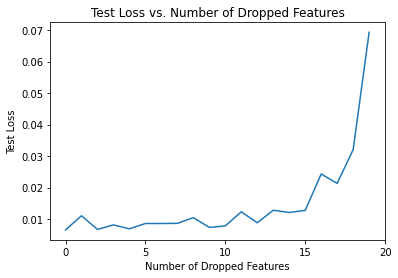

In [85]:
plt.plot(range(len(recalls)), [xx[-1] for xx in loss_graphs])
plt.xticks([0,5,10,15,20])
plt.title('Test Loss vs. Number of Dropped Features')
plt.ylabel('Test Loss')
plt.xlabel('Number of Dropped Features')
plt.savefig("test_loss.png")

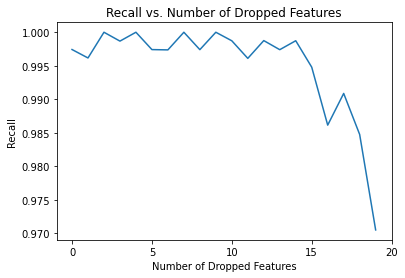

In [84]:
plt.plot(range(len(recalls)), recalls)
plt.xticks([0,5,10,15,20])
plt.title('Recall vs. Number of Dropped Features')
plt.ylabel('Recall')
plt.xlabel('Number of Dropped Features')
plt.savefig("recall.png")